<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/IRC015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os  # 导入操作系统模块
import pickle  # 导入pickle模块
import tempfile  # 导入临时文件模块

from sklearn.datasets import load_breast_cancer  # 导入乳腺癌数据集
from sklearn.model_selection import train_test_split  # 导入 train_test_split 函数
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # 导入评估指标函数



import xgboost  # 导入xgboost模块



def training_continuation(tmpdir: str, use_pickle: bool) -> None:
    # 基础训练延续
    X, y = load_breast_cancer(return_X_y=True)  # 加载乳腺癌数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 划分训练集和测试集

    # 方法一：在一个会话中训练128次迭代
    clf1 = xgboost.XGBClassifier(n_estimators=128, eval_metric="logloss", random_state=42)  # 创建XGB分类器
    clf1.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)  # 训练模型

    # 方法二：在两个会话中训练128次迭代
    clf2_1 = xgboost.XGBClassifier(n_estimators=32, eval_metric="logloss", random_state=42)  # 创建第一个XGB分类器
    clf2_1.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)  # 训练模型

    # 加载模型
    if use_pickle:
        path = os.path.join(tmpdir, "model-first-32.pkl")
        with open(path, "wb") as fd:
            pickle.dump(clf2_1, fd)
        with open(path, "rb") as fd:
            loaded = pickle.load(fd)
    else:
        path = os.path.join(tmpdir, "model-first-32.json")
        clf2_1.save_model(path)
        loaded = xgboost.XGBClassifier()
        loaded.load_model(path)

    clf2_2 = xgboost.XGBClassifier(n_estimators=128 - 32, eval_metric="logloss", random_state=42)  # 创建第二个XGB分类器
    clf2_2.fit(X_train, y_train, eval_set=[(X_test, y_test)], xgb_model=loaded, verbose=False)  # 训练模型

    # 评估模型性能
    y_pred1 = clf1.predict(X_test)
    y_pred2 = clf2_2.predict(X_test)

    print("方法一性能：")
    print(f"  准确率：{accuracy_score(y_test, y_pred1)}")
    print(f"  精确率：{precision_score(y_test, y_pred1)}")
    print(f"  召回率：{recall_score(y_test, y_pred1)}")
    print(f"  F1分数：{f1_score(y_test, y_pred1)}")
    print(f"  AUC：{roc_auc_score(y_test, y_pred1)}")

    print("方法二性能：")
    print(f"  准确率：{accuracy_score(y_test, y_pred2)}")
    print(f"  精确率：{precision_score(y_test, y_pred2)}")
    print(f"  召回率：{recall_score(y_test, y_pred2)}")
    print(f"  F1分数：{f1_score(y_test, y_pred2)}")
    print(f"  AUC：{roc_auc_score(y_test, y_pred2)}")


def training_continuation_early_stop(tmpdir: str, use_pickle: bool) -> None:
    # 使用早停的训练延续
    early_stopping_rounds = 5  # 设置早停轮数
    early_stop = xgboost.callback.EarlyStopping(  # 创建早停回调
        rounds=early_stopping_rounds, save_best=True
    )
    n_estimators = 512  # 设置估计器数量

    X, y = load_breast_cancer(return_X_y=True)  # 加载乳腺癌数据集
    clf = xgboost.XGBClassifier(  # 创建XGB分类器
        n_estimators=n_estimators, eval_metric="logloss", callbacks=[early_stop]
    )
    clf.fit(X, y, eval_set=[(X, y)])  # 训练模型
    print("Total boosted rounds:", clf.get_booster().num_boosted_rounds())  # 打印总提升轮数
    best = clf.best_iteration  # 获取最佳迭代次数

    # 在两个会话中训练512次迭代，第一个会话运行128次迭代，第二个会话运行直到早停
    clf = xgboost.XGBClassifier(  # 创建XGB分类器
        n_estimators=128, eval_metric="logloss", callbacks=[early_stop]
    )
    # 重新初始化早停回调
    early_stop = xgboost.callback.EarlyStopping(  # 创建早停回调
        rounds=early_stopping_rounds, save_best=True
    )
    clf.set_params(callbacks=[early_stop])  # 设置回调
    clf.fit(X, y, eval_set=[(X, y)])  # 训练模型
    assert clf.get_booster().num_boosted_rounds() == 128  # 断言提升轮数是否为128

    # 加载模型，这可能是一个检查点
    if use_pickle:  # 如果使用pickle
        path = os.path.join(tmpdir, "model-first-128.pkl")  # 设置pickle文件路径
        with open(path, "wb") as fd:  # 打开pickle文件
            pickle.dump(clf, fd)  # 保存模型到pickle文件
        with open(path, "rb") as fd:  # 打开pickle文件
            loaded = pickle.load(fd)  # 从pickle文件加载模型
    else:  # 如果不使用pickle
        path = os.path.join(tmpdir, "model-first-128.json")  # 设置json文件路径
        clf.save_model(path)  # 保存模型到json文件
        loaded = xgboost.XGBClassifier()  # 创建新的XGB分类器
        loaded.load_model(path)  # 从json文件加载模型

    early_stop = xgboost.callback.EarlyStopping(  # 创建早停回调
        rounds=early_stopping_rounds, save_best=True
    )
    clf = xgboost.XGBClassifier(  # 创建XGB分类器
        n_estimators=n_estimators - 128, eval_metric="logloss", callbacks=[early_stop]
    )
    clf.fit(  # 训练模型
        X,
        y,
        eval_set=[(X, y)],
        xgb_model=loaded,
    )

    print("Total boosted rounds:", clf.get_booster().num_boosted_rounds())  # 打印总提升轮数
    assert clf.best_iteration == best  # 断言最佳迭代次数是否相等


if __name__ == "__main__":
    with tempfile.TemporaryDirectory() as tmpdir:  # 创建临时目录
        training_continuation_early_stop(tmpdir, False)  # 使用json进行早停训练延续
        training_continuation_early_stop(tmpdir, True)  # 使用pickle进行早停训练延续

        training_continuation(tmpdir, True)  # 使用pickle进行训练延续
        training_continuation(tmpdir, False)  # 使用json进行训练延续

[0]	validation_0-logloss:0.43281
[1]	validation_0-logloss:0.30816
[2]	validation_0-logloss:0.22816
[3]	validation_0-logloss:0.17470
[4]	validation_0-logloss:0.13438
[5]	validation_0-logloss:0.10538
[6]	validation_0-logloss:0.08467
[7]	validation_0-logloss:0.06909
[8]	validation_0-logloss:0.05766
[9]	validation_0-logloss:0.04842
[10]	validation_0-logloss:0.04121
[11]	validation_0-logloss:0.03545
[12]	validation_0-logloss:0.03077
[13]	validation_0-logloss:0.02742
[14]	validation_0-logloss:0.02444
[15]	validation_0-logloss:0.02208
[16]	validation_0-logloss:0.01993
[17]	validation_0-logloss:0.01819
[18]	validation_0-logloss:0.01676
[19]	validation_0-logloss:0.01575
[20]	validation_0-logloss:0.01461
[21]	validation_0-logloss:0.01383
[22]	validation_0-logloss:0.01304
[23]	validation_0-logloss:0.01243
[24]	validation_0-logloss:0.01179
[25]	validation_0-logloss:0.01142
[26]	validation_0-logloss:0.01103
[27]	validation_0-logloss:0.01066
[28]	validation_0-logloss:0.01037
[29]	validation_0-loglos

In [2]:
import os  # 导入操作系统模块
import pickle  # 导入pickle模块
import tempfile  # 导入临时文件模块

from sklearn.datasets import load_breast_cancer  # 导入乳腺癌数据集
from sklearn.model_selection import train_test_split  # 导入 train_test_split 函数
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # 导入评估指标函数

import lightgbm as lgb  # 导入lightgbm模块


def training_continuation(tmpdir: str, use_pickle: bool) -> None:
    """Basic training continuation."""  # 基础训练延续
    X, y = load_breast_cancer(return_X_y=True)  # 加载乳腺癌数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 划分训练集和测试集

    # 方法一：在一个会话中训练128次迭代
    clf1 = lgb.LGBMClassifier(n_estimators=128, random_state=42, verbose=-1)  # 创建LightGBM分类器
    clf1.fit(X_train, y_train, eval_set=[(X_test, y_test)])  # 训练模型

    # 方法二：在两个会话中训练128次迭代
    clf2_1 = lgb.LGBMClassifier(n_estimators=32, random_state=42, verbose=-1)  # 创建第一个LightGBM分类器
    clf2_1.fit(X_train, y_train, eval_set=[(X_test, y_test)])  # 训练模型

    # 加载模型
    if use_pickle:
        path = os.path.join(tmpdir, "model-first-32.pkl")
        with open(path, "wb") as fd:
            pickle.dump(clf2_1, fd)
        with open(path, "rb") as fd:
            loaded = pickle.load(fd)
    else:
        path = os.path.join(tmpdir, "model-first-32.txt")
        clf2_1.booster_.save_model(path)
        loaded = lgb.Booster(model_file=path)

    clf2_2 = lgb.LGBMClassifier(n_estimators=128 - 32, random_state=42, verbose=-1)  # 创建第二个LightGBM分类器
    clf2_2.fit(X_train, y_train, eval_set=[(X_test, y_test)], init_model=loaded)  # 训练模型

    # 评估模型性能
    y_pred1 = clf1.predict(X_test)
    y_pred2 = clf2_2.predict(X_test)

    print("方法一性能：")
    print(f"  准确率：{accuracy_score(y_test, y_pred1)}")
    print(f"  精确率：{precision_score(y_test, y_pred1)}")
    print(f"  召回率：{recall_score(y_test, y_pred1)}")
    print(f"  F1分数：{f1_score(y_test, y_pred1)}")
    print(f"  AUC：{roc_auc_score(y_test, y_pred1)}")

    print("方法二性能：")
    print(f"  准确率：{accuracy_score(y_test, y_pred2)}")
    print(f"  精确率：{precision_score(y_test, y_pred2)}")
    print(f"  召回率：{recall_score(y_test, y_pred2)}")
    print(f"  F1分数：{f1_score(y_test, y_pred2)}")
    print(f"  AUC：{roc_auc_score(y_test, y_pred2)}")


def training_continuation_early_stop(tmpdir: str, use_pickle: bool) -> None:
    """Training continuation with early stopping."""  # 使用早停的训练延续
    early_stopping_rounds = 5  # 设置早停轮数
    n_estimators = 512  # 设置估计器数量

    X, y = load_breast_cancer(return_X_y=True)  # 加载乳腺癌数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 划分训练集和测试集

    early_stop_callback = lgb.early_stopping(stopping_rounds=early_stopping_rounds)

    clf = lgb.LGBMClassifier(n_estimators=n_estimators, random_state=42, verbose=-1)  # 创建LightGBM分类器
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[early_stop_callback])  # 训练模型
    print("Total boosted rounds:", clf.booster_.num_trees())  # 打印总提升轮数
    best = clf.best_iteration_

    # 在两个会话中训练512次迭代，第一个会话运行128次迭代，第二个会话运行直到早停
    clf = lgb.LGBMClassifier(n_estimators=128, random_state=42, verbose=-1)  # 创建LightGBM分类器
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])  # 训练模型
    assert clf.booster_.num_trees() == 128  # 断言提升轮数是否为128

    # 加载模型，这可能是一个检查点
    if use_pickle:
        path = os.path.join(tmpdir, "model-first-128.pkl")
        with open(path, "wb") as fd:
            pickle.dump(clf, fd)
        with open(path, "rb") as fd:
            loaded = pickle.load(fd)
    else:
        path = os.path.join(tmpdir, "model-first-128.txt")
        clf.booster_.save_model(path)
        loaded = lgb.Booster(model_file=path)

    clf = lgb.LGBMClassifier(n_estimators=n_estimators - 128, random_state=42, verbose=-1)  # 创建LightGBM分类器
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], init_model=loaded, callbacks=[early_stop_callback])  # 训练模型

    print("Total boosted rounds:", clf.booster_.num_trees())  # 打印总提升轮数
    #assert clf.best_iteration_ == best  # 断言最佳迭代次数是否相等


if __name__ == "__main__":
    with tempfile.TemporaryDirectory() as tmpdir:
        training_continuation(tmpdir, True)  # 使用pickle进行训练延续
        training_continuation(tmpdir, False)  # 使用json进行训练延续
        training_continuation_early_stop(tmpdir, False)  # 使用json进行早停训练延续
        training_continuation_early_stop(tmpdir, True)  # 使用pickle进行早停训练延续

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

方法一性能：
  准确率：0.9649122807017544
  精确率：0.958904109589041
  召回率：0.9859154929577465
  F1分数：0.9722222222222222
  AUC：0.9580740255486406
方法二性能：
  准确率：0.9649122807017544
  精确率：0.958904109589041
  召回率：0.9859154929577465
  F1分数：0.9722222222222222
  AUC：0.9580740255486406


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


方法一性能：
  准确率：0.9649122807017544
  精确率：0.958904109589041
  召回率：0.9859154929577465
  F1分数：0.9722222222222222
  AUC：0.9580740255486406
方法二性能：
  准确率：0.9649122807017544
  精确率：0.958904109589041
  召回率：0.9859154929577465
  F1分数：0.9722222222222222
  AUC：0.9580740255486406
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.10416
Total boosted rounds: 45


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.168008
Total boosted rounds: 129
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.10416
Total boosted rounds: 45


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.168008
Total boosted rounds: 129


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


你提供的是 UCI Credit Card 数据集，这是一个非常适合信贷风控场景的数据集。我会使用这个数据集，并按照之前讨论的方案，用 Python 和 XGBoost 实现两种增量训练方式的演示，并着重展示如何应对幸存者偏差。

以下是详细的步骤和代码：

**1. 数据准备与幸存者偏差模拟**

```python
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 加载数据集
url = "https://archive.ics.uci.edu/static/public/350/default%20of%20credit%20card%20clients.xls"
data = pd.read_excel(url, header=1)
data.rename(columns={'default payment next month': 'target'}, inplace=True)

# 划分特征和目标变量
X = data.drop('target', axis=1)
y = data['target']

# 模拟幸存者偏差：仅保留初始批准的客户（假设批准的客户 target=0）
X_approved = X[y == 0]
y_approved = y[y == 0]

# 划分数据集
X_train_initial, X_test, y_train_initial, y_test = train_test_split(X_approved, y_approved, test_size=0.2, random_state=42)
X_train_new, _, y_train_new, _ = train_test_split(X, y, test_size=0.5, random_state=42) # 使用全部数据模拟新增数据
```

**2. 初始模型训练**

```python
# 初始模型训练
dtrain_initial = xgb.DMatrix(X_train_initial, label=y_train_initial)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42
}

initial_model = xgb.train(params, dtrain_initial, num_boost_round=100)

# 初始模型评估
y_pred_initial = (initial_model.predict(dtest) > 0.5).astype(int)
accuracy_initial = accuracy_score(y_test, y_pred_initial)
print(f"初始模型准确率: {accuracy_initial}")
```

**3. 增量训练方式一：追加新树**

```python
# 增量训练（追加新树）
dtrain_new = xgb.DMatrix(X_train_new, label=y_train_new)

incremental_model_add_tree = xgb.train(
    params,
    dtrain_new,
    num_boost_round=50,  # 追加 50 棵树
    xgb_model=initial_model  # 加载初始模型
)

# 增量模型评估
y_pred_add_tree = (incremental_model_add_tree.predict(dtest) > 0.5).astype(int)
accuracy_add_tree = accuracy_score(y_test, y_pred_add_tree)
print(f"追加新树后的准确率: {accuracy_add_tree}")
```

**4. 增量训练方式二：更新叶节点权重**

```python
# 增量训练（更新叶节点权重）
incremental_model_update_leaf = xgb.train(
    params,
    dtrain_new,
    num_boost_round=0,  # 不追加新树
    xgb_model=initial_model,
    process_type='update',
    updater='refresh'
)

# 增量模型评估
y_pred_update_leaf = (incremental_model_update_leaf.predict(dtest) > 0.5).astype(int)
accuracy_update_leaf = accuracy_score(y_test, y_pred_update_leaf)
print(f"更新叶节点权重后的准确率: {accuracy_update_leaf}")

# 也可以同时追加新树和更新权重
incremental_model_update_leaf_add_tree = xgb.train(
    params,
    dtrain_new,
    num_boost_round=50,  # 追加 50 棵树
    xgb_model=incremental_model_update_leaf,
    process_type='update',
    updater='refresh'
)

y_pred_update_leaf_add_tree = (incremental_model_update_leaf_add_tree.predict(dtest) > 0.5).astype(int)
accuracy_update_leaf_add_tree = accuracy_score(y_test, y_pred_update_leaf_add_tree)
print(f"更新叶节点权重并追加新树后的准确率: {accuracy_update_leaf_add_tree}")
```

**代码分析和重点解释：**

* **幸存者偏差模拟：**
    * 通过仅使用 `target=0`（即未违约的客户）的数据来训练初始模型，模拟了仅基于批准客户数据建模的情况，从而引入幸存者偏差。
* **增量训练的优势：**
    * 通过增量训练，我们让模型能够逐步学习包含所有客户（包括违约客户）的新数据，从而纠正初始模型中的偏差。
    * 两种增量训练方法都展示了如何利用已有的模型知识，并在此基础上进行更新，而不是从头开始训练。
* **两种增量训练方式的差异：**
    * **追加新树：** 这种方法通过增加新的决策树来捕捉新数据中的模式。适用于新数据引入了新的复杂性，或者需要更细致地划分数据的情况。
    * **更新叶节点权重：** 这种方法通过调整现有决策树的叶节点权重来适应新数据，更适用于数据分布发生细微变化的情况。
* **评估指标：**
    * 使用了准确率（accuracy）作为评估指标。在实际的信贷风控场景中，还可以使用其他更适合不平衡数据集的指标，例如 AUC、精确率、召回率和 F1 分数。

**如何观察幸存者偏差的影响：**

1.  对比初始模型的准确率和增量模型的准确率。如果增量模型的准确率显著提高，说明幸存者偏差对初始模型产生了负面影响，而增量训练有效地纠正了这种偏差。
2.  可以进一步分析模型的预测结果，例如查看混淆矩阵，来了解模型在识别违约客户方面的表现。

通过这个示例，你可以更深入地理解 XGBoost 的增量训练方法，以及如何在实际的信贷风控场景中应对幸存者偏差。


In [3]:
!wget https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip

--2025-03-14 07:44:35--  https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘default+of+credit+card+clients.zip’

default+of+credit+c     [  <=>               ]   5.28M  19.2MB/s    in 0.3s    

2025-03-14 07:44:36 (19.2 MB/s) - ‘default+of+credit+card+clients.zip’ saved [5539494]



In [4]:
!wget https://archive.ics.uci.edu/static/public/350/data.csv

--2025-03-14 07:44:36--  https://archive.ics.uci.edu/static/public/350/data.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.csv’

data.csv                [  <=>               ]   2.76M  12.4MB/s    in 0.2s    

2025-03-14 07:44:36 (12.4 MB/s) - ‘data.csv’ saved [2897080]



In [5]:
!pip install ucimlrepo

In [6]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

# metadata
print(default_of_credit_card_clients.metadata)

# variable information
print(default_of_credit_card_clients.variables)


{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [7]:
import xgboost as xgb
from sklearn.datasets import make_classification

# 创建初始数据集
X, y = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0, random_state=0, shuffle=False)

# 初始训练
dtrain = xgb.DMatrix(X, label=y)
param = {'max_depth':2, 'eta':1}
num_round = 2
model = xgb.train(param, dtrain, num_round)

# 新数据集
X_new, y_new = make_classification(n_samples=100, n_features=4, n_informative=2, n_redundant=0, random_state=0, shuffle=False)
dnew = xgb.DMatrix(X_new, label=y_new)

# 增量训练
model = xgb.train(param, dnew, num_round, xgb_model=model)


金融机构需要衡量其信贷投资组合中的风险，以满足监管要求和内部风险管理的需求。为了满足这些要求，金融机构越来越依赖模型和算法来预测客户违约造成的损失。因此，开发足够准确和稳健的模型是这些机构内部定量风险管理团队的主要工作之一。

拟议的研究正是为了开发用于信贷违约风险问题的稳健高效模型而做出的努力。具体而言，我们研究了一些机器学习分类算法的数学基础，并开发它们来预测信用卡账户的违约风险。



In [8]:
from IPython.display import HTML

HTML('''
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [9]:
import sklearn
print(sklearn.__file__)
print(sklearn.__version__)
import pandas
print(pandas.__file__)
print(pandas.__version__)
import numpy
print(numpy.__file__)
print(numpy.__version__)

/usr/local/lib/python3.11/dist-packages/sklearn/__init__.py
1.6.1
/usr/local/lib/python3.11/dist-packages/pandas/__init__.py
2.2.2
/usr/local/lib/python3.11/dist-packages/numpy/__init__.py
1.26.4


In [10]:
import pandas as pd  # 导入pandas库，用于数据处理
import numpy as np  # 导入numpy库，用于数值计算

# Preprocessing（预处理部分）
from sklearn.model_selection import train_test_split  # 导入train_test_split，用于划分训练集和测试集
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # 导入StandardScaler和MinMaxScaler，用于数据标准化和归一化
from sklearn.decomposition import PCA  # 导入PCA，用于主成分分析（降维）
from imblearn.under_sampling import ClusterCentroids  # 导入ClusterCentroids，用于聚类中心欠采样
from imblearn.over_sampling import KMeansSMOTE, SMOTE  # 导入KMeansSMOTE和SMOTE，用于过采样（处理不平衡数据集）

# Classifiers（分类器部分）
from sklearn.linear_model import LogisticRegression  # 导入LogisticRegression，用于逻辑回归分类
from sklearn.svm import SVC  # 导入SVC，用于支持向量机分类
from sklearn import tree  # 导入tree，用于决策树相关
from pydotplus import graph_from_dot_data  # 导入graph_from_dot_data，用于可视化决策树
from sklearn.tree import DecisionTreeClassifier  # 导入DecisionTreeClassifier，用于决策树分类
from sklearn.ensemble import RandomForestClassifier  # 导入RandomForestClassifier，用于随机森林分类

# Metrics（评估指标部分）
from sklearn.model_selection import GridSearchCV  # 导入GridSearchCV，用于网格搜索（参数调优）
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc, precision_recall_curve, confusion_matrix  # 导入各种评估指标
#from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve  # 导入绘制混淆矩阵和PR曲线的函数
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay # 导入绘制混淆矩阵和PR曲线

# Visualization（可视化部分）
import matplotlib  # 导入matplotlib库，用于绘图
import matplotlib.pyplot as plt  # 导入pyplot，用于绘制图表
import seaborn as sns  # 导入seaborn库，用于统计数据可视化
from scipy import stats  # 导入scipy.stats，用于统计计算

#%matplotlib inline  # 在Jupyter Notebook中显示图表
sns.set_style('darkgrid')  # 设置seaborn绘图风格为深色网格
random_state = 42  # 设置随机种子，保证结果可重复
import warnings  # 导入warnings库，用于处理警告
warnings.filterwarnings("ignore")  # 忽略警告信息

# 1. 引言

自1990年起，台湾政府允许设立新银行。这些新银行最初与房地产公司开展业务，但当市场饱和时，它们转向了信用卡业务。为了增加市场份额，这些银行向不合格的申请人过度发放现金卡和信用卡。与此同时，大多数持卡人，无论其还款能力如何，都过度使用信用卡进行消费，并累积了沉重的信用卡和现金卡债务。*违约*是指信用卡持卡人无法履行法定的还款义务。这场危机打击了消费者金融信心，对银行和持卡人来说都是一个巨大的挑战。

在一个发达的金融体系中，危机管理处于下游，而风险预测处于上游。风险预测的主要目的是利用财务信息，如企业财务报表、客户交易和还款记录等，来预测企业绩效或个人客户的信用风险，并减少损失和不确定性。

在这个项目中，我们的任务是可靠地预测哪些人可能违约。如果是这样，银行可以通过向客户提供替代方案（如延期付款或债务合并等）来防止损失。因此，我们基于客户信息和历史交易记录构建了一个自动化模型，能够识别关键因素并预测信用卡违约。


# 2. 探索性数据分析

## 2.1 数据集描述

我们的研究基于 UCI 机器学习库中的“信用卡客户违约”数据集。它收集了台湾一家银行从2005年4月到2005年9月对不同信用卡持有人的 30,000 条观察数据。该数据集使用二元变量 `default.payment.next.month` 作为响应变量。它表示信用卡持有人是否会在下个月违约（是=1，否=0）。然后，以下 23 个变量用作解释变量。

-  客户个人信息：
    1.  `LIMIT_BAL`：给予的信用额度（新台币）：包括个人消费信用及其家庭（补充）信用。
    2.  `SEX`：1 = 男性；2 = 女性。
    3.  `EDUCATION`：1 = 研究生；2 = 大学；3 = 高中；4 = 其他。
    4.  `MARRIAGE`：婚姻状况，1 = 已婚；2 = 单身；3 = 其他。
    5.  `AGE`：年龄（岁）。
-  2005年4月至9月的还款历史，即特定月份的还款延迟：
    6.  `PAY_0`：2005年9月的还款状态。
    7.  `PAY_2`：2005年8月的还款状态。
    8.  `PAY_3`：2005年7月的还款状态。
    9.  `PAY_4`：2005年6月的还款状态。
    10. `PAY_5`：2005年5月的还款状态。
    11. `PAY_6`：2005年4月的还款状态。

    还款状态的度量标准为：-1 = 按时还款；1 = 延迟一个月；2 = 延迟两个月；...；8 = 延迟八个月；9 = 延迟九个月及以上。
-  账单金额（新台币），即信用卡公司在特定月份向信用卡持有人发出的月度报告：
    12. `BILL_AMT1`：2005年9月的账单金额。
    13. `BILL_AMT2`：2005年8月的账单金额。
    14. `BILL_AMT3`：2005年7月的账单金额。
    15. `BILL_AMT4`：2005年6月的账单金额。
    16. `BILL_AMT5`：2005年5月的账单金额。
    17. `BILL_AMT6`：2005年4月的账单金额。
-  先前付款金额（新台币）：
    18. `PAY_AMT1`：2005年9月的先前付款金额。
    19. `PAY_AMT2`：2005年8月的先前付款金额。
    20. `PAY_AMT3`：2005年7月的先前付款金额。
    21. `PAY_AMT4`：2005年6月的先前付款金额。
    22. `PAY_AMT5`：2005年5月的先前付款金额。
    23. `PAY_AMT6`：2005年4月的先前付款金额。

为了了解数据的外观，我们在下表中打印了一些观察结果。目标变量 `default.payment.next.month` 重命名为 `DEFAULT` 以缩短长度，而 `PAY_0` 列重命名为 `PAY_1`。

在信用卡或信贷环境中，“先前付款金额”和“账单金额”是两个不同的概念，它们代表了不同的财务活动：

**1. 账单金额（BILL_AMT）**

* **定义：**
    * 账单金额是指在特定时间段内（通常是一个月）信用卡或信贷账户上产生的消费总额。
    * 它包括所有通过信用卡进行的购物、服务消费、取现以及可能产生的利息和费用。
    * 账单金额是信用卡公司向持卡人发出的月度报告中显示的应付款项。
* **作用：**
    * 账单金额反映了持卡人在特定时间段内的消费行为和债务积累情况。
    * 它也是信用卡公司计算最低还款额和利息的基础。

**2. 先前付款金额（PAY_AMT）**

* **定义：**
    * 先前付款金额是指持卡人在特定时间段内实际向信用卡账户支付的金额。
    * 这笔金额可以是最低还款额、部分还款额或全额还款额。
* **作用：**
    * 先前付款金额反映了持卡人的还款行为和还款能力。
    * 它直接影响信用卡账户的欠款余额和利息计算。

**简单来说：**

* 账单金额是“欠多少”。
* 先前付款金额是“还多少”。

**举例说明：**

* 假设一个持卡人在9月份的账单金额为5000元。
* 他在10月份进行了3000元的还款。
* 那么，9月份的账单金额为5000元，9月份的先前付款金额为3000元。

**在信贷风险评估中的作用：**

* 账单金额和先前付款金额都是评估持卡人信用风险的重要指标。
* 通过分析这两个指标，可以了解持卡人的消费习惯、还款能力和违约风险。
* 例如，如果一个持卡人经常出现账单金额很高但还款金额很低的情况，那么他的违约风险可能较高。


In [11]:
# 读取并创建数据框
df = pd.read_csv('data.csv', index_col='ID')  # 从CSV文件读取数据，并将'ID'列设置为索引


df.rename(columns={'X1': 'LIMIT_BAL'}, inplace=True)
df.rename(columns={'X2': 'SEX'}, inplace=True)
df.rename(columns={'X3': 'EDUCATION'}, inplace=True)
df.rename(columns={'X4': 'MARRIAGE'}, inplace=True)
df.rename(columns={'X5': 'AGE'}, inplace=True)
df.rename(columns={'X6': 'PAY_1'}, inplace=True)
df.rename(columns={'X7': 'PAY_2'}, inplace=True)
df.rename(columns={'X8': 'PAY_3'}, inplace=True)
df.rename(columns={'X9': 'PAY_4'}, inplace=True)
df.rename(columns={'X10': 'PAY_5'}, inplace=True)
df.rename(columns={'X11': 'PAY_6'}, inplace=True)
df.rename(columns={'X12': 'BILL_AMT1'}, inplace=True)
df.rename(columns={'X13': 'BILL_AMT2'}, inplace=True)
df.rename(columns={'X14': 'BILL_AMT3'}, inplace=True)
df.rename(columns={'X15': 'BILL_AMT4'}, inplace=True)
df.rename(columns={'X16': 'BILL_AMT5'}, inplace=True)
df.rename(columns={'X17': 'BILL_AMT6'}, inplace=True)
df.rename(columns={'X18': 'PAY_AMT1'}, inplace=True)
df.rename(columns={'X19': 'PAY_AMT2'}, inplace=True)
df.rename(columns={'X20': 'PAY_AMT3'}, inplace=True)
df.rename(columns={'X21': 'PAY_AMT4'}, inplace=True)
df.rename(columns={'X22': 'PAY_AMT5'}, inplace=True)
df.rename(columns={'X23': 'PAY_AMT6'}, inplace=True)
df.rename(columns={'Y': 'DEFAULT'}, inplace=True)

df.head()  # 显示数据框的前几行

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   30000 

## 2.2 数据清洗

### 2.2.1 客户个人信息

下面我们打印客户个人信息特征的描述。`LIMIT_BAL`、`SEX` 和 `AGE` 属性似乎与提供的描述一致，而 `EDUCATION` 和 `MARRIAGE` 有一些未记录的类别。`EDUCATION` 的范围从 0 到 6，而 `MARRIAGE` 从类别 0 开始。


In [13]:
df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500
std,129747.661567,0.489129,0.790349,0.521970,9.217904
min,10000.000000,1.000000,0.000000,0.000000,21.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000


In [14]:
df['EDUCATION'].value_counts().sort_index()

,count
EDUCATION,
0,14
1,10585
2,14030
3,4917
4,123
5,280
6,51


In [15]:
df['MARRIAGE'].value_counts().sort_index()

,count
MARRIAGE,
0,54
1,13659
2,15964
3,323


数据集中的错误可以通过更正错误的属性或删除与错误相关的行来解决。我们可以采取保守的方法，将未记录的类别归入“其他”，但由于异常条目相对较少（399个，占总数的1.33%），我们决定删除它们。


In [16]:
print(f"Dataset size before:\t{df.shape[0]}")
df = df.drop(df[df['MARRIAGE']==0].index)
df = df.drop(df[df['EDUCATION']==0].index)
df = df.drop(df[df['EDUCATION']==5].index)
df = df.drop(df[df['EDUCATION']==6].index)
print(f"Dataset size after:\t{df.shape[0]}")


Dataset size before:	30000
Dataset size after:	29601


### 2.2.2 过去的还款历史

下面我们打印过去的还款历史特征的描述。`PAY_n` 列的范围从 -2（未记录）到 8，因此我们认为它们需要重新调整以匹配官方描述。


In [17]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000
mean,-0.014932,-0.131313,-0.163440,-0.218303,-0.263978,-0.287558
std,1.124503,1.199642,1.199793,1.172220,1.136217,1.152206
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [18]:
pay_features = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for p in pay_features:
    df.loc[df[p]<0, p] = -1
    df.loc[df[p]>=0, p] = df.loc[df[p]>=0, p] + 1
    df[p] = df[p].astype('int64')

### 2.2.3 账单金额和先前付款金额

下面我们打印与账单金额和先前付款金额相关的特征的描述。我们没有发现任何异常。


In [19]:
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,29601.000000,29601.000000,2.960100e+04,29601.000000,29601.000000,29601.000000
mean,50957.432012,48942.189554,4.680320e+04,43122.554204,40235.545184,38858.449816
std,73370.242404,70923.985151,6.912389e+04,64196.383913,60699.344884,59519.893043
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3528.000000,2970.000000,2.652000e+03,2329.000000,1780.000000,1278.000000
50%,22259.000000,21050.000000,2.003500e+04,19005.000000,18091.000000,17118.000000
75%,66623.000000,63497.000000,5.983000e+04,54271.000000,50072.000000,49121.000000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [20]:
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,29601.000000,2.960100e+04,29601.000000,29601.000000,29601.000000,29601.000000
mean,5649.560319,5.894788e+03,5198.415898,4828.659268,4795.032735,5181.326374
std,16568.264941,2.308919e+04,17580.914806,15711.057992,15244.217154,17657.260739
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.250000e+02,390.000000,298.000000,259.000000,138.000000
50%,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5005.000000,5.000000e+03,4500.000000,4014.000000,4042.000000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


## 2.3 数据探索

在本节中，我们将展示一些图表，以更好地理解特征与目标变量 `DEFAULT` 之间的关系。

首先，我们看到我们正在处理的数据集非常不平衡，只有 6,636 个违约者（占总数的 22.1%）。这是一个相当重要的问题，需要解决。如果被忽视，分类模型将倾向于关注多数类而忽视少数类。


In [21]:
df['DEFAULT'].value_counts()

,count
DEFAULT,
0,22996
1,6605


In [22]:
import os

if not os.path.exists('images'):
    os.makedirs('images')

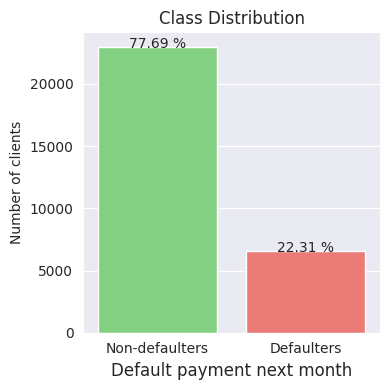

In [23]:
# 类别分布
plt.figure(figsize = (4,4)) # 创建一个指定大小的图形
graph_target = sns.countplot(x="DEFAULT", data=df, palette=['#77DD76','#FF6962']) # 使用seaborn的countplot绘制DEFAULT列的计数图，并指定颜色

i=0 # 初始化计数器
for p in graph_target.patches: # 遍历每个柱形图的矩形
    height = p.get_height() # 获取柱形图的高度

    percentage = round(100 * df["DEFAULT"].value_counts()[i] / len(df),2) # 计算每个类别占总数的百分比

    str_plot = f'{percentage} %' # 创建包含百分比的字符串

    graph_target.text(p.get_x()+p.get_width()/2., height - 100, str_plot, ha="center") # 在柱形图上添加百分比文本，居中显示
    i += 1 # 计数器加一

plt.title('Class Distribution') # 设置图表标题：类别分布
plt.xticks([0,1],['Non-defaulters', 'Defaulters']) # 设置x轴刻度标签：非违约者/违约者
plt.xlabel('Default payment next month', fontsize=12) # 设置x轴标签：下月是否违约
plt.ylabel('Number of clients') # 设置y轴标签：客户数量
plt.tight_layout() # 调整子图布局，避免重叠

plt.savefig('images/imbalanced_plot.svg') # 保存图形为SVG文件
plt.show() # 显示图形

对于特征 `LIMIT_BAL`，我们根据违约类型绘制了一个密度图，结果如下左图所示。看起来，当给予的信用额度大约低于 140,000 美元时，违约的概率大于非违约的概率。这表明信用额度较低的人更容易违约，而信用额度较高的人则不太可能违约。这一观察结果是有道理的，因为较高的信用额度是给予信用度较高的人的，他们违约的可能性较低。


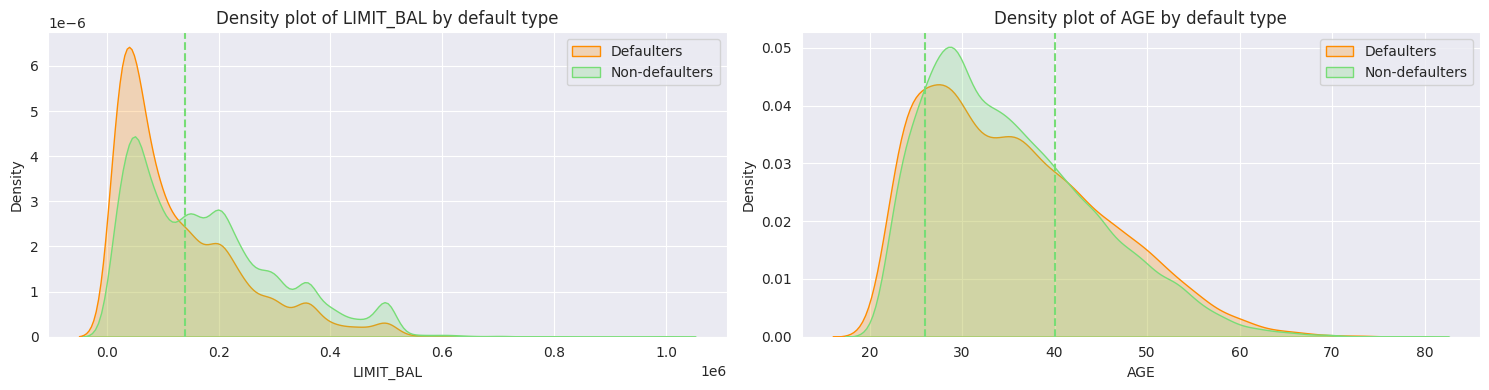

In [24]:
# 核密度分布
sns.set_palette(palette=['#77DD76','#FF6962']) # 设置seaborn调色板

fig, axs = plt.subplots(1, 2, figsize=(15,4)) # 创建一个包含两个子图的图形

class_0 = df.loc[df['DEFAULT'] == 0]['LIMIT_BAL'] # 获取DEFAULT为0的LIMIT_BAL数据
class_1 = df.loc[df['DEFAULT'] == 1]['LIMIT_BAL'] # 获取DEFAULT为1的LIMIT_BAL数据
axs[0].set_title('Density plot of LIMIT_BAL by default type') # 设置第一个子图的标题
sns.kdeplot(class_1, fill=True, label='Defaulters', color='darkorange', ax=axs[0]) # 绘制违约者的LIMIT_BAL核密度图
sns.kdeplot(class_0, fill=True, label='Non-defaulters', ax=axs[0]) # 绘制非违约者的LIMIT_BAL核密度图
axs[0].axvline(0.14*1e6, 0, ls='--') # 在第一个子图上绘制一条垂直虚线
axs[0].legend() # 显示第一个子图的图例

class_0 = df.loc[df['DEFAULT'] == 0]['AGE'] # 获取DEFAULT为0的AGE数据
class_1 = df.loc[df['DEFAULT'] == 1]['AGE'] # 获取DEFAULT为1的AGE数据
axs[1].set_title('Density plot of AGE by default type') # 设置第二个子图的标题
sns.kdeplot(class_1, fill=True, label='Defaulters', color='darkorange', ax=axs[1]) # 绘制违约者的AGE核密度图
sns.kdeplot(class_0, fill=True, label='Non-defaulters', ax=axs[1]) # 绘制非违约者的AGE核密度图
axs[1].axvline(26, 0, ls='--') # 在第二个子图上绘制一条垂直虚线
axs[1].axvline(40, 0, ls='--') # 在第二个子图上绘制另一条垂直虚线
axs[1].legend() # 显示第二个子图的图例

fig.tight_layout() # 调整子图布局，避免重叠
plt.savefig('images/continuosDistribution.svg') # 保存图形为SVG文件
plt.show() # 显示图形

对于特征 `AGE`，我们进行了类似的视觉分析，如上图右侧所示。年龄在约 25 岁到 40 岁之间的人群，其非违约的概率较高，这表明该年龄段的消费者更有能力偿还信用卡贷款。这可能是因为他们的工作和家庭趋于稳定，没有太大的压力。

特征 `SEX`、`EDUCATION` 和 `MARRIAGE` 使用直方图根据目标变量进行绘制，如下所示。无论是男性还是女性，违约者的比例都与总体情况一致，对于其他两个特征的类别，我们也可以这样说。


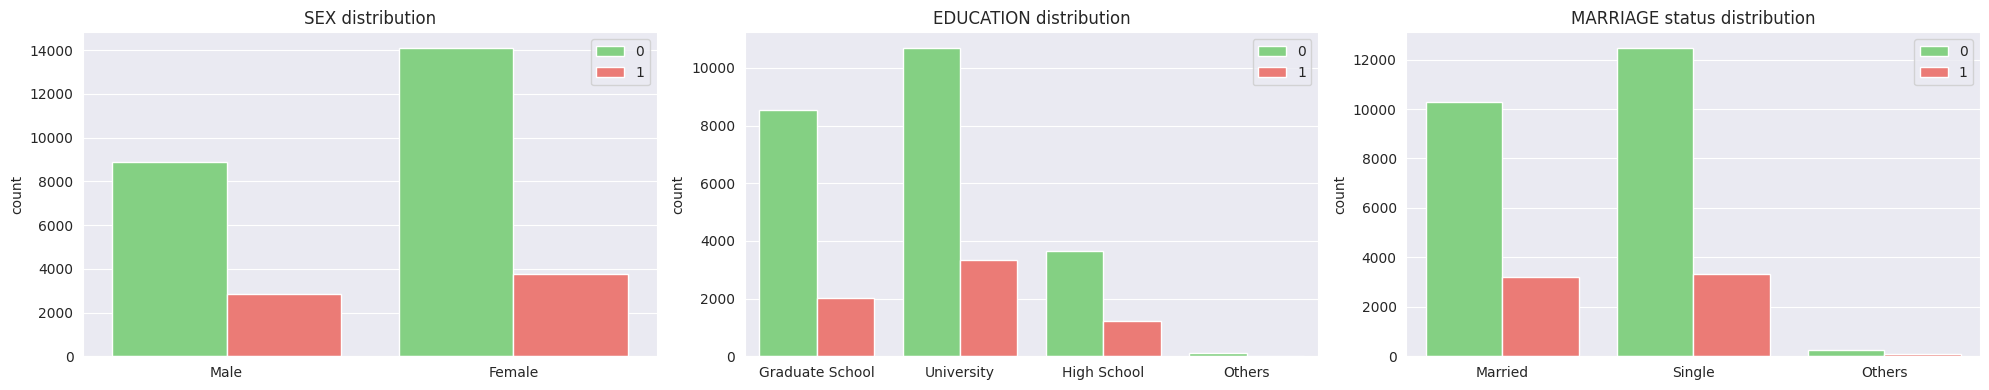

In [25]:
sns.set_palette(palette=['#77DD76','#FF6962']) # 设置seaborn调色板

fig, axs = plt.subplots(1, 3, figsize=(20,4)) # 创建一个包含三个子图的图形

axs[0].set_title('SEX distribution') # 设置第一个子图的标题
sns.countplot(x='SEX', hue='DEFAULT', data=df, ax=axs[0]) # 绘制SEX列的计数图，并按DEFAULT列分组
axs[0].set_xticklabels(['Male', 'Female']) # 设置第一个子图的x轴刻度标签
axs[0].set_xlabel('') # 清空第一个子图的x轴标签
axs[0].legend() # 显示第一个子图的图例

axs[1].set_title('EDUCATION distribution') # 设置第二个子图的标题
sns.countplot(x='EDUCATION', hue='DEFAULT', data=df, ax=axs[1]) # 绘制EDUCATION列的计数图，并按DEFAULT列分组
axs[1].set_xticklabels(['Graduate School', 'University', 'High School', 'Others']) # 设置第二个子图的x轴刻度标签
axs[1].set_xlabel('') # 清空第二个子图的x轴标签
axs[1].legend() # 显示第二个子图的图例

axs[2].set_title('MARRIAGE status distribution') # 设置第三个子图的标题
sns.countplot(x='MARRIAGE', hue='DEFAULT', data=df, ax=axs[2]) # 绘制MARRIAGE列的计数图，并按DEFAULT列分组
axs[2].set_xticklabels(['Married', 'Single', 'Others']) # 设置第三个子图的x轴刻度标签
axs[2].set_xlabel('') # 清空第三个子图的x轴标签
axs[2].legend() # 显示第三个子图的图例

fig.tight_layout() # 调整子图布局，避免重叠
plt.savefig('images/categoricalDistribution.svg') # 保存图形为SVG文件
plt.show() # 显示图形

In [26]:
#PAY_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'] # 定义包含PAY列名的列表
#plt.figure(figsize=(15,8)) # 创建一个指定大小的图形
#
#for i, col in enumerate(PAY_cols): # 遍历PAY列名列表，并获取索引和列名
#    plt.subplot(2,3,i + 1) # 创建子图，2行3列，当前子图索引为i+1
#    ax = sns.countplot(df.loc[:,col], palette = 'muted') # 绘制当前列的计数图，使用muted调色板
#    plt.ylim(0,20000) # 设置y轴的范围
#    plt.xlabel(col,fontsize=15) # 设置x轴标签，字体大小为15
#    plt.ylabel('') # 清空y轴标签
#    plt.tight_layout() # 调整子图布局，避免重叠
#
#    for p in ax.patches: # 遍历每个柱形图的矩形
#        ax.annotate((p.get_height()), (p.get_x(), p.get_height()+500), fontsize = 11) # 在柱形图上添加高度注释，字体大小为11
#
#plt.savefig('images/categoricalPAY.svg') # 保存图形为SVG文件
#plt.show() # 显示图形

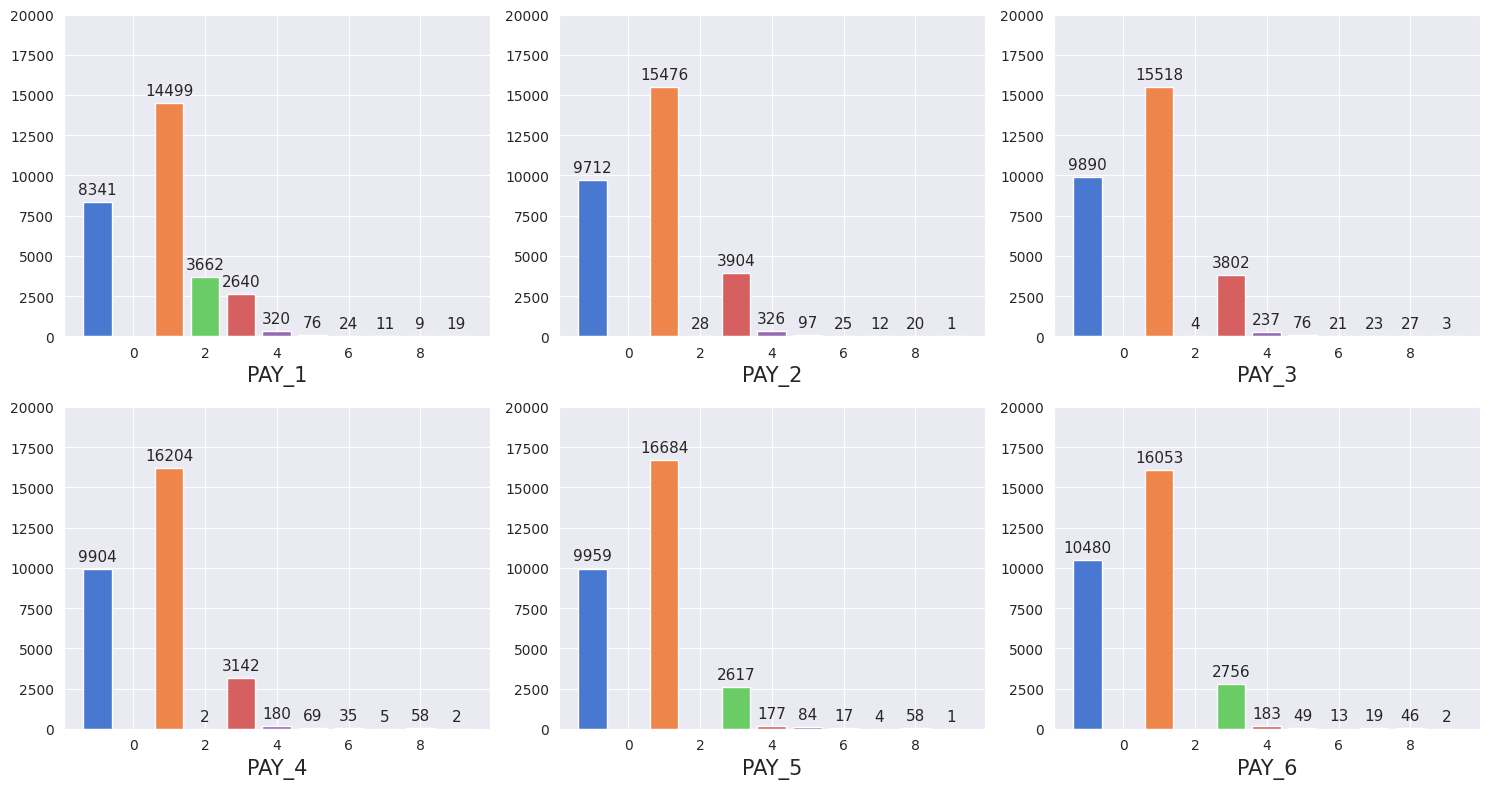

In [27]:
import matplotlib.pyplot as plt # 导入matplotlib.pyplot，用于绘制图表
import seaborn as sns # 导入seaborn，用于统计数据可视化
import pandas as pd # 导入pandas，用于数据处理

PAY_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'] # 定义包含PAY列名的列表
plt.figure(figsize=(15, 8)) # 创建一个指定大小的图形

for i, col in enumerate(PAY_cols): # 遍历PAY列名列表，并获取索引和列名
    plt.subplot(2, 3, i + 1) # 创建子图，2行3列，当前子图索引为i+1

    # 使用pandas的value_counts预先计算计数
    counts = df.loc[:, col].value_counts().sort_index() # 计算当前列的唯一值计数，并按索引排序

    # 使用plt.bar进行更快的绘图
    plt.bar(counts.index, counts.values, color=sns.color_palette('muted')) # 绘制柱状图，使用muted调色板

    plt.ylim(0, 20000) # 设置y轴的范围
    plt.xlabel(col, fontsize=15) # 设置x轴标签，字体大小为15
    plt.ylabel('') # 清空y轴标签
    plt.tight_layout() # 调整子图布局，避免重叠

    # 用计数注释柱状图
    for j, count in enumerate(counts.values): # 遍历计数列表，并获取索引和计数
        plt.text(counts.index[j], count + 500, count, ha='center', fontsize=11) # 在柱状图上添加计数注释，居中显示，字体大小为11

plt.savefig('images/categoricalPAY.svg') # 保存图形为SVG文件
plt.show() # 显示图形

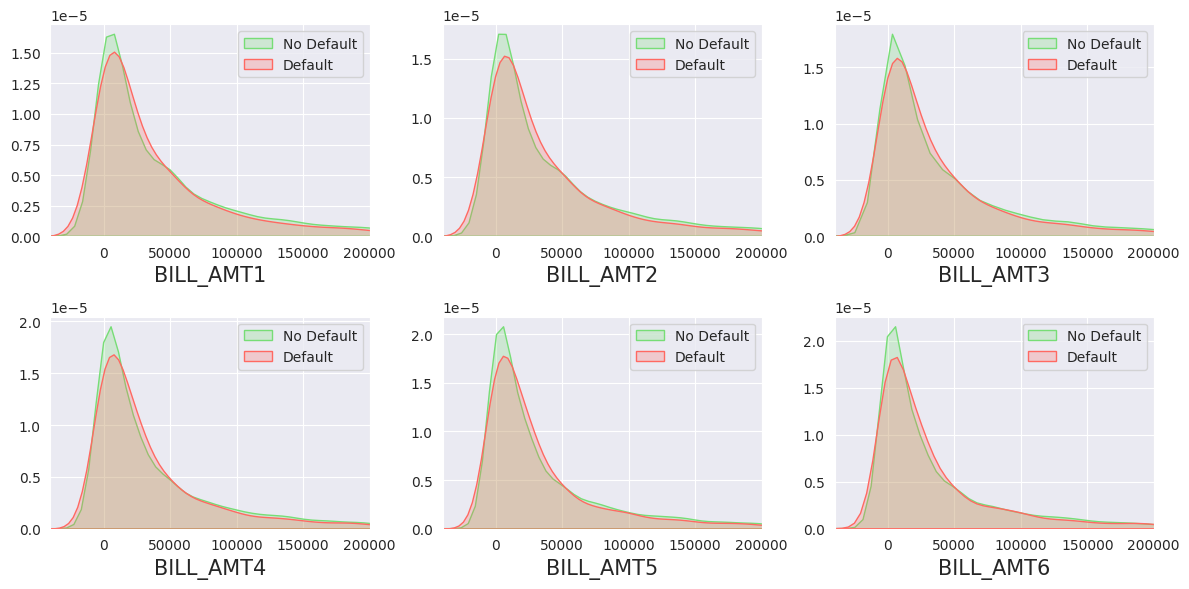

In [28]:
BILL_AMT_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'] # 定义包含BILL_AMT列名的列表
plt.figure(figsize=(12,6)) # 创建一个指定大小的图形

for i,col in enumerate(BILL_AMT_cols): # 遍历BILL_AMT列名列表，并获取索引和列名
    plt.subplot(2,3,i + 1) # 创建子图，2行3列，当前子图索引为i+1
    sns.kdeplot(df.loc[(df['DEFAULT'] == 0), col], label = 'No Default',color='#77DD76', shade=True) # 绘制未违约客户的当前列核密度图，填充阴影
    sns.kdeplot(df.loc[(df['DEFAULT'] == 1), col], label = 'Default', color='#FF6962', shade=True) # 绘制违约客户的当前列核密度图，填充阴影
    plt.xlim(-40000,200000) # 设置x轴的范围
    plt.ylabel('') # 清空y轴标签
    plt.xlabel(col,fontsize=15) # 设置x轴标签，字体大小为15
    plt.legend() # 显示图例
    plt.tight_layout() # 调整子图布局，避免重叠

plt.savefig('images/continuousBILLAMT.svg') # 保存图形为SVG文件
plt.show() # 显示图形

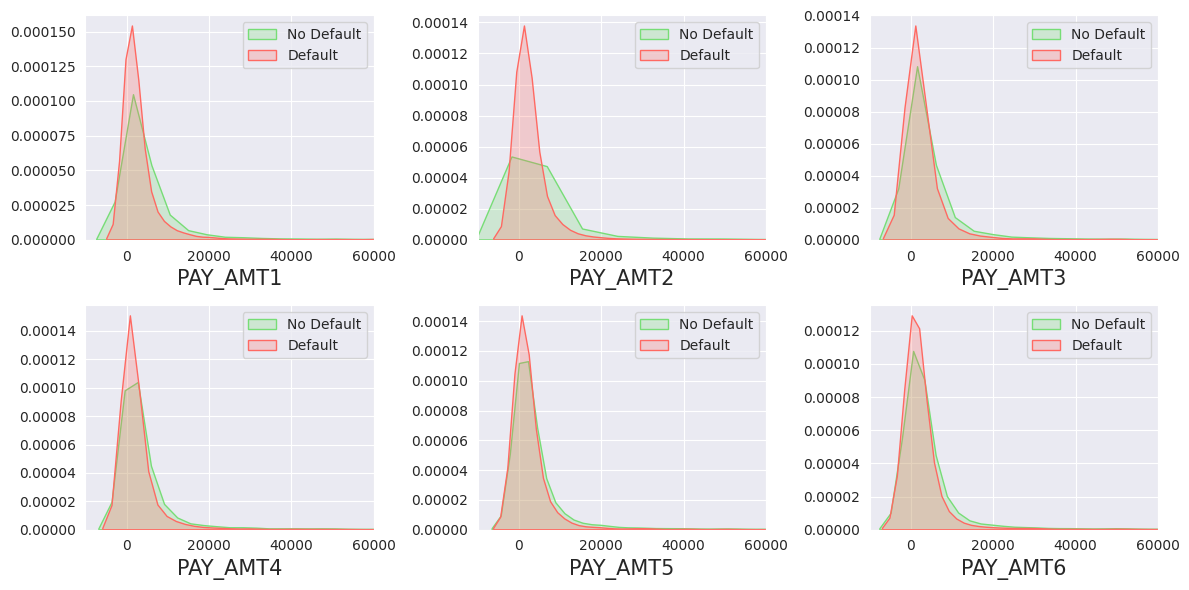

In [29]:
PAY_AMT_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] # 定义包含PAY_AMT列名的列表
plt.figure(figsize=(12,6)) # 创建一个指定大小的图形

for i,col in enumerate(PAY_AMT_cols): # 遍历PAY_AMT列名列表，并获取索引和列名
    plt.subplot(2,3,i + 1) # 创建子图，2行3列，当前子图索引为i+1
    sns.kdeplot(df.loc[(df['DEFAULT'] == 0), col], label = 'No Default', shade = True,color='#77DD76') # 绘制未违约客户的当前列核密度图，填充阴影
    sns.kdeplot(df.loc[(df['DEFAULT'] == 1), col], label = 'Default', shade = True, color='#FF6962') # 绘制违约客户的当前列核密度图，填充阴影
    plt.xlim(-10000,60000) # 设置x轴的范围
    plt.xlabel(col,fontsize=15) # 设置x轴标签，字体大小为15
    plt.ylabel('') # 清空y轴标签
    plt.legend() # 显示图例
    plt.tight_layout() # 调整子图布局，避免重叠

plt.savefig('images/continuousPAYAMT.svg') # 保存图形为SVG文件
plt.show() # 显示图形

付款状态特征集通过箱线图显示如下。可以看出，延迟付款一个月或更少的客户，其信用卡违约情况较少。特别是，9月份的还款状态，即 `PAY_1`，比其他月份的还款状态具有更大的区分能力。


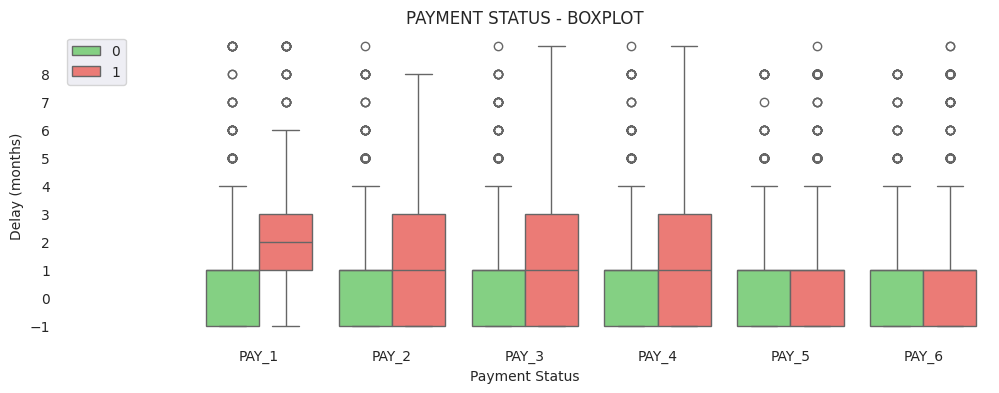

In [30]:
repayment = df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT']] # 选择PAY_1到PAY_6和DEFAULT列
repayment = pd.melt(repayment, # 使用melt函数将宽格式数据转换为长格式数据
                    id_vars="DEFAULT", # 设置DEFAULT列为标识变量
                    var_name="Payment Status", # 设置变量名列名为Payment Status
                    value_name='Delay (months)') # 设置值列名为Delay (months)

plt.figure(figsize=(12,4)) # 创建一个指定大小的图形
sns.boxplot(y="Delay (months)", x="Payment Status", hue="DEFAULT", data=repayment, palette=sns.color_palette(('#77DD76','#FF6962'))) # 绘制箱线图，y轴为Delay (months)，x轴为Payment Status，按DEFAULT分组，并指定调色板
plt.xlim([-1.5,5.5]) # 设置x轴的范围
plt.ylim([-1.5,9.5]) # 设置y轴的范围
plt.yticks(np.arange(-1,9)) # 设置y轴的刻度
plt.title('PAYMENT STATUS - BOXPLOT') # 设置图表标题
plt.legend() # 显示图例
plt.savefig('images/BoxplotPAY.svg') # 保存图形为SVG文件
plt.box(False) # 移除图形边框

## 2.4 特征之间的相关性

所考虑的数据集具有许多属性，并且强相关特征的存在可能导致某些分类算法的性能下降。实际上，有些方法假设预测变量的独立性，并受益于降维。

皮尔逊相关系数 $\rho$ 帮助我们找出两个变量之间的关系，衡量它们之间关联的强度。它被计算为两个特征 $X$ 和 $Y$ 之间的协方差（分子）除以它们的标准差的乘积（分母）：

$$\rho_{X,Y}=\frac{\text{Cov}(X,Y)}{\sigma_X\sigma_Y} \tag{2.1}$$

皮尔逊相关系数的值可以在 $-1$ 和 $+1$ 之间。

- $+1$ 表示它们高度相关，
- $0$ 表示没有相关性，
- $-1$ 表示存在负相关（反比关系）。

请注意，皮尔逊相关系数只能捕获线性趋势，因此对于强非线性相关的变量（例如，二次趋势），它可能会导致值为 $0$。

下面我们只显示数值特征之间相关矩阵的下半部分（不包括对角线）。


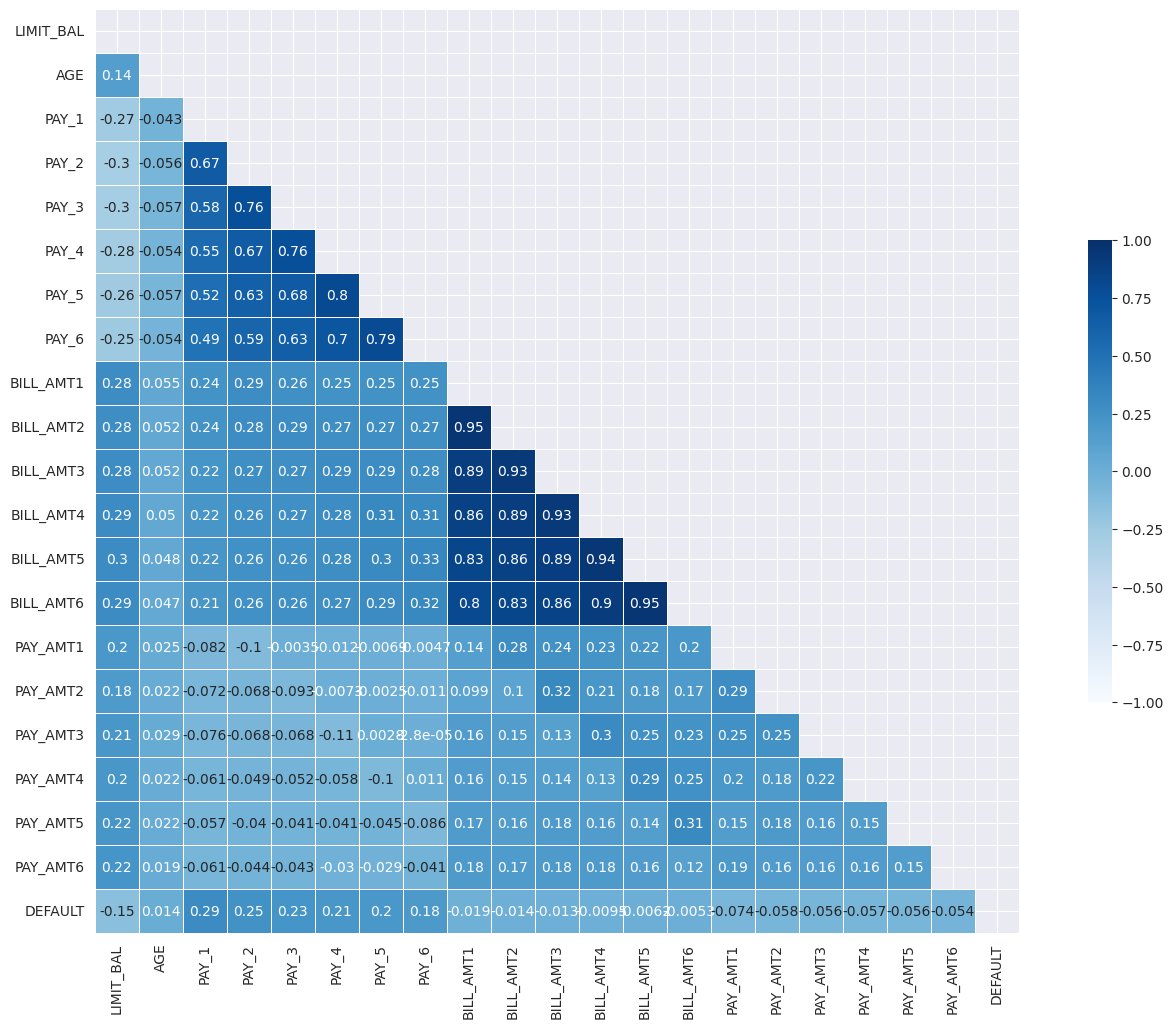

In [31]:
numeric = ['LIMIT_BAL','AGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6', 'DEFAULT'] # 定义数值型列名列表
corr = df[numeric].corr() # 计算数值型列的相关系数矩阵

mask = np.triu(np.ones_like(corr, dtype=bool)) # 创建一个上三角矩阵的掩码，用于隐藏上三角部分
f, ax = plt.subplots(figsize=(18,12)) # 创建一个指定大小的图形
ax = sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cmap='Blues', cbar_kws={'shrink': .5}, annot=True, annot_kws={'size': 10}) # 绘制热力图，使用掩码隐藏上三角，设置颜色映射、颜色条等
cbar = ax.collections[0].colorbar # 获取颜色条对象
plt.savefig('images/correlation.svg') # 保存图形为SVG文件

我们注意到 `BILL_AMTn` 特征之间存在很强的正相关性，这可能表明信息冗余。因此，我们报告这些变量的散点图以突出它们的相互作用。下面的矩阵包含每个变量组合的小散点图，这些散点图显示了所考虑的两个变量之间的数据点分布，并按两个类别分开。线性趋势证实了皮尔逊系数所暗示的，即 `BILL_AMTn` 特征编码了相当相似的信息。


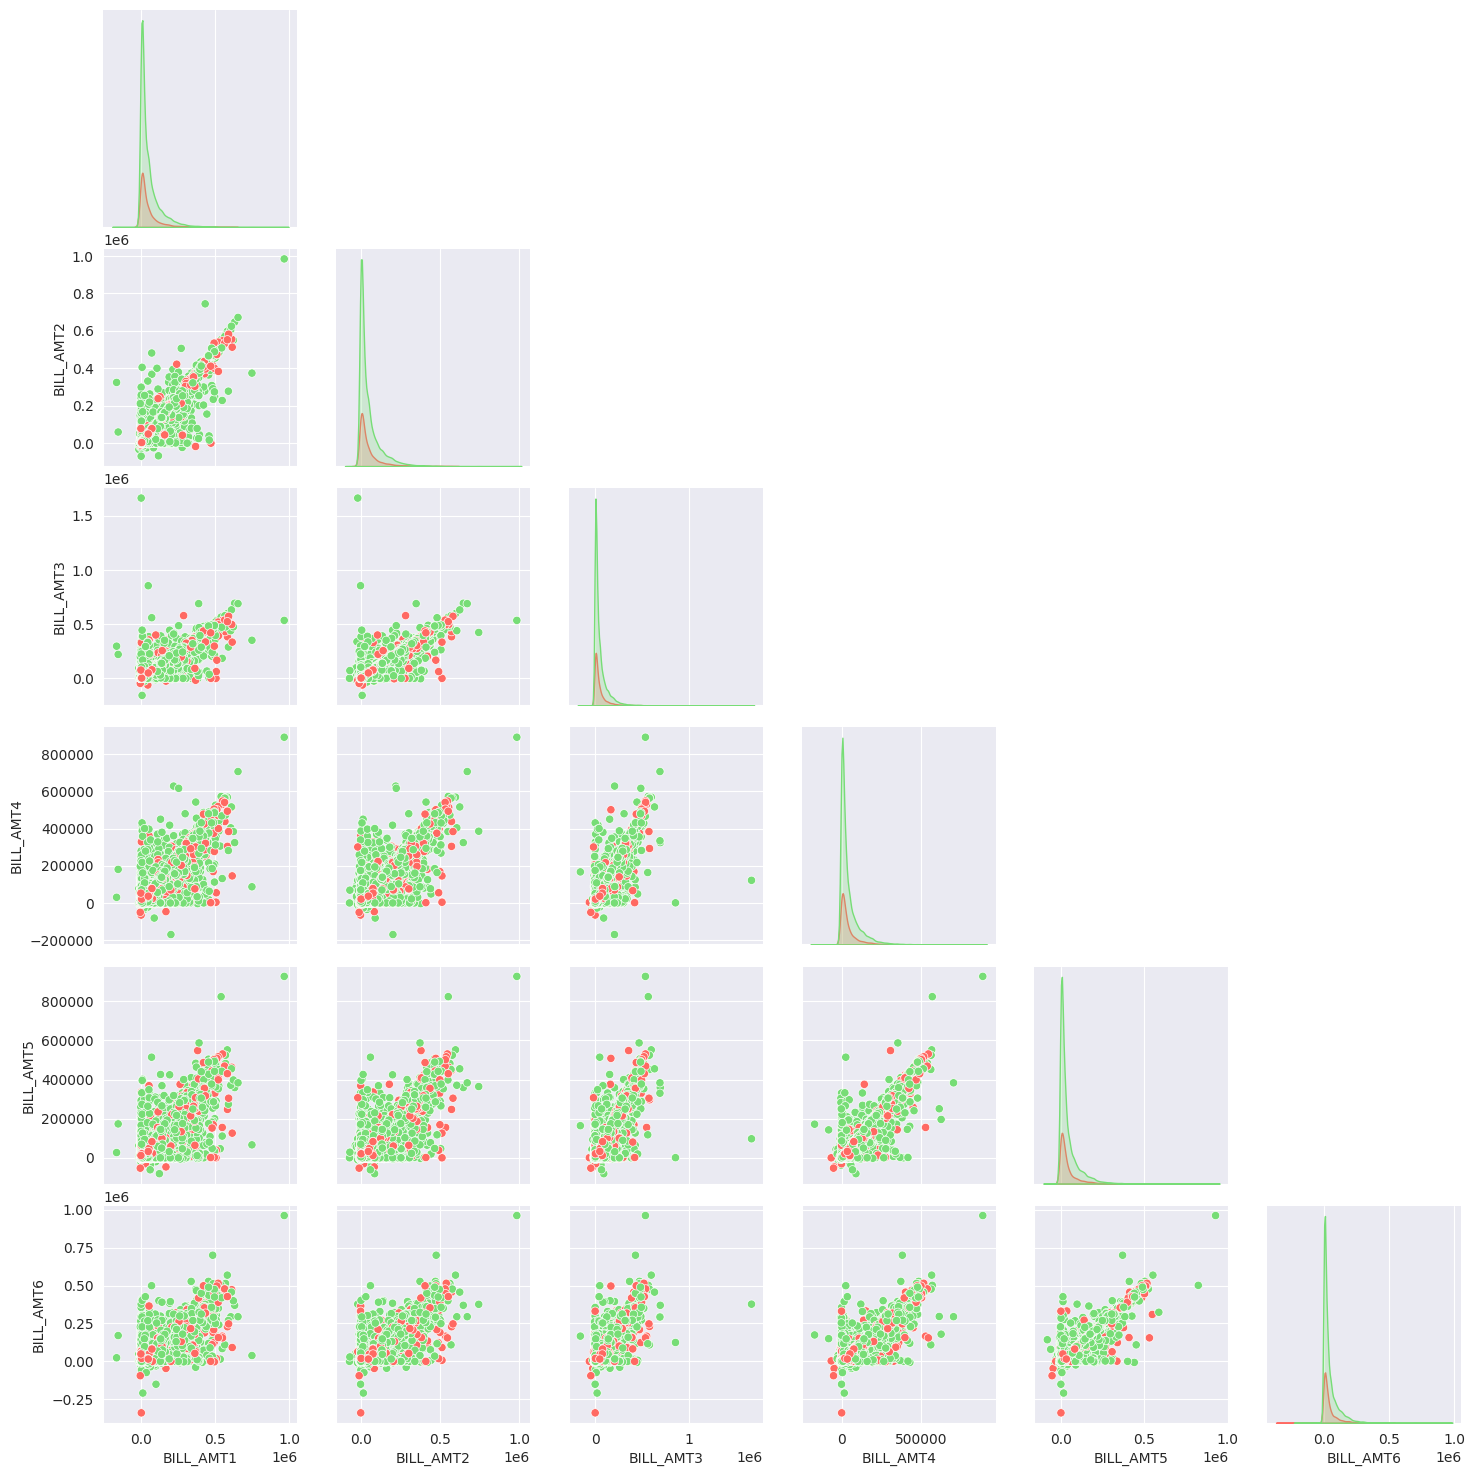

In [32]:
pair_plot = sns.pairplot(df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','DEFAULT']], hue='DEFAULT', diag_kind='kde', corner=True) # 绘制成对关系图，hue参数按DEFAULT列着色，对角线显示核密度估计，只显示下半部分
pair_plot._legend.remove() # 移除图例

## 2.5 正态性检验

参数统计方法假设数据具有已知且特定的分布，通常是高斯分布。如果我们在来自不同分布的数据上应用此类方法，我们的发现可能会产生误导或完全错误。为了检查我们的数据是否呈高斯分布，我们使用一种称为分位数-分位数（QQ）图的图形方法，该方法允许我们进行定性评估。在 QQ 图中，自变量的分位数与正态分布的预期分位数进行绘制。如果变量呈正态分布，则 QQ 图中的点应落在 45 度对角线上。

以下图表显示，没有证据表明数值特征呈正态分布。


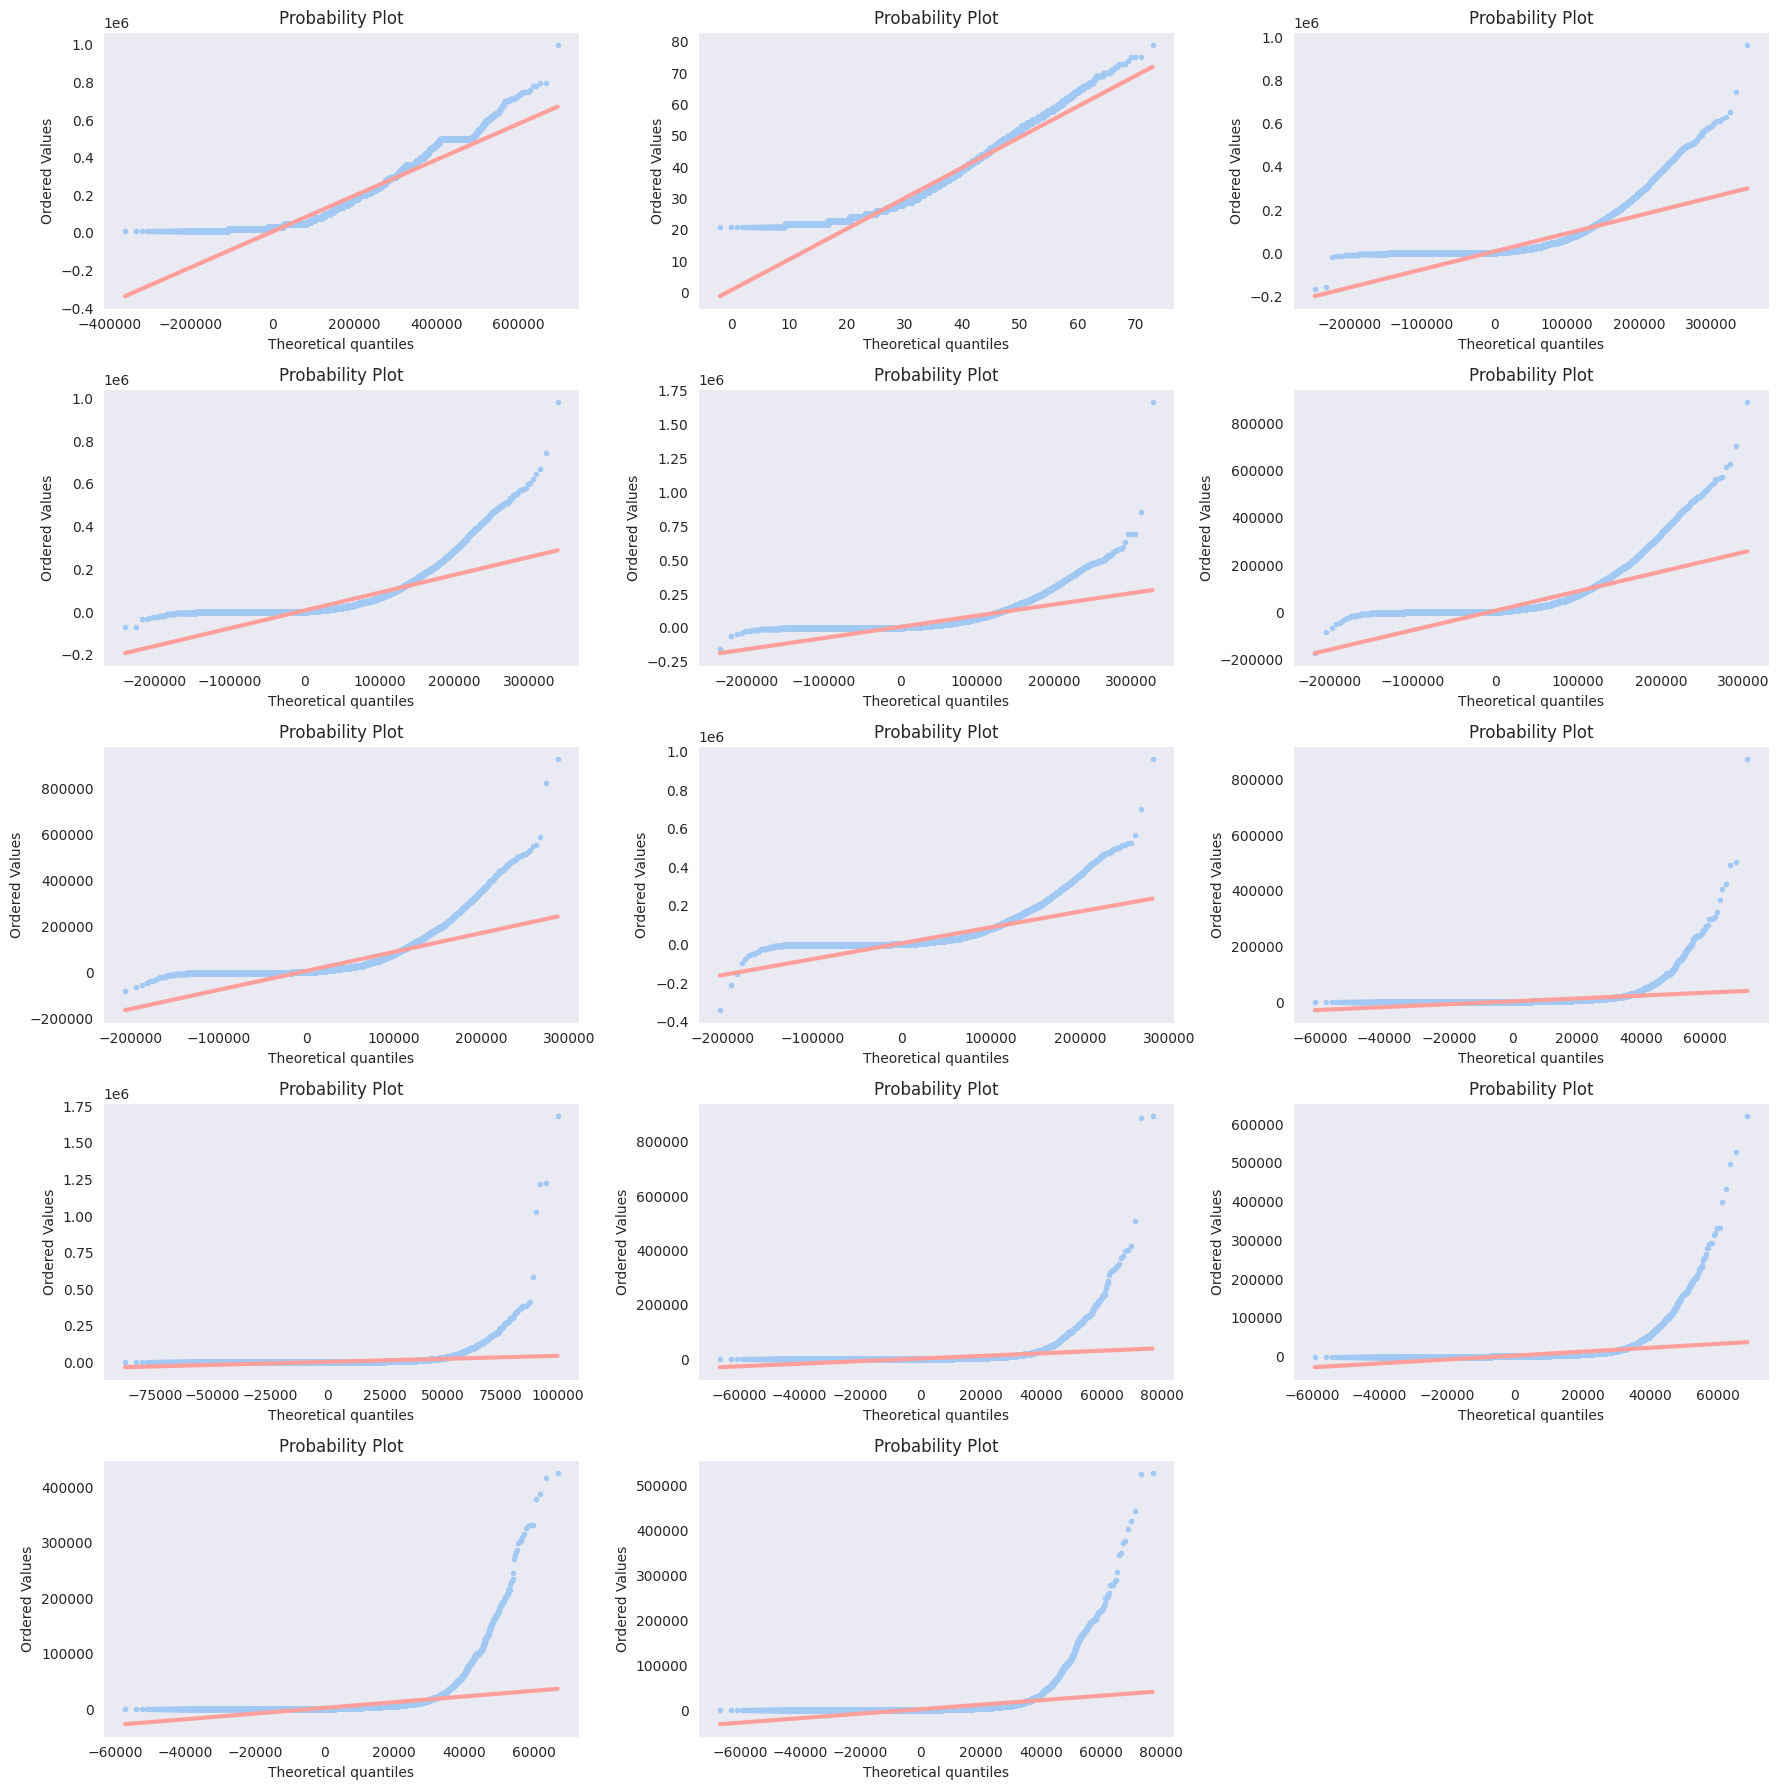

In [33]:
# 检查高斯分布
sns.set_color_codes('pastel') # 设置seaborn调色板为柔和色调
fig, axs = plt.subplots(5, 3, figsize=(18,18)) # 创建一个5行3列的子图网格，并设置图形大小

numeric = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6'] # 定义数值型列名列表
i, j = 0, 0 # 初始化行索引i和列索引j
for f in numeric: # 遍历数值型列名列表
    if j == 3: # 如果列索引达到3，则重置列索引并增加行索引
        j = 0
        i = i+1
    stats.probplot(df[f], # 绘制概率图
                    dist='norm', # 指定分布为正态分布
                    sparams=(df[f].mean(), df[f].std()), # 设置分布参数为均值和标准差
                    plot=axs[i,j]) # 指定子图进行绘制
    axs[i,j].get_lines()[0].set_marker('.') # 设置散点图标记为点

    axs[i,j].grid() # 开启子图网格
    axs[i,j].get_lines()[1].set_linewidth(3.0) # 设置拟合线宽度
    j = j+1 # 列索引加一

fig.tight_layout() # 调整子图布局，避免重叠
axs[4,2].set_visible(False) # 隐藏最后一个子图
plt.savefig('images/QQplot.png') # 保存图形为PNG文件
plt.show() # 显示图形

QQ 图（分位数-分位数图）的数学原理涉及统计学中的分位数概念，它通过比较样本数据的分位数与理论分布（通常是正态分布）的分位数来判断数据是否符合该理论分布。

以下是 QQ 图的数学公式和原理的详细解释：

**1. 分位数的概念**

* **样本分位数：** 对于一个有序的样本数据集，第 p 个分位数是指将数据集分为两部分的数值，其中一部分数据小于或等于该数值，另一部分数据大于该数值。
* **理论分位数：** 对于一个给定的理论分布（例如正态分布），第 p 个分位数是指在该分布中，累积概率为 p 的数值。

**2. QQ 图的构建**

QQ 图的构建主要包括以下步骤：

1.  **样本数据排序：** 将样本数据从小到大排序。
2.  **计算样本分位数：** 根据样本数据的大小和数量，计算样本数据的分位数。
3.  **计算理论分位数：** 根据选定的理论分布（例如正态分布）和样本数据的数量，计算理论分位数。
4.  **绘制散点图：** 将样本分位数作为 y 轴，理论分位数作为 x 轴，绘制散点图。

**3. QQ 图的数学公式**

虽然 QQ 图本身是一个图形工具，但其背后的数学原理与分位数的计算密切相关。

* **样本分位数的计算：**
对于有序样本数据 $x_1, x_2, ..., x_n$，第 p 个样本分位数可以使用以下公式计算：
    * $Q_p = x_{(k)}$，其中 $k = (n-1)p + 1$，如果 k 是整数；
    * $Q_p = x_{(\lfloor k \rfloor)} + (k - \lfloor k \rfloor))(x_{(\lfloor k \rfloor + 1)} - x_{(\lfloor k \rfloor)})$，如果 k 不是整数。
    * 其中 $\lfloor k \rfloor$ 表示 k 的向下取整。
* **理论分位数的计算：**
对于正态分布，第 p 个理论分位数可以使用正态分布的逆累积分布函数计算：
    * $Q_p = \mu + \sigma Z_p$。
    * 其中 $\mu$ 是均值，$\sigma$ 是标准差，$Z_p$ 是标准正态分布的第 p 个分位数。

**4. QQ 图的解读**

* **线性关系：** 如果样本数据符合理论分布，则 QQ 图中的点将大致沿着一条直线分布。
* **偏离线性关系：** 如果样本数据偏离理论分布，则 QQ 图中的点将偏离直线。
* **偏斜和峰度：** QQ 图还可以帮助我们判断数据的偏斜和峰度。
    * 例如，如果 QQ 图的尾部向上弯曲，则表明数据存在右偏斜；
    * 如果 QQ 图的尾部向下弯曲，则表明数据存在左偏斜。

**总结**

QQ 图通过比较样本分位数和理论分位数，帮助我们判断数据是否符合理论分布。虽然 QQ 图本身是一个图形工具，但其背后的数学原理与分位数的计算密切相关。


**右偏斜（正偏斜）通常意味着数据集中较大的数值（即右侧尾部）出现的频率更高，或者说较大的数值的样本量更多。**

为了更清晰地解释，我们来回顾一下右偏斜的几个关键点：

**1. 右偏斜的定义**

* 右偏斜的分布是指数据的尾部向右延伸，即数据集中存在较多的极端大值。
* 在右偏斜的分布中，平均值通常大于中位数。

**2. 右偏斜的直观理解**

* 想象一个收入分布：大部分人的收入处于较低水平，而少数人的收入非常高。这就形成了一个向右延伸的长尾。
* 在考试成绩中，如果大部分学生成绩较低，而少数学生成绩非常高，那么成绩的分布也会呈现右偏斜。

**3. QQ 图中的右偏斜**

* 在 QQ 图中，右偏斜表现为尾部向上弯曲。这意味着实际数据中较大的数值比正态分布预期出现的频率更高。

**因此，当我们在 QQ 图中看到尾部向上弯曲时，我们可以推断出数据集中较大的数值相对较多，或者说存在较多的极端大值。**

简单来说，右偏斜就是“大值多，尾巴长”。




**左偏斜（负偏斜）通常意味着数据集中较小的数值（即左侧尾部）出现的频率更高，或者说较小的数值的样本量更多。**

为了更清晰地解释，我们来回顾一下左偏斜的几个关键点：

**1. 左偏斜的定义**

* 左偏斜的分布是指数据的尾部向左延伸，即数据集中存在较多的极端小值。
* 在左偏斜的分布中，平均值通常小于中位数。

**2. 左偏斜的直观理解**

* 想象一个考试难度很高的考试成绩分布：大部分学生的成绩都比较高，而少数学生的成绩非常低。这就形成了一个向左延伸的长尾。
* 在产品的寿命测试中，如果大部分产品寿命都很长，而少数产品寿命很短，那么产品寿命的分布也会呈现左偏斜。

**3. QQ 图中的左偏斜**

* 在 QQ 图中，左偏斜表现为尾部向下弯曲。这意味着实际数据中较小的数值比正态分布预期出现的频率更高。

**因此，当我们在 QQ 图中看到尾部向下弯曲时，我们可以推断出数据集中较小的数值相对较多，或者说存在较多的极端小值。**

简单来说，左偏斜就是“小值多，尾巴长”。



## 3. 数据预处理

数据的质量和所包含的有用信息量是决定机器学习算法学习效果的关键因素。因此，在将数据集提供给学习算法之前，务必对其进行检查和预处理。

## 3.1 处理分类特征

分类特征 `EDUCATION`、`SEX` 和 `MARRIAGE` 已经用整数编码，可以直接提供给机器学习算法。然而，这些是名义特征，假设它们之间存在顺序关系是不合适的。**独热编码** 允许我们消除任何顺序关系，因为这些分类变量之间不存在有意义的顺序。这种方法背后的思想是为名义特征列中的每个唯一值创建一个新的虚拟特征。然后可以使用二进制值来指示示例的特定类别。

尽管 Scikit-Learn 提供了自动执行独热编码的方法，但我们决定手动映射特征，因为特征数量较少。这样，我们可以缓解*多重共线性*问题，当存在高度相关的特征时就会出现多重共线性。因此，我们创建以下布尔列并删除旧列 `EDUCATION`、`SEX` 和 `MARRIAGE`。

- `MALE`：1 = 男性；0 = 女性。
- `MARRIED`：1 = 已婚；0 = 其他。
- `GRAD_SCHOOL`：1 = 研究生学历；0 = 其他。
- `UNIVERSITY`：1 = 大学学历；0 = 其他。
- `HIGH_SCHOOL`：1 = 高中学历；0 = 其他。

请注意，删除特征列不会丢失任何重要信息。例如，我们删除了列 `EDUCATION=4`（其他），但特征信息仍然保留，因为如果我们观察到 `GRAD_SCHOOL=0`、`UNIVERSITY=0` 和 `HIGH_SCHOOL=0`，则意味着观察结果必须是 `OTHERS`。

In [34]:
df['GRAD_SCHOOL'] = (df['EDUCATION'] == 1).astype('category') # 创建GRAD_SCHOOL列，如果EDUCATION列为1，则为True，否则为False，并转换为category类型
df['UNIVERSITY'] = (df['EDUCATION'] == 2).astype('category') # 创建UNIVERSITY列，如果EDUCATION列为2，则为True，否则为False，并转换为category类型
df['HIGH_SCHOOL'] = (df['EDUCATION'] == 3).astype('category') # 创建HIGH_SCHOOL列，如果EDUCATION列为3，则为True，否则为False，并转换为category类型
df.drop('EDUCATION', axis=1, inplace=True) # 删除EDUCATION列

df['MALE'] = (df['SEX'] == 1).astype('category') # 创建MALE列，如果SEX列为1，则为True，否则为False，并转换为category类型
df.drop('SEX', axis=1, inplace=True) # 删除SEX列

df['MARRIED'] = (df['MARRIAGE'] == 1).astype('category') # 创建MARRIED列，如果MARRIAGE列为1，则为True，否则为False，并转换为category类型
df.drop('MARRIAGE', axis=1, inplace=True) # 删除MARRIAGE列

df.head() # 显示数据框的前几行

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,GRAD_SCHOOL,UNIVERSITY,HIGH_SCHOOL,MALE,MARRIED
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,3,3,-1,-1,-1,-1,3913,3102,...,0,0,0,0,1,False,True,False,False,True
2,120000,26,-1,3,1,1,1,3,2682,1725,...,1000,1000,0,2000,1,False,True,False,False,False
3,90000,34,1,1,1,1,1,1,29239,14027,...,1000,1000,1000,5000,0,False,True,False,False,False
4,50000,37,1,1,1,1,1,1,46990,48233,...,1200,1100,1069,1000,0,False,True,False,False,True
5,50000,57,-1,1,-1,1,1,1,8617,5670,...,10000,9000,689,679,0,False,True,False,True,True


## 3.2 数据集划分

为了评估我们将要使用的机器学习算法的泛化能力，我们将数据集按 3:1 的比例分为*训练集*和*测试集*。特别是，我们对目标变量 `DEFAULT` 应用分层，以确保训练集和测试集中的相对类别频率大致保持不变。我们设置 `random_state = 24` 以使实验可重复。

In [35]:
y = df['DEFAULT']
X = df.drop('DEFAULT', axis=1, inplace=False)

In [36]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y) # 使用train_test_split函数划分数据集，设置随机种子为24，并使用分层抽样（如果没有显式指定 test_size 或 train_size，train_test_split 函数会将数据集划分为 75% 的训练集和 25% 的测试集）

print('Training set shape: ', np.shape(X_train_raw)) # 打印训练集形状
print(f'- Defaulters:\t {len(y_train[y_train==1])}') # 打印训练集违约者数量
print(f'- Non-defaulters: {len(y_train[y_train==0])}') # 打印训练集非违约者数量
print('Test set shape: ', np.shape(X_test_raw)) # 打印测试集形状
print(f'- Defaulters:\t {len(y_test[y_test==1])}') # 打印测试集违约者数量
print(f'- Non-defaulters: {len(y_test[y_test==0])}') # 打印测试集非违约者数量



Training set shape:  (22200, 25)
- Defaulters:	 4954
- Non-defaulters: 17246
Test set shape:  (7401, 25)
- Defaulters:	 1651
- Non-defaulters: 5750


## 3.3 特征缩放

如果数值特征在同一尺度上，大多数机器学习和优化算法的表现会更好。决策树和随机森林是极少数不需要担心特征缩放的机器学习算法，因为它们是尺度不变的。

将不同特征缩放到同一尺度有两种常用方法：**归一化** 和 **标准化**。归一化是指将特征重新缩放到 $[0,1]$ 的范围内，这是 *最小-最大缩放* 的一个特例：

$$X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} \tag{3.1}$$

这里，$X$ 是一个特定的示例，$X_{min}$ 是特征列中的最小值，$X_{max}$ 是最大值。

使用标准化，我们将特征列以均值 $\mu=0$ 和标准差 $\sigma=1$ 为中心，使特征列具有与标准正态分布相同的参数，从而更容易学习权重。

$$Z=\frac{X-\mu}{\sigma} \tag{3.2}$$

为了提供公平的基准，我们在训练集上拟合统计量（归一化的最小-最大值，标准化的均值和标准差），然后根据它们转换训练集和测试集。

我们通过显示各自缩放数据的箱线图来比较这两种方法。请注意大量的*异常值*。我们不删除任何样本作为异常值，因为关于数据集的文献没有提供这方面的信息，并且我们缺乏关于该领域的知识。

虽然归一化抑制了异常值的影响，但标准化保留了有关异常值的信息。由于我们即将应用的技术对异常值的存在很敏感，我们决定继续使用归一化数据进行研究。


In [37]:
scaler = MinMaxScaler() # 创建MinMaxScaler对象，用于最小-最大缩放
X_train_norm = X_train_raw.copy() # 复制原始训练集数据
X_test_norm = X_test_raw.copy() # 复制原始测试集数据

X_train_norm['LIMIT_BAL'] = scaler.fit_transform(X_train_raw['LIMIT_BAL'].values.reshape(-1, 1)) # 在训练集的LIMIT_BAL列上拟合并转换数据
X_test_norm['LIMIT_BAL'] = scaler.transform(X_test_raw['LIMIT_BAL'].values.reshape(-1, 1)) # 在测试集的LIMIT_BAL列上应用转换
X_train_norm['AGE'] = scaler.fit_transform(X_train_raw['AGE'].values.reshape(-1, 1)) # 在训练集的AGE列上拟合并转换数据
X_test_norm['AGE'] = scaler.transform(X_test_raw['AGE'].values.reshape(-1, 1)) # 在测试集的AGE列上应用转换
for i in range(1,7): # 遍历PAY_1到PAY_6、BILL_AMT1到BILL_AMT6、PAY_AMT1到PAY_AMT6列
    X_train_norm['PAY_' + str(i)] = scaler.fit_transform(X_train_raw['PAY_' + str(i)].values.reshape(-1, 1)) # 在训练集的PAY_i列上拟合并转换数据
    X_test_norm['PAY_' + str(i)] = scaler.transform(X_test_raw['PAY_' + str(i)].values.reshape(-1, 1)) # 在测试集的PAY_i列上应用转换
    X_train_norm['BILL_AMT' + str(i)] = scaler.fit_transform(X_train_raw['BILL_AMT' + str(i)].values.reshape(-1, 1)) # 在训练集的BILL_AMT_i列上拟合并转换数据
    X_test_norm['BILL_AMT' + str(i)] = scaler.transform(X_test_raw['BILL_AMT' + str(i)].values.reshape(-1, 1)) # 在测试集的BILL_AMT_i列上应用转换
    X_train_norm['PAY_AMT' + str(i)] = scaler.fit_transform(X_train_raw['PAY_AMT' + str(i)].values.reshape(-1, 1)) # 在训练集的PAY_AMT_i列上拟合并转换数据
    X_test_norm['PAY_AMT' + str(i)] = scaler.transform(X_test_raw['PAY_AMT' + str(i)].values.reshape(-1, 1)) # 在测试集的PAY_AMT_i列上应用转换

In [38]:
scaler = StandardScaler() # 创建StandardScaler对象，用于标准化
X_train_std = X_train_raw.copy() # 复制原始训练集数据
X_test_std = X_test_raw.copy() # 复制原始测试集数据

X_train_std['LIMIT_BAL'] = scaler.fit_transform(X_train_raw['LIMIT_BAL'].values.reshape(-1, 1)) # 在训练集的LIMIT_BAL列上拟合并转换数据
X_test_std['LIMIT_BAL'] = scaler.transform(X_test_raw['LIMIT_BAL'].values.reshape(-1, 1)) # 在测试集的LIMIT_BAL列上应用转换
X_train_std['AGE'] = scaler.fit_transform(X_train_raw['AGE'].values.reshape(-1, 1)) # 在训练集的AGE列上拟合并转换数据
X_test_std['AGE'] = scaler.transform(X_test_raw['AGE'].values.reshape(-1, 1)) # 在测试集的AGE列上应用转换
for i in range(1,7): # 遍历PAY_1到PAY_6、BILL_AMT1到BILL_AMT6、PAY_AMT1到PAY_AMT6列
    X_train_std['PAY_' + str(i)] = scaler.fit_transform(X_train_raw['PAY_' + str(i)].values.reshape(-1, 1)) # 在训练集的PAY_i列上拟合并转换数据
    X_test_std['PAY_' + str(i)] = scaler.transform(X_test_raw['PAY_' + str(i)].values.reshape(-1, 1)) # 在测试集的PAY_i列上应用转换
    X_train_std['BILL_AMT' + str(i)] = scaler.fit_transform(X_train_raw['BILL_AMT' + str(i)].values.reshape(-1, 1)) # 在训练集的BILL_AMT_i列上拟合并转换数据
    X_test_std['BILL_AMT' + str(i)] = scaler.transform(X_test_raw['BILL_AMT' + str(i)].values.reshape(-1, 1)) # 在测试集的BILL_AMT_i列上应用转换
    X_train_std['PAY_AMT' + str(i)] = scaler.fit_transform(X_train_raw['PAY_AMT' + str(i)].values.reshape(-1, 1)) # 在训练集的PAY_AMT_i列上拟合并转换数据
    X_test_std['PAY_AMT' + str(i)] = scaler.transform(X_test_raw['PAY_AMT' + str(i)].values.reshape(-1, 1)) # 在测试集的PAY_AMT_i列上应用转换

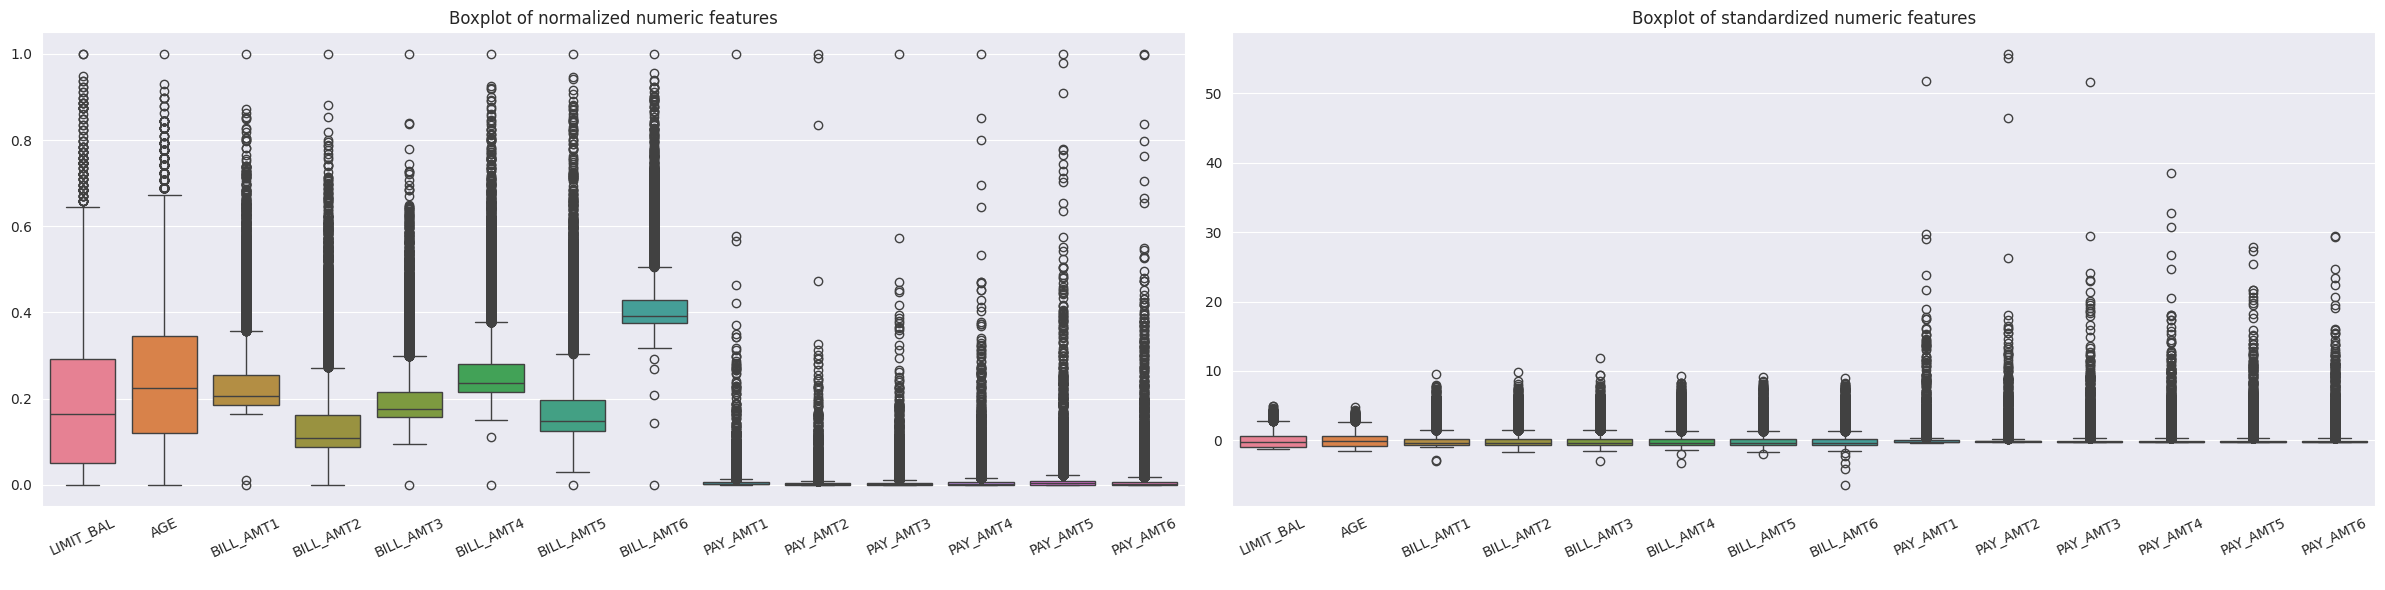

In [39]:
sns.set_color_codes('deep') # 设置seaborn调色板为深色调
numeric = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6'] # 定义数值型列名列表
fig, axs = plt.subplots(1, 2, figsize=(24,6)) # 创建一个1行2列的子图网格，并设置图形大小

sns.boxplot(data=X_train_norm[numeric], ax=axs[0]) # 绘制归一化数据的箱线图
axs[0].set_title('Boxplot of normalized numeric features') # 设置第一个子图的标题
axs[0].set_xticklabels(labels=numeric, rotation=25) # 设置第一个子图的x轴刻度标签，并旋转25度
axs[0].set_xlabel(' ') # 清空第一个子图的x轴标签

sns.boxplot(data=X_train_std[numeric], ax=axs[1]) # 绘制标准化数据的箱线图
axs[1].set_title('Boxplot of standardized numeric features') # 设置第二个子图的标题
axs[1].set_xticklabels(labels=numeric, rotation=25) # 设置第二个子图的x轴刻度标签，并旋转25度
axs[1].set_xlabel(' ') # 清空第二个子图的x轴标签

fig.tight_layout() # 调整子图布局，避免重叠
plt.savefig('images/normalized.svg') # 保存图形为SVG文件
plt.show() # 显示图形

标准化之所以保留了异常值的影响，并且通常比归一化影响更大，主要原因在于它们的计算方式和对数据分布的处理方式不同。以下是详细解释：

**1. 标准化的计算方式：**

* 标准化（Standardization）通过计算数据的均值（μ）和标准差（σ）来转换数据。
* 公式：Z = (X - μ) / σ
* 这意味着，标准化后的数据是以均值为中心，以标准差为单位进行度量的。
* 异常值通常会远离均值，因此在标准化后，它们仍然会保持较大的数值，从而保留了它们的影响。

**2. 归一化的计算方式：**

* 归一化（Normalization）通常指的是最小-最大缩放（Min-Max Scaling），它将数据缩放到一个特定的范围内（通常是 [0, 1]）。
* 公式：X_norm = (X - X_min) / (X_max - X_min)
* 这意味着，归一化后的数据被限制在一个固定的范围内，异常值会被压缩到这个范围内，从而减弱了它们的影响。

**3. 异常值的影响差异：**

* **标准化：**
    * 由于标准化基于均值和标准差，异常值会显著影响标准差的值，从而影响整个数据的缩放。
    * 异常值在标准化后仍然会保持较大的数值，因此它们的影响会被保留。
    * 在某些情况下，异常值甚至可能被放大，因为它们会拉大标准差，导致其他数据点更加集中。
* **归一化：**
    * 归一化基于数据的最小值和最大值，异常值会影响最大值或最小值，从而影响整个数据的缩放。
    * 但是，归一化将所有数据都压缩到一个固定的范围内，因此异常值的影响会被限制在这个范围内。
    * 相比之下，归一化对异常值的敏感度较低，它会减弱异常值的影响。

**4. 总结：**

* 标准化保留了数据的原始分布特征，因此异常值的影响会被保留，甚至可能被放大。
* 归一化将数据压缩到一个固定的范围内，因此异常值的影响会被减弱。
* 因此，标准化对异常值更加敏感，在数据存在较多异常值的时候，标准化后的数据，可能会存在数据分布不合理的情况。
* 在选择标准化还是归一化时，需要根据数据的具体情况和所使用的算法进行判断。如果数据存在较多异常值，并且算法对异常值敏感，那么归一化可能是一个更好的选择。


在归一化之前不直接剔除异常值，主要有以下几个原因：

**1. 异常值的定义和影响：**

* **异常值不一定是错误数据：**
    * 异常值可能是真实数据中的极端情况，包含着有价值的信息。例如，在信用卡欺诈检测中，异常高的交易额可能正是欺诈行为。
    * 直接删除异常值可能会丢失这些重要信息，导致模型性能下降。
* **异常值的影响取决于具体情况：**
    * 某些算法（如基于树的模型）对异常值不敏感，而另一些算法（如线性模型、神经网络）则容易受到异常值的影响。
    * 在决定是否剔除异常值之前，需要考虑所使用的算法以及异常值对模型性能的潜在影响。

**2. 归一化和异常值：**

* **归一化的作用：**
    * 归一化将数据缩放到一个固定的范围内（如 [0, 1]），有助于消除不同特征之间的量纲差异，提高模型训练的稳定性。
    * 归一化可以减弱异常值的影响，但不能完全消除。
* **为什么不先剔除：**
    * 在某些情况下，保留异常值并进行归一化可能比直接剔除异常值更好。
    * 归一化可以使异常值与其他数据点保持相对的比例关系，从而保留一些有用的信息。
    * 剔除异常值需要谨慎，因为这可能会引入偏差，影响模型的泛化能力。

**3. 领域知识的重要性：**

* **领域知识是判断异常值的关键：**
    * 在决定是否剔除异常值之前，需要充分了解数据的背景和领域知识。
    * 例如，在某些领域中，极端值是正常现象，不应该被剔除。
* **缺乏领域知识时的处理：**
    * 如果缺乏领域知识，可以考虑使用一些鲁棒的统计方法或机器学习算法，这些方法对异常值不敏感。
    * 在当前案例中，作者提到，他们缺乏关于该领域的知识，并且查阅的文献也没有关于如何处理异常值的信息，所以他们选择不处理。

**总结：**

* 剔除异常值需要谨慎，应该根据具体情况和领域知识进行判断。
* 归一化可以减弱异常值的影响，但不能完全消除。
* 在某些情况下，保留异常值并进行归一化可能比直接剔除异常值更好。
* 所以，在没有足够的证据证明异常值是错误数据，和没有足够的领域知识支持的情况下，作者没有选择提前删除异常值。


## 3.4 降维

正如我们提到的，许多算法都受益于移除强相关特征，以及通常的数据降维。 许多特征的存在会导致模型过于复杂，模型参数过于贴合训练集中的特定观测值，但无法很好地泛化到新数据。我们称这些模型具有*高方差*，并且*过拟合*训练集。

由于**维度诅咒**，过拟合问题在*K-means算法*中变得更加严重。 维度诅咒描述了这样一个现象：对于固定大小的训练数据集，随着维度的增加，特征空间变得越来越稀疏。 我们可以认为，在高维空间中，即使是最近的邻居也相距太远，无法给出良好的估计。

通过减少拟合数据所需的参数，可以获得更简单的模型。 除了降低计算成本和更好的可解释性之外，我们还获得了更好的泛化能力。 降维过程可以通过*特征选择*或*特征提取*来实现。 通过特征选择，我们选择原始特征的子集，而在特征提取中，我们从特征集中提取信息来构建新的特征子空间。 在降维的背景下，特征提取可以理解为一种数据压缩方法，其目标是保持大部分相关信息。

现在，我们可以手动丢弃之前发现的高度相关的特征。 然而，我们决定保留它们，以执行**主成分分析**（PCA），这是一种特征提取技术。

### 3.4.1 主成分分析概述

主成分分析（PCA）是一种无监督的线性变换技术，它可以帮助我们基于特征之间的相关性识别数据中的模式。 简而言之，PCA旨在找到高维数据中最大方差的方向，并将数据投影到维度等于或小于原始维度的新子空间上。 新子空间的垂直轴（主成分）可以解释为最大方差的方向，前提是新的特征轴彼此垂直。

### 3.4.2 PCA 推导
主成分分析（PCA）的推导涉及一些线性代数和矩阵运算。以下是对 PCA 推导的详细解释：

**1. 问题设定：**

* 假设我们有一个数据集，其中包含 m 个样本，每个样本都是一个 d 维向量。
* 我们的目标是将这些数据从 d 维降到 n 维（n < d），同时尽可能保留原始数据的方差。

**2. 核心思想：**

* PCA 的核心思想是找到一组新的正交基，使得数据在新基上的投影具有最大的方差。
* 这些新的正交基被称为主成分。

**3. 数学推导：**

* **数据中心化：**
    * 首先，我们需要对数据进行中心化，即减去每个特征的均值。这确保了主成分的方向不受数据均值的影响。
* **协方差矩阵：**
    * 计算中心化后数据的协方差矩阵。协方差矩阵描述了数据各个维度之间的相关性。
* **特征值分解：**
    * 对协方差矩阵进行特征值分解。特征值分解将协方差矩阵分解为特征向量和特征值的乘积。
    * 特征向量是主成分的方向，特征值表示对应主成分上的方差。
* **选择主成分：**
    * 将特征值从大到小排序，选择前 n 个最大的特征值对应的特征向量。
    * 这些选定的特征向量构成了新的 n 维空间的基。
* **数据投影：**
    * 将原始数据投影到新的 n 维空间中。这通过将原始数据与选定的特征向量相乘来实现。

**4. 数学公式：**

* **协方差矩阵：**
    * $\hat{\Sigma}=\frac{1}{m-1}A$
* **特征值分解：**
    * $A=VDV^\top$
    * D 是对角矩阵，对角线元素为特征值。
    * V 是特征向量矩阵，列向量为特征向量。
* **数据投影：**
    * $Y = XW$
    * X 是原始数据矩阵。
    * W 是由选定的特征向量组成的矩阵。
    * Y 是投影后的数据矩阵。

**5. 目标优化：**

* PCA 的目标是最大化投影后数据的方差。
* 这可以通过最大化以下目标函数来实现：
$\underset{U\in\mathbb{R}^{d,n}: U^\top U=\mathbb{I}_n}{\operatorname{argmax}}{\operatorname{tr}{\Bigg( U^\top \sum_{i=1}^{m}{\mathbf{x}_i\mathbf{x}_i^\top}U\Bigg)}}$

**总结：**

PCA 通过找到数据中方差最大的方向（主成分），并将数据投影到这些方向上，从而实现降维。这个过程涉及数据中心化、协方差矩阵计算、特征值分解和数据投影等步骤。


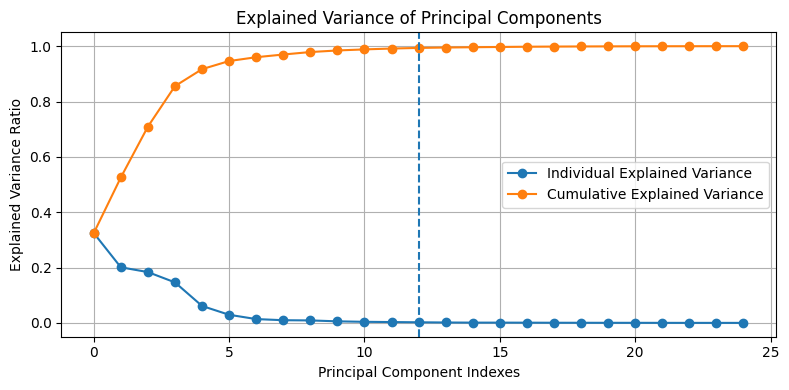

In [40]:
pc = len(X_train_norm.columns.values) #number columns = 25 # 获取训练集归一化后数据的列数，即特征数量，赋值给pc
pca = PCA(n_components=pc) # 创建PCA对象，设置主成分数量为pc
pca.fit(X_train_norm) # 在训练集归一化数据上拟合PCA模型

sns.reset_orig() # 重置seaborn的原始设置
sns.set_color_codes('pastel') # 设置seaborn调色板为柔和色调
plt.figure(figsize = (8,4)) # 创建一个图形，设置大小为8x4英寸
plt.grid() # 开启网格
plt.title('Explained Variance of Principal Components') # 设置图形标题
plt.plot(pca.explained_variance_ratio_, marker='o') # 绘制每个主成分的解释方差比，使用圆圈标记
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o') # 绘制累积解释方差比，使用圆圈标记
plt.legend(["Individual Explained Variance", "Cumulative Explained Variance"]) # 添加图例
plt.xlabel('Principal Component Indexes') # 设置x轴标签
plt.ylabel('Explained Variance Ratio') # 设置y轴标签
plt.savefig("images/PCACumulative.svg") # 保存图形为SVG文件
plt.tight_layout() # 调整图形布局，避免重叠
plt.axvline(12, 0, ls='--') # 绘制一条垂直虚线，位置在x=12
plt.show() # 显示图形

In [41]:
cumsum = np.cumsum(pca.explained_variance_ratio_) # 计算累积解释方差比
indexes = ['PC' + str(i) for i in range(1, pc+1)] # 创建主成分索引列表，如['PC1', 'PC2', ...]
cumsum_df = pd.DataFrame(data=cumsum, index=indexes, columns=['var1']) # 创建DataFrame，存储累积解释方差比
cumsum_df['var2'] = pd.Series([round(val, 4) for val in cumsum_df['var1']], index = cumsum_df.index) # 将var1列的数值四舍五入到小数点后4位，并存储在var2列
cumsum_df['Cumulative Explained Variance'] = pd.Series(["{0:.2f}%".format(val * 100) for val in cumsum_df['var2']], index = cumsum_df.index) # 将var2列的数值转换为百分比格式，并存储在'Cumulative Explained Variance'列
cumsum_df = cumsum_df.drop(['var1','var2'], axis=1, inplace=False) # 删除'var1'和'var2'列
cumsum_df.T.iloc[:,:15] # 转置DataFrame，并显示前15列

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
Cumulative Explained Variance,32.46%,52.56%,70.93%,85.57%,91.69%,94.63%,96.01%,96.98%,97.88%,98.44%,98.84%,99.14%,99.36%,99.51%,99.61%


上面图表中显示的结果令人惊讶，因为使用前 5 个主成分就可以捕获超过 90% 的总方差。然而，在我们的研究中，我们选择考虑前 12 个主成分。这样，可以解释超过 99% 的方差，同时特征数量减少了一半。

为了避免嵌入来自测试集的信息并保持其未知性，我们仅在训练集上拟合 PCA 算法。此后，我们将测试数据投影到由通过计算训练集上的协方差矩阵而找到的前 12 个主成分生成的子空间上。

In [42]:
pc = 12 # 设置主成分数量为12
pca = PCA(n_components=pc) # 创建PCA对象，设置主成分数量为pc
pca.fit(X_train_norm) # 在归一化后的训练集上拟合PCA模型
X_train = pd.DataFrame(pca.transform(X_train_norm)) # 将归一化后的训练集数据转换为PCA后的数据，并创建DataFrame
X_test = pd.DataFrame(pca.transform(X_test_norm)) # 将归一化后的测试集数据转换为PCA后的数据，并创建DataFrame
X_train.columns = ['PC' + str(i) for i in range(1, pc+1)] # 设置训练集DataFrame的列名为'PC1', 'PC2', ..., 'PC12'
X_test.columns = ['PC' + str(i) for i in range(1, pc+1)] # 设置测试集DataFrame的列名为'PC1', 'PC2', ..., 'PC12'
X_train.head() # 显示训练集DataFrame的前几行

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,0.541856,-0.551393,-0.412480,0.122101,0.238448,0.715080,-0.118730,-0.217807,-0.089929,-0.010003,-0.012406,0.002596
1,0.499287,-0.532587,-0.456984,0.088489,-0.464270,0.046294,-0.005356,-0.012562,-0.043945,-0.027395,0.004628,-0.006394
2,-0.832777,-0.331479,-0.471075,-0.018672,0.173999,0.077012,-0.117121,-0.145521,0.023793,-0.052872,0.009305,0.071040
3,-0.863633,-0.282837,-0.492387,-0.059972,-0.293545,-0.108782,0.099432,-0.142524,-0.090122,-0.036494,0.002218,-0.010245
4,0.474527,-0.631709,0.548848,0.022170,-0.370284,0.012118,0.082537,-0.129728,0.140121,0.031074,0.067107,-0.071883


## 3.5 处理类别不平衡

我们展示了我们正在处理的数据集是不平衡的，因为*非违约者*示例的代表性过高。实际上，类别不平衡是处理现实世界数据时非常常见的问题。

In [43]:
class_count = [y_train[y_train == 0].count(), y_train[y_train == 1].count()] # 计算训练集中非违约者和违约者的数量
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number']) # 创建DataFrame，存储类别计数
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index) # 计算每个类别的比例，并存储在var2列
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index) # 将var2列的数值转换为百分比格式，并存储在Percentage列
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False) # 删除var2列
print('Training set class proportion') # 打印字符串
class_count_df # 显示DataFrame

Training set class proportion


,Number,Percentage
Non-defaulters,17246,77.68%
Defaulters,4954,22.32%


## 3.5 处理类别不平衡

在我们的例子中，我们只需预测所有示例中的多数类（非违约者），就可以在没有监督机器学习算法的帮助下实现近 80% 的准确率。因此，当我们在数据集上拟合分类器时，与其他模型进行比较时，关注准确率以外的其他指标是有意义的。

除了评估机器学习模型外，类别不平衡还会影响学习算法在模型拟合过程中的表现。由于机器学习算法通常优化一个奖励或成本函数，该函数是根据拟合过程中看到的训练样本计算得出的，因此决策规则可能会偏向多数类。

我们立即排除了收集更多数据的选项。在模型拟合过程中处理不平衡的类别比例的一种方法是，对少数类的错误预测分配更大的惩罚。其他流行的处理类别不平衡的策略包括对少数类进行上采样、对多数类进行下采样以及生成合成训练样本。不幸的是，没有一种普遍的最佳解决方案或技术可以在不同的问题领域中发挥最佳作用。因此，在实践中，建议在给定问题上尝试不同的策略，评估结果，并选择似乎最合适的技术。

我们决定排除简单的过采样（欠采样）方法，因为它们会随机复制（删除）来自少数类（多数类）的数据，直到达到所需的水平。一方面，随机欠采样不允许控制丢弃哪些信息，另一方面，随机过采样会导致过拟合，因为模型是在许多相同的数据上训练的。为了缓解这些问题，我们选择采用聚类质心法和合成少数类过采样技术 (SMOTE)。

### 3.5.1 聚类质心欠采样

我们的数据集在少数类中提供了足够的样本，允许我们执行欠采样。然而，使用欠采样的一个主要问题是，多数类中可能会丢失重要信息，这可能导致过于通用的规则。在开发信用卡违约预测模型时，这是不能承受的，尤其是对于违约样本。因此，为了克服这个问题，可以引入了聚类质心法。

聚类质心法的思想是用各自的聚类质心替换多数样本的聚类。K-means 算法拟合到数据，聚类数设置为等于少数类样本数。然后，来自聚类的大部分样本完全被来自 K-means 的聚类质心集取代。聚类质心包含多数类中最具代表性的变体，其中特征值将在中心可视化。

在下面的数据框中，我们展示了欠采样的结果。现在训练集是平衡的，*非违约者*的数量等于*违约者*的数量。

In [44]:
oversample = ClusterCentroids(random_state=24) # 创建ClusterCentroids对象，设置随机种子为24
X_train_cc, y_train_cc = oversample.fit_resample(X_train, y_train) # 使用ClusterCentroids对训练集进行欠采样

class_count = [y_train_cc[y_train_cc == 0].count(), y_train_cc[y_train_cc == 1].count()] # 计算欠采样后训练集中非违约者和违约者的数量
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number']) # 创建DataFrame，存储类别计数
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index) # 计算每个类别的比例，并存储在var2列
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index) # 将var2列的数值转换为百分比格式，并存储在Percentage列
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False) # 删除var2列
print('Training set class proportion after Cluster Centroid Undersampling') # 打印字符串
class_count_df # 显示DataFrame

# non-defaulters 4954
# defaulters 4954

Training set class proportion after Cluster Centroid Undersampling


,Number,Percentage
Non-defaulters,4954,50.00%
Defaulters,4954,50.00%


### 3.5.2 合成少数类过采样技术

合成少数类过采样技术（SMOTE），旨在避免随机过采样面临的过拟合风险。该技术不是简单地复制现有观测值，而是生成人工样本。这是通过线性插值随机选择的少数类观测值及其相邻的少数类观测值之一来实现的。更准确地说，SMOTE 执行三个步骤来生成合成样本。

1. 首先，它选择一个随机的少数类观测值 $\vec{a}$。
2. 在其 $k$ 个最近的少数类邻居中，选择实例 $\vec{b}$。
3. 最后，通过随机插值两个样本来创建一个新样本 $\vec{x}$：$\vec{x}=\vec{a}+w\times(\vec{b}-\vec{a})$，其中 $w$ 是 $[0,1]$ 中的随机权重。

在下面的数据框中，我们展示了 SMOTE 过采样的结果。现在训练集是平衡的，*违约者*的数量等于*非违约者*的数量。


In [45]:
oversample = SMOTE(random_state=24) # 创建SMOTE对象，设置随机种子为24
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train) # 使用SMOTE对训练集进行过采样

class_count = [y_train_smote[y_train_smote == 0].count(), y_train_smote[y_train_smote == 1].count()] # 计算过采样后训练集中非违约者和违约者的数量
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number']) # 创建DataFrame，存储类别计数
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index) # 计算每个类别的比例，并存储在var2列
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index) # 将var2列的数值转换为百分比格式，并存储在Percentage列
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False) # 删除var2列
print('Training set class proportion after SMOTE Oversampling') # 打印字符串
class_count_df # 显示DataFrame

# non-defaulters 17246
# defaulters 17246

Training set class proportion after SMOTE Oversampling


,Number,Percentage
Non-defaulters,17246,50.00%
Defaulters,17246,50.00%


### 3.5.3 K-means SMOTE

该方法结合了简单且流行的 K-means 聚类算法和 SMOTE 过采样，以重新平衡倾斜的数据集。它通过仅在安全区域（即由至少 50% 的少数类样本组成的区域）进行过采样，成功地避免了噪声的产生。此外，它的重点放在类间不平衡和类内不平衡上，通过膨胀稀疏的少数类区域来解决小分离问题。

K-means SMOTE 由三个步骤组成：聚类、过滤和过采样。

1. 在聚类步骤中，使用 K-means 聚类将输入空间聚类成 $k$ 个组。
2. 过滤步骤选择用于过采样的聚类，保留少数类样本比例较高的聚类。然后，它分配要生成的合成样本的数量，向少数样本稀疏分布的聚类分配更多样本。
3. 最后，在过采样步骤中，在每个选定的聚类中应用 SMOTE，以实现少数类和多数类实例的目标比率。

在下面的数据框中，我们展示了 K-means SMOTE 过采样的结果。现在训练集是平衡的，*违约者*的数量等于*非违约者*的数量。


In [46]:
oversample = KMeansSMOTE(cluster_balance_threshold=0.00001, random_state=24) # 创建KMeansSMOTE对象，设置聚类平衡阈值为0.00001，随机种子为24
X_train_ksmote, y_train_ksmote = oversample.fit_resample(X_train, y_train) # 使用KMeansSMOTE对训练集进行过采样

class_count = [y_train_ksmote[y_train_ksmote == 0].count(), y_train_ksmote[y_train_ksmote == 1].count()] # 计算过采样后训练集中非违约者和违约者的数量
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number']) # 创建DataFrame，存储类别计数
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index) # 计算每个类别的比例，并存储在var2列
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index) # 将var2列的数值转换为百分比格式，并存储在Percentage列
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False) # 删除var2列
print('Training set class proportion after K-means SMOTE Oversampling') # 打印字符串
class_count_df # 显示DataFrame


Training set class proportion after K-means SMOTE Oversampling


,Number,Percentage
Non-defaulters,17246,49.99%
Defaulters,17252,50.01%


Training set class proportion after K-means SMOTE Oversampling


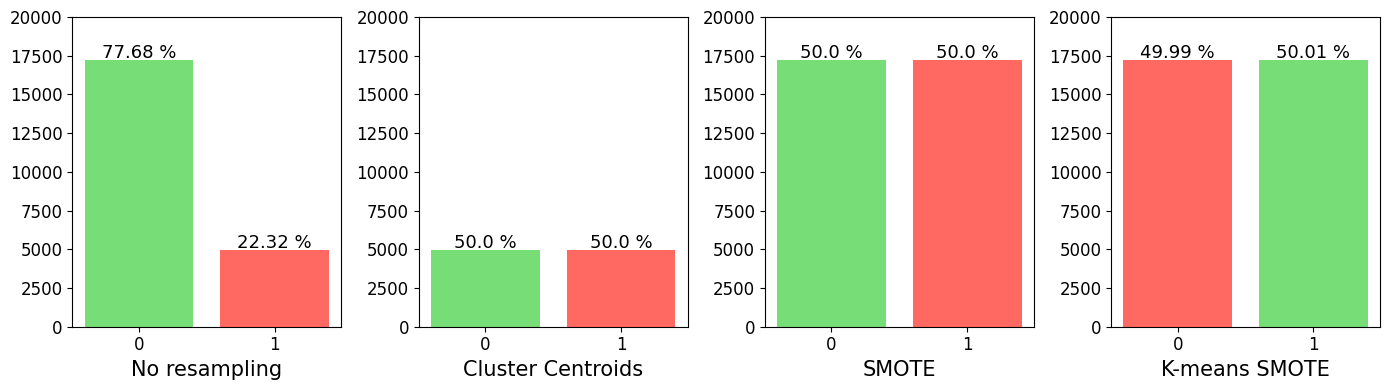

In [47]:
oversample = KMeansSMOTE(cluster_balance_threshold=0.00001, random_state=24) # 创建KMeansSMOTE对象，设置聚类平衡阈值为0.00001，随机种子为24
X_train_ksmote, y_train_ksmote = oversample.fit_resample(X_train, y_train) # 使用KMeansSMOTE对训练集进行过采样

class_count = [y_train_ksmote[y_train_ksmote == 0].count(), y_train_ksmote[y_train_ksmote == 1].count()] # 计算过采样后训练集中非违约者和违约者的数量
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number']) # 创建DataFrame，存储类别计数
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index) # 计算每个类别的比例，并存储在var2列
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index) # 将var2列的数值转换为百分比格式，并存储在Percentage列
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False) # 删除var2列
print('Training set class proportion after K-means SMOTE Oversampling') # 打印字符串
class_count_df # 显示DataFrame

y_list = [y_train, y_train_cc, y_train_smote, y_train_ksmote] # 创建包含不同重采样方法得到的y_train列表
y_list_labels = ['No resampling', 'Cluster Centroids', 'SMOTE', 'K-means SMOTE'] # 创建包含重采样方法标签的列表

plt.figure(figsize=(14, 4)) # 创建一个图形，设置大小为14x4英寸

i = 1 # 初始化子图索引
for value, label in zip(y_list, y_list_labels): # 遍历y_list和y_list_labels
    plt.subplot(1, 4, i) # 创建子图
    counts = value.value_counts() # 计算每个类别的数量
    bars = plt.bar(counts.index, counts.values, color=['#77DD76', '#FF6962']) # 绘制柱状图，使用指定的颜色
    plt.xlabel(label, fontdict={"size": 15}) # 设置x轴标签，字体大小为15
    plt.ylabel('') # 清空y轴标签
    plt.xticks(counts.index, fontsize=12) # 设置x轴刻度字体大小为12
    plt.yticks(fontsize=12) # 设置y轴刻度字体大小为12

    for bar in bars: # 遍历每个柱形图
        height = bar.get_height() # 获取柱形图的高度
        percentage = round(100 * height / len(value), 2) # 计算百分比，保留两位小数
        plt.text(bar.get_x() + bar.get_width() / 2., height + 100, f'{percentage} %', ha='center', fontsize=13) # 在柱形图上添加百分比文本，居中对齐，字体大小为13

    plt.ylim(0, 20000) # 设置y轴的上限
    i += 1 # 更新子图索引

plt.tight_layout() # 调整子图布局，避免重叠
plt.savefig('images/resamplingDataset.svg') # 保存图形为SVG文件
plt.show() # 显示图形

# 4. 模型评估方法

## 4.1 验证

构建机器学习模型的关键步骤之一是评估其在模型之前未见过的数据上的性能。因此，在上面，我们将初始数据集分为了独立的训练集和测试集。前者用于模型训练，后者用于评估其泛化性能。这种方法通常被称为 **留出法 (holdout)**。

然而，在典型的机器学习应用中，我们还对调整和比较不同的参数设置以进一步提高模型在未见过数据上的预测性能感兴趣。但是，如果在整个过程中重复使用同一个测试数据集，它将成为我们训练数据的一部分，从而导致模型更有可能过拟合。可以从训练集中留出一个验证集，用于评估模型的性能。然而，不建议这样做，因为性能评估可能对我们如何划分训练集很敏感。

### 4.1.1 K 折交叉验证

与留出法相比，**K 折交叉验证** 是一种更稳健的模型调优技术，我们在训练数据的 $k$ 个子集上重复 $k$ 次留出法。具体来说，我们将训练数据集随机划分为 $k$ 个不重复的折叠 (folds)，其中 $k-1$ 个折叠用于模型训练，一个折叠用于性能评估。然后，我们计算基于不同独立测试折叠的模型的平均性能，以获得性能估计，与留出法相比，该估计对训练数据的子划分不太敏感。

一旦我们找到了令人满意的超参数值，我们就可以在完整的训练数据集上重新训练模型，并使用独立的测试数据集获得最终的性能估计。在 k 折交叉验证后将模型拟合到整个训练数据集的基本原理是，为学习算法提供更多的训练样本通常会产生更准确、更稳健的模型。

由于 k 折交叉验证是一种不重复抽样的重采样技术，因此这种方法的优点是每个样本都将恰好一次用于训练和验证（作为测试折叠的一部分），这比留出法产生模型性能的较低方差估计。

在 k 折交叉验证中，$k$ 的一个良好的标准值是 $10$。然而，由于我们正在处理一个大型数据集，我们可以选择一个较小的 $k$ 值，例如 $k=5$，并且仍然获得模型平均性能的准确估计，同时减少在不同折叠上重新拟合和评估模型的计算成本。

和之前一样，应用分层抽样以确保每个折叠都代表训练数据集中类比例。

## 4.2 性能评估指标

分类评估指标比较每个观测的真实类别成员关系与分类器的预测。为了说明二元预测与真实分布的一致性，可以构建一个 **混淆矩阵**。

|             | 预测为负类 | 预测为正类 |
|:----------:|:-------------:|:-------------:|
| **实际为负类** |        TN      |        FP      |
| **实际为正类** |        FN      |        TP      |

在提及混淆矩阵中列出的计数时，经常使用以下术语：
- 真正例 (TP)，对应于分类模型正确预测的正例数量。
- 假反例 (FN)，对应于被分类模型错误预测为负例的正例数量。
- 假正例 (FP)，对应于被分类模型错误预测为正例的负例数量。
- 真反例 (TN)，对应于分类模型正确预测的负例数量。

预测 **准确率 (accuracy)** 是通常与机器学习算法相关的性能度量，定义为：

$$\text{准确率} = \frac{TP+TN}{TP+FP+TN+FN} \tag{1}$$

由于准确率度量将每个类别视为同等重要，因此它可能不适用于分析不平衡数据集，在不平衡数据集中，稀有类别被认为比多数类别更有趣。

**精确率 (precision)** 和 **召回率 (recall)** 是两种广泛使用的、特定于类别的度量，用于在其中一个类别的成功检测比另一个类别的检测更重要的应用中。

$$\text{精确率, }p = \frac{TP}{TP+FP} \tag{2}$$

$$\text{召回率, }r = \frac{TP}{TP+FN} \tag{3}$$

- 精确率表明有多少正例预测是正确的。精确率越高，分类器犯的假正例错误就越少。
- 召回率衡量有多少正例实例被正确分类为正例。召回率高的分类器很少将正例错误分类为负例。

构建一个能够最大化精确率和召回率的模型是分类算法的关键挑战。因此，这两个指标通常被总结为另一个指标，称为 F1 分数。

$$\text{F1 分数}=\frac{2}{\frac{1}{r}+\frac{1}{p}}=\frac{2rp}{r+p} \tag{4}$$

原则上，F1 代表召回率和精确率之间的调和平均值，并且趋向于更接近两者中较小的数字。因此，高 F1 分数确保精确率和召回率都相当高。

### 4.2.1 精确率-召回率曲线

在分类问题中，我们可能决定直接预测类别值，或者预测每个类别的概率。这样做的原因是能够选择甚至校准如何解释预测概率的 *阈值*。 例如，默认值可能是使用 $0.5$ 的阈值，这意味着 $[0.0, 0.49]$ 的概率是负面结果，$[0.5, 1.0]$ 的概率是正面结果。可以调整此阈值以针对特定问题调整模型的行为。一个例子是减少更多的一种或另一种类型的错误。

*精确率-召回率* (PR) 曲线是精确率（y 轴）和召回率（x 轴）针对不同阈值的图。我们使用它来探索良好分类的正例和错误分类的负例数量之间的权衡。

与 PR 曲线一起，我们还绘制了一条水平线，其值为数据集中正例案例的比例。它指示了 *无技能分类器* 的性能，即在所有情况下都预测随机类别的分类器。具有完美技能的模型表示为点 $(1,1)$。一个有技巧的模型用一条弯向 $(1,1)$ 且在无技能水平线之上的曲线表示。

此外，PR 曲线下的面积 (AUC) 是获得分类器总体性能评分并将其与其他分类器进行比较的好方法。注意到 PR 空间是一个单位正方形，可以清楚地看到分类器 $f$ 的 AUC 使得 $\operatorname{AUC}(f)\in[0,1]$，对于完美分类器（一个 $p=1$ 和 $r=1$ 的分类器），AUC 达到上限。

# 5. 分类模型

在本节中，我们将介绍不同的监督学习算法及其数学细节，并将它们应用于我们的数据集以构建一个分类模型，该模型能够预测下个月的信用卡违约情况。

## 5.1 逻辑回归

### 5.1.1 广义线性模型简介

广义线性模型 (GLM) 是一类广泛的模型，为许多常用的统计技术（例如线性回归）提供了统一的框架。它们的特点是以下三个组成部分。
- *随机分量* 识别响应变量 $Y$ 并假定其概率分布。标准 GLM 将 $Y$ 上的 $m$ 个观测值视为独立的，我们用 $(y_1,..., y_m)$ 表示这些观测值。
- *线性预测器* 指定了解释变量。这个名称反映了变量在线性地进入模型方程右侧作为预测变量，形式为
$$\beta_0+\beta_1 x_1+...+\beta_n x_n=\mathbf{x}^\top\mathbf{\beta}$$
- *链接函数* 指定了 GLM 将 $\mathbb{E}[Y]$ 的函数与线性预测器关联起来。

因此，在 GLM 中，给定特征向量 $\mathbf{x}=[x_1,...,x_n]^\top$ 的预期响应形式为

$$\mathbb{E}[Y|X=\mathbf{x}]=h(\mathbf{x}^\top\mathbf{\beta})\tag{1}$$

对于某个 *激活函数* $h$，它是链接函数的逆函数。

### 5.1.2 逻辑模型

在我们的例子中，响应 `DEFAULT` 属于两个类别之一，$\text{是}=1, \text{否}=0$，因此我们假设 $Y$ 服从伯努利分布。 *逻辑回归* 不是直接对响应 $Y$ 进行建模，而是使用 *逻辑函数* 作为激活函数 $h$ 对 $Y$ 属于特定类别的概率进行建模

$$P(Y_i=1|X=\mathbf{x}_i)=h(\mathbf{x}_i^\top\mathbf{\beta})=\frac{e^{\mathbf{x}_i^\top\mathbf{\beta}}}{1+e^{\mathbf{x}_i^\top\mathbf{\beta}}}\tag{2}$$

为了拟合模型，我们在下一节中使用 *最大似然* 方法。 $\mathbf{x}_i^\top\mathbf{\beta}$ 的较大值导致 $Y_i=1$ 的概率较高，而 $\mathbf{x}_i^\top\mathbf{\beta}$ 的较小值导致 $Y_i$ 以高概率为 $0$。 逻辑函数将始终产生如图所示的 S 形曲线，因此无论 $X$ 的值如何，我们都会获得合理的预测。

对其进行一些处理后，我们发现

$$\frac{P(Y_i=1|X=\mathbf{x}_i)}{1-P(Y_i=1|X=\mathbf{x}_i)}=e^{\mathbf{x}_i^\top\mathbf{\beta}}\tag{3}$$

其中左侧称为 *优势比 (odds)*，可以取 $0$ 到 $\infty$ 之间的任何值。 通过对其两边取对数，我们看到逻辑回归模型的 *logit* 在 $X$ 中是线性的。

$$\log{\Bigg(\frac{P(Y_i=1|X=\mathbf{x}_i)}{1-P(Y_i=1|X=\mathbf{x}_i)}\Bigg)}=\mathbf{x}_i^\top\mathbf{\beta}\tag{4}$$

### 5.1.3 估计回归系数

系数向量 $\mathbf{\beta}=[\beta_1,...,\beta_n]^\top$ 是未知的，必须根据可用的训练数据进行估计。我们使用最大似然法找到 $\hat{\beta}$，使得将此估计值代入上述模型，对于所有违约的个体，产生接近于 1 的值，而对于所有未违约的个体，产生接近于 0 的值。这种直觉可以使用 *似然函数* 来形式化：

$$\mathcal{L}(\mathbf{\beta})=\prod_{i=1}^{m}{[h(\mathbf{x}_i^\top\mathbf{\beta})]^{y_i}[1-h(\mathbf{x}_i^\top\mathbf{\beta})]^{1-y_i}}\tag{5}$$

最大化关于 $\mathbf{\beta}$ 的对数似然 $\log{\mathcal{L}(\mathbf{\beta})}$ 得到 $\mathbf{\beta}$ 的最大似然估计量。在监督学习框架中，这等价于最小化：

$$-\frac{1}{m}\log{\mathcal{L}(\mathbf{\beta})}=-\frac{1}{m}\sum_{i=1}^{m}{[y_i\log{h(\mathbf{x}_i^\top\mathbf{\beta})}+(1-y_i)\log{(1-h(\mathbf{x}_i^\top\mathbf{\beta}))}]}\tag{6}$$

请注意，我们可以将其解释为与比较真实条件概率密度函数 (pdf) 和近似 pdf 相关的 *二元交叉熵训练损失*。

就 $\mathbf{\beta}$ 而言，最小化实际上构成了一个 *凸* 优化问题，可以通过计算公式的梯度和 Hessian 矩阵，然后应用迭代过程（如牛顿法）来解决。

### 5.1.4 模型选择

在我们的研究中，我们使用了 *Scikit-learn* 库中提供的逻辑回归模型。在这里，默认情况下应用 $\mathscr{l}_2$ 正则化，这在机器学习中很常见，但在统计学中不常见。

$$\frac{\lambda}{2}\mathbf{\beta}^\top\mathbf{\beta}$$

在成本函数中添加正则化项允许我们调整模型的复杂度，因为它会在模型训练期间惩罚极端的权重值。通过正则化参数 $\lambda$，我们可以控制我们对训练数据的拟合程度，同时保持权重较小。通过增加 $\lambda$ 的值，我们增加了正则化强度。

Scikit-learn 中的 `LogisticRegression` 类将参数 `C` 实现为正则化项 $\lambda$ 的倒数。 因此，我们可以通过采用较小的 `C` 值来指定更强的正则化。

因此，我们对以下参数网格执行交叉验证的网格搜索，以找到最佳配置，以便我们的逻辑回归模型用于预测测试集。


```python
params = {'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}
```

In [48]:
# 绘制一个包含F1结果的条形图，以及使用最佳预处理技术的最佳估计器的混淆矩阵
def plot_summary(result, resampling_names, y_pred, y_test):

    fig = plt.figure(constrained_layout=False,figsize=(14,4)) # 创建一个图形，设置布局和大小
    gs1 = fig.add_gridspec(nrows=1, ncols=6, left=0.1, right=0.90, wspace=0.5, hspace=0.5) # 创建一个网格布局
    ax1 = fig.add_subplot(gs1[0,0:3]) # 在网格中添加一个子图（条形图）
    ax2 = fig.add_subplot(gs1[0,3:5]) # 在网格中添加另一个子图（混淆矩阵）

    plot_x = [] # 初始化x轴数据列表
    plot_y = [] # 初始化y轴数据列表

    for i in range(len(result)): # 遍历结果列表
        plot_x.append(result[i]) # 将结果添加到x轴数据列表
        plot_y.append(resampling_names[i]) # 将重采样名称添加到y轴数据列表

    temp_df = pd.DataFrame({'x':plot_x, 'y':plot_y}).sort_values(['x'], ascending=False) # 创建一个DataFrame并按x值降序排序

    sns.barplot(data=temp_df, x='x',y='y', # 绘制条形图
                palette='Greens_r', # 设置调色板
                ax=ax1) # 指定子图
    ax1.set_xlabel("F1-score", fontsize="14") # 设置x轴标签
    ax1.set_ylabel("") # 清空y轴标签
    ax1.set_yticklabels(temp_df.y,fontsize=13) # 设置y轴刻度标签

    cm = confusion_matrix(y_test, y_pred) # 计算混淆矩阵
    sns.heatmap(cm, annot = True, # 绘制热力图（混淆矩阵）
                cmap=plt.cm.Greens, # 设置颜色映射
                annot_kws={"size": 14}, # 设置注释字体大小
                linecolor = 'w', # 设置线条颜色
                linewidth = 4,ax=ax2, # 设置线条宽度和子图
                fmt='d' # 设置格式为整数
                )

    ax2.set_xlabel("Predicted labels",fontsize="14") # 设置x轴标签
    ax2.set_ylabel("True labels",fontsize="14") # 设置y轴标签

    return plt # 返回plt对象


def plot_test_scores(model, oversample, plot):

    if oversample == 'raw': # 如果重采样方法是'raw'
        X_test_s = X_test_norm.copy() # 使用归一化后的测试集副本
    else:
        X_test_s = X_test.copy() # 否则使用原始测试集副本

    y_pred = model.predict(X_test_s) # 使用模型进行预测

    test_acc = accuracy_score(y_test, y_pred) # 计算准确率
    test_precision = precision_score(y_test, y_pred) # 计算精确率
    test_recall = recall_score(y_test, y_pred) # 计算召回率
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred) # 计算精确率-召回率曲线
    test_auc = auc(recall, precision) # 计算AUC
    test_f1 = f1_score(y_test, y_pred) # 计算F1分数

    print("Test Scores:") # 打印测试分数
    print(f"- Accuracy:\t{test_acc}") # 打印准确率
    print(f"- Recall:\t{test_recall}") # 打印召回率
    print(f"- Precision:\t{test_precision}") # 打印精确率
    print(f"- F1-score:\t{test_f1}") # 打印F1分数
    print(f"- AUC:\t\t{test_auc}") # 打印AUC

    if plot: # 如果plot为True
        fig, axs = plt.subplots(1, 3, figsize=(15,4)) # 创建一个包含3个子图的图形

        tmp = pd.DataFrame({'Feature': X_test_s.columns, # 创建一个DataFrame存储特征重要性
                              'Feature importance': model.best_estimator_.feature_importances_})
        tmp = tmp.sort_values(by='Feature importance', ascending=False) # 按特征重要性降序排序
        s = sns.barplot(x='Feature', y='Feature importance', data=tmp, ax=axs[0]) # 绘制特征重要性条形图
        s.set_xticklabels(s.get_xticklabels(), rotation=90) # 设置x轴刻度标签旋转90度

        # 替换 plot_confusion_matrix
        ConfusionMatrixDisplay.from_estimator(model, X_test_s, y_test, cmap=plt.cm.Greens, normalize='true', ax=axs[1])
        axs[1].grid(False) # 禁用网格线，避免与热力图重叠

        no_skill = len(y_test[y_test==1]) / len(y_test) # 计算无技能水平

        # 替换 plot_precision_recall_curve
        PrecisionRecallDisplay.from_estimator(model, X_test_s, y_test, ax=axs[2])
        axs[2].axhline(no_skill, 0, ls='--', label='No Skill') # 绘制无技能水平线
        axs[2].set_ylim([-0.05, 1.05]) # 设置y轴范围
        axs[2].legend(loc = 'upper right') # 添加图例

        plt.show() # 显示图形
    else: # 如果plot为False
        fig, axs = plt.subplots(1, 2, figsize=(10,4)) # 创建一个包含2个子图的图形

        # 替换 plot_confusion_matrix
        ConfusionMatrixDisplay.from_estimator(model, X_test_s, y_test, cmap=plt.cm.Greens, normalize='true', ax=axs[0])
        axs[0].grid(False) # 禁用网格线，避免与热力图重叠

        no_skill = len(y_test[y_test==1]) / len(y_test) # 计算无技能水平

        # 替换 plot_precision_recall_curve
        PrecisionRecallDisplay.from_estimator(model, X_test_s, y_test, ax=axs[1])
        axs[1].axhline(no_skill, 0, ls='--', label='No Skill') # 绘制无技能水平线
        axs[1].set_ylim([-0.05, 1.05]) # 设置y轴范围
        axs[1].legend(loc = 'upper right') # 添加图例

        plt.show() # 显示图形

    return test_acc, test_recall, test_precision, test_f1, test_auc # 返回测试指标


def pipeline(model, params, oversample=None, plot=False):

    max_f1 = 0 # 初始化最大F1分数
    y_pred_max = 0 # 初始化最大F1分数对应的预测值
    y_test_max = 0 # 初始化最大F1分数对应的真实值

    if oversample: # 如果指定了重采样方法
        if oversample == 'raw': # 如果重采样方法是'raw'
            X_train_s = X_train_norm.copy() # 使用归一化后的训练集副本
            y_train_s = y_train.copy() # 使用原始训练集副本
            X_test_f1 = X_test_raw.copy() # 使用归一化后的原始测试集副本
        else:
            X_train_s, y_train_s = oversample.fit_resample(X_train, y_train) # 使用指定的重采样方法对训练集进行重采样
            X_test_f1 = X_test.copy() # 使用原始测试集副本
    else:
        X_train_s = X_train.copy() # 使用原始训练集副本
        y_train_s = y_train.copy() # 使用原始训练集副本
        X_test_f1 = X_test.copy() # 使用原始测试集副本

    gridsearch = GridSearchCV(estimator = model, # 创建GridSearchCV对象
                                param_grid = params, # 设置参数网格
                                scoring = 'f1', # 设置评分标准为F1
                                cv = 5, # 设置交叉验证折数为5
                                n_jobs = -1, # 设置使用所有CPU核心
                                verbose = True) # 设置verbose为True
    gridsearch.fit(X_train_s, y_train_s) # 使用网格搜索拟合模型
    print(f"Best parameters:\t{gridsearch.best_params_}") # 打印最佳参数
    print(f"Best validation score:\t{gridsearch.best_score_}") # 打印最佳验证分数

    test_scores = plot_test_scores(gridsearch, oversample, plot) # 绘制测试分数并获取测试指标

    best_estimator = gridsearch.best_estimator_ # 获取最佳估计器

    y_pred = best_estimator.predict(X_test_f1) # 使用最佳估计器进行预测
    f1 = round(f1_score(y_test, y_pred),2) # 计算F1分数，保留两位小数

    if f1 > max_f1: # 如果当前F1分数大于最大F1分数
        y_pred_max = y_pred # 更新最大F1分数对应的预测值
        y_test_max = y_test # 更新最大F1分数对应的真实值
        max_f1 = f1 # 更新最大F1分数

    return test_scores, y_pred_max, y_test_max # 返回测试指标、最大F1分数对应的预测值和真实值

In [49]:
oversample_method = ['raw', # 定义重采样方法列表，'raw'表示原始数据
                    None, # None表示不进行重采样，用于PCA
                    SMOTE(random_state=24), # SMOTE过采样，设置随机种子为24
                    KMeansSMOTE(cluster_balance_threshold=1e-5, random_state=24), # KMeansSMOTE过采样，设置聚类平衡阈值为1e-5，随机种子为24
                    ClusterCentroids(random_state=24)] # ClusterCentroids欠采样，设置随机种子为24
oversample_names = ['Raw data', # 定义重采样方法名称列表，'Raw data'对应原始数据
                    'PCA', # 'PCA'对应PCA降维
                    'PCA + SMOTE oversampling', # 'PCA + SMOTE oversampling'对应PCA降维后使用SMOTE过采样
                    'PCA + KMeansSMOTE oversampling', # 'PCA + KMeansSMOTE oversampling'对应PCA降维后使用KMeansSMOTE过采样
                    'PCA + ClusterCentroids oversampling'] # 'PCA + ClusterCentroids oversampling'对应PCA降维后使用ClusterCentroids欠采样
scores_lr = {'Accuracy' : [float for i in range(len(oversample_method))], # 初始化逻辑回归模型评估指标字典，'Accuracy'对应准确率
            'Recall' : [float for i in range(len(oversample_method))], # 'Recall'对应召回率
            'Precision' : [float for i in range(len(oversample_method))], # 'Precision'对应精确率
            'F1-score' : [float for i in range(len(oversample_method))], # 'F1-score'对应F1分数
            'AUC' : [float for i in range(len(oversample_method))],} # 'AUC'对应AUC值

Logistic Regression with Raw data
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 100.0}
Best validation score:	0.2814166145042351
Test Scores:
- Accuracy:	0.8047561140386434
- Recall:	0.1980617807389461
- Precision:	0.7299107142857143
- F1-score:	0.311576941400667
- AUC:		0.5534336194890901


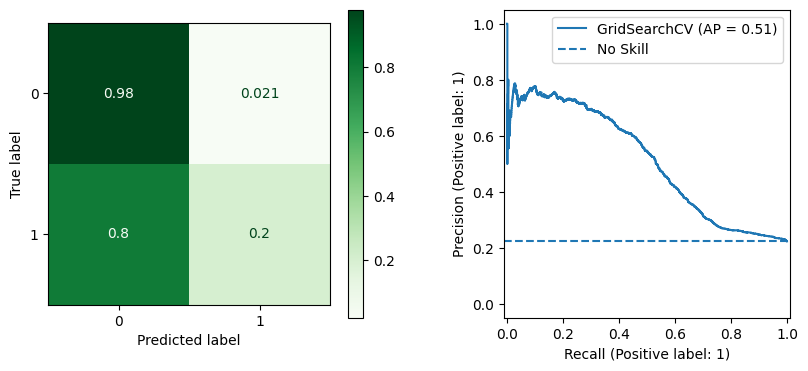

Logistic Regression with PCA
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 100.0}
Best validation score:	0.2772877735903764
Test Scores:
- Accuracy:	0.80435076341035
- Recall:	0.19200484554815264
- Precision:	0.7354988399071926
- F1-score:	0.3045148895292987
- AUC:		0.5538747990849215


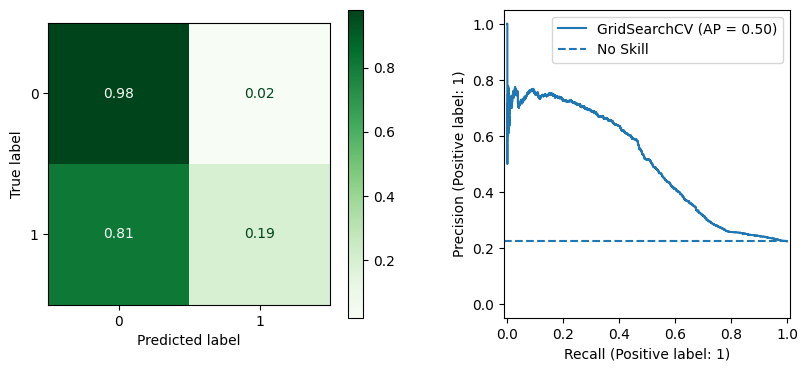

Logistic Regression with PCA + SMOTE oversampling
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 1.0}
Best validation score:	0.6628482727138281
Test Scores:
- Accuracy:	0.6318065126334279
- Recall:	0.6789824348879467
- Precision:	0.3380579010856454
- F1-score:	0.4513791020736863
- AUC:		0.5443261401527195


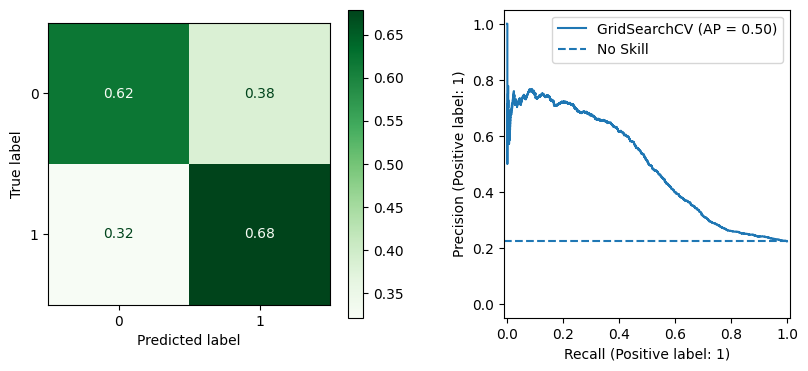

Logistic Regression with PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 1.0}
Best validation score:	0.7118249631505498
Test Scores:
- Accuracy:	0.7243615727604378
- Recall:	0.36220472440944884
- Precision:	0.3772870662460568
- F1-score:	0.3695920889987639
- AUC:		0.44088493059325745


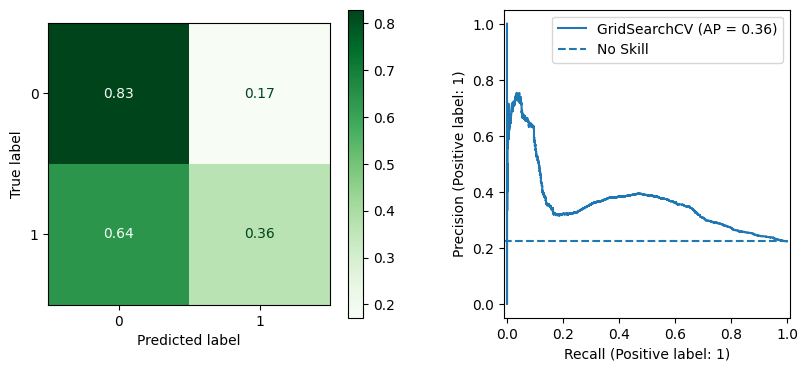

Logistic Regression with PCA + ClusterCentroids oversampling
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 1.0}
Best validation score:	0.6545943821065018
Test Scores:
- Accuracy:	0.597081475476287
- Recall:	0.6705027256208359
- Precision:	0.31227080394922424
- F1-score:	0.42609699769053117
- AUC:		0.5281385550836384


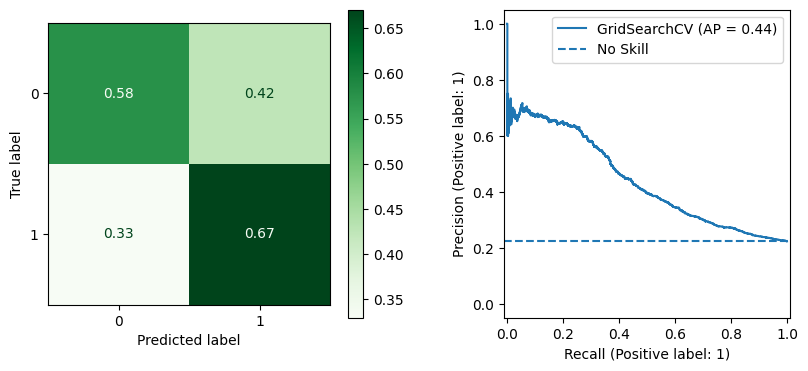

,Accuracy,Recall,Precision,F1-score,AUC
Raw data,0.804756,0.198062,0.729911,0.311577,0.553434
PCA,0.804351,0.192005,0.735499,0.304515,0.553875
PCA + SMOTE oversampling,0.631807,0.678982,0.338058,0.451379,0.544326
PCA + KMeansSMOTE oversampling,0.724362,0.362205,0.377287,0.369592,0.440885
PCA + ClusterCentroids oversampling,0.597081,0.670503,0.312271,0.426097,0.528139


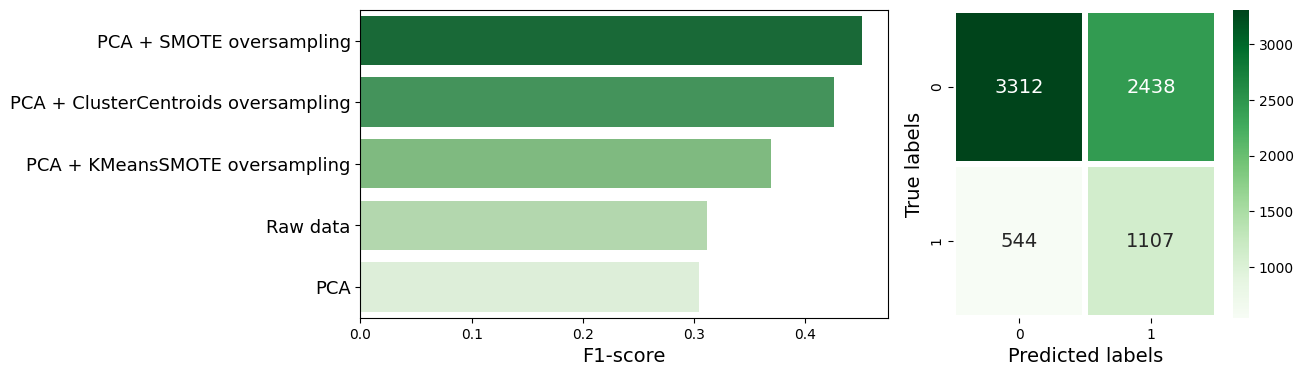

In [50]:
params_lr = {'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]} # 定义逻辑回归模型的参数网格
for idx, oversample in enumerate(oversample_method): # 遍历重采样方法列表
    print(f"Logistic Regression with {oversample_names[idx]}") # 打印当前使用的重采样方法名称
    scores, y_pred_max, y_test_max = pipeline(LogisticRegression(random_state=24, max_iter=1000, n_jobs=-1), # 调用pipeline函数训练逻辑回归模型
                                                                params_lr, # 传入参数网格
                                                                oversample) # 传入重采样方法
    scores_lr['Accuracy'][idx] = scores[0] # 将准确率保存到字典中
    scores_lr['Recall'][idx] = scores[1] # 将召回率保存到字典中
    scores_lr['Precision'][idx] = scores[2] # 将精确率保存到字典中
    scores_lr['F1-score'][idx] = scores[3] # 将F1分数保存到字典中
    scores_lr['AUC'][idx] = scores[4] # 将AUC值保存到字典中

scores_lr_df = pd.DataFrame(data=scores_lr, index=oversample_names) # 将评估指标字典转换为DataFrame
plot = plot_summary(scores_lr_df["F1-score"], oversample_names, y_pred_max, y_test_max) # 调用plot_summary函数绘制总结图
plot.savefig("images/summaryLogReg.svg") # 保存总结图
scores_lr_df # 显示评估指标DataFrame

上面的数据框总结了通过在训练集上拟合不同的预处理技术，在测试集上获得的逻辑回归结果。PCA 允许我们实现与使用所有数据相同的性能，但使用的特征数量减少了一半。请注意，不使用任何过采样方法会导致最高的准确率和 AUC，但会导致较低的 F1 分数。原始的 SMOTE 优于 Cluster Centroid 和新的 K-means SMOTE。

在图中，我们可以看到 PR 曲线开头有一个急剧下降。这是由于这样一个事实：阈值在那里特别高，因此 TP（真正例）和 FP（假正例）很少，甚至一个单一的错误分类都可能导致大的偏移。

以下是针对实验结果中 **F1-score** 和 **AUC** 的解读，以及不同预处理方法对模型性能的影响分析：

---

### **一、核心指标解读**
#### **1. F1-score：平衡精确率与召回率的综合指标**
• **定义**：F1-score 是精确率（Precision）和召回率（Recall）的**调和平均数**，公式为：  
  \[
  F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
  \]
• **意义**：  
  • **高F1**：模型在精确率和召回率之间取得较好平衡，适合类别不平衡或需要兼顾“减少误判”（精确率）和“避免漏判”（召回率）的场景（如医疗诊断、欺诈检测）。  
  • **低F1**：模型可能在某一指标上表现较差（如召回率低可能导致漏检，精确率低可能导致误判）。

#### **2. AUC：模型整体分类能力的评价指标**
• **定义**：AUC（Area Under ROC Curve）是ROC曲线下的面积，反映模型在**不同分类阈值下**对正负类的区分能力。  
• **意义**：  
  • **AUC=1**：完美分类器；  
  • **AUC=0.5**：随机猜测；  
  • **AUC>0.7**：模型具有实用价值；  
  • **AUC<0.5**：模型性能差于随机猜测（需检查数据或模型设计）。

---

### **二、实验结果分析**
#### **1. 原始数据（Raw data）的局限性**
• **F1=0.3116**，**AUC=0.5534**：  
  • **问题**：模型对正负类的区分能力较弱（AUC接近随机猜测），且精确率（0.7299）与召回率（0.1981）严重失衡。  
  • **原因**：可能是数据存在严重类别不平衡，导致模型偏向多数类（高精确率但低召回率）。

#### **2. PCA降维的无效性**
• **PCA单独使用（F1=0.3045，AUC=0.5539）**：  
  • 性能与原始数据几乎相同，说明单纯降维未解决类别不平衡或特征分布问题。

#### **3. PCA+SMOTE过采样：F1显著提升，但AUC下降**
• **F1=0.4514**（↑45%），**AUC=0.5443**（↓1.6%）：  
  • **优点**：SMOTE过采样缓解了类别不平衡，召回率大幅提升（0.6790 vs 原始0.1981），说明模型能捕捉更多正类样本。  
  • **缺点**：精确率下降（0.3381 vs 原始0.7299），导致AUC轻微下降，可能因过采样引入噪声或过拟合。

#### **4. 其他过采样方法的对比**
• **PCA+KMeansSMOTE（F1=0.3696，AUC=0.4409）**：  
  • 性能低于SMOTE，可能因聚类生成的合成样本与真实分布差异较大。  
• **PCA+ClusterCentroids（F1=0.4261，AUC=0.5281）**：  
  • 表现略优于KMeansSMOTE，但不如SMOTE，反映不同过采样策略对数据分布的适应性差异。

---

### **三、实验结论**
1. **类别不平衡是核心问题**：  
   • 原始数据的高精确率、低召回率及低F1/AUC，表明模型对少数类（正类）识别能力差。  

2. **SMOTE过采样的有效性**：  
   • 显著提升F1-score，说明平衡数据分布有助于模型兼顾精确率和召回率。  
   • 但AUC下降提示需进一步优化（如调整过采样比例、结合欠采样或使用加权损失函数）。  

3. **过采样方法的敏感性**：  
   • 不同过采样技术（SMOTE、KMeansSMOTE、ClusterCentroids）对性能影响差异显著，需根据数据分布选择合适方法。  

4. **模型整体性能不足**：  
   • 所有方法的AUC均低于0.7，需考虑以下改进：  
     ◦ 尝试其他预处理方法（如特征工程、异常值处理）；  
     ◦ 更换分类算法（如梯度提升树、神经网络）；  
     ◦ 调整模型超参数或阈值。

---

### **四、实际应用建议**
• **优先关注F1-score**：若任务需平衡精确率与召回率（如疾病筛查），选择F1最高的方法（PCA+SMOTE）。  
• **谨慎对待AUC**：若任务强调整体分类能力（如广告点击预测），需结合其他指标（如AUC、准确率）综合评估。  
• **进一步实验方向**：  
  • 测试不同过采样/欠采样比例；  
  • 结合特征选择或集成学习；  
  • 验证模型在独立测试集上的泛化能力。

---


## 5.2 支持向量机
SVM 是一种监督学习算法，主要用于分类任务（也可用于回归），其核心思想是找到一个**最大化分类间隔（margin）**的超平面，以实现对样本的最优划分。以下是其核心原理的分步解析：

---

### 5.2.1 硬间隔 SVM  
**目标**：在**线性可分**数据中，找到一个能完全正确分类且间隔最大的超平面。  
**数学原理**：  
1. **超平面方程**：$ w^T x + b = 0 $，其中 $ w $ 是法向量，$ b $ 是偏移量。  
2. **间隔定义**：两类样本到超平面的最小距离之和，最大化间隔等价于最小化 $ \|w\| $（几何间隔最大化）。  
3. **优化问题**：  
   $$
   \min_{w,b} \frac{1}{2} \|w\|^2 \quad \text{s.t.} \quad y_i(w^T x_i + b) \geq 1 \quad \forall i  
   $$  
   • 约束条件确保所有样本正确分类且距离超平面至少为 $ 1/\|w\| $。  

**特点**：  
• 仅适用于**严格线性可分**数据。  
• 对噪声或异常值敏感，可能过拟合。

---

### 5.2.2 软间隔 SVM  
**目标**：处理**线性不可分**数据，允许部分样本违反间隔约束，通过引入松弛变量（Slack Variables）控制分类误差。  
**数学原理**：  
1. **松弛变量 $ \xi_i $**：表示第 $ i $ 个样本允许的误差量。  
2. **优化问题**：  
   $$
   \min_{w,b,\xi} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \xi_i \quad \text{s.t.} \quad y_i(w^T x_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0  
   $$  
   • $ C $ 是正则化参数，平衡间隔最大化和分类误差：  
     ◦ $ C \to \infty $: 退化为硬间隔 SVM（严格分类）。  
     ◦ $ C \to 0 $: 允许更大误差，间隔变宽，模型更简单。  

**特点**：  
• 通过调整 $ C $ 控制模型复杂度，缓解过拟合。  
• 适用于含噪声或轻微重叠的数据。

---

### 5.2.3 对偶问题  
**目的**：将原始优化问题转化为对偶形式，便于引入核技巧（Kernel Trick）并简化计算。  
**推导过程**：  
1. 使用拉格朗日乘数法，引入拉格朗日乘子 $ \alpha_i \geq 0 $。  
2. 原始问题转化为对偶问题：  
   $$
   \max_{\alpha} \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j x_i^T x_j \quad \text{s.t.} \quad \sum_{i=1}^n \alpha_i y_i = 0, \quad 0 \leq \alpha_i \leq C  
   $$  
3. **支持向量**：只有 $ \alpha_i > 0 $ 对应的样本（即位于间隔边界或违反间隔的样本）影响超平面。  

**优势**：  
• 计算复杂度仅取决于支持向量数量，而非数据维度。  
• 可直接通过内积 $ x_i^T x_j $ 引入核函数，处理非线性问题。

---

### 5.2.4 核 SVM  
**目的**：解决**非线性可分**问题，将数据映射到高维空间使其线性可分。  
**核函数（Kernel Function）**：  
• 定义：$ K(x_i, x_j) = \phi(x_i)^T \phi(x_j) $，其中 $ \phi $ 是映射函数。  
• **避免显式计算高维映射**，直接通过核函数计算内积。  

**常用核函数**：  
1. **线性核**：$ K(x_i, x_j) = x_i^T x_j $（退化为线性 SVM）。  
2. **多项式核**：$ K(x_i, x_j) = (x_i^T x_j + c)^d $。  
3. **高斯核（RBF）**：$ K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2) $，适用于复杂非线性边界。  

**优化问题**：  
$$
\max_{\alpha} \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j K(x_i, x_j)
$$  

**特点**：  
• 高斯核需调节超参数 $ \gamma $：  
  • $ \gamma $ 过大：过拟合（敏感于噪声）；  
  • $ \gamma $ 过小：欠拟合（决策边界过于平滑）。  

---

### 5.2.5 模型选择  
**关键超参数**：  
1. **正则化参数 $ C $**：控制分类误差与间隔的权衡。  
2. **核函数类型及参数**（如高斯核的 $ \gamma $、多项式核的 $ d $）。  

**调优方法**：  
• 使用交叉验证（如网格搜索）选择最优参数组合。  
• 优先在验证集（而非测试集）上评估模型性能。  

**适用场景**：  
• **小样本高维数据**：SVM 在高维空间中表现优异（如文本分类）。  
• **类别不平衡数据**：需结合样本加权或过采样技术。  

---

**总结**：  
SVM 通过最大化分类间隔提升泛化性，其核心优势在于：  
1. 对偶形式与核技巧支持非线性分类；  
2. 依赖支持向量，计算高效；  
3. 通过 $ C $ 和核参数灵活控制模型复杂度。

---

我们对以下参数网格执行交叉验证网格搜索，以找到用于预测测试集的 SVC 模型的最佳配置。

```python
params = {'C': [1e-1, 1e0, 1e1, 1e2],
          'kernel': ['rbf', 'poly'],
          'gamma': [1e-1, 'scale']}
```

In [51]:
oversample_method = ['raw',  # 原始数据
                     None,   # PCA
                     SMOTE(random_state=24),  # PCA + SMOTE 过采样
                     KMeansSMOTE(cluster_balance_threshold=1e-5, random_state=24),  # PCA + KMeansSMOTE 过采样
                     ClusterCentroids(random_state=24)]  # PCA + ClusterCentroids 过采样

oversample_names = ['Raw data',  # 原始数据
                    'PCA',  # PCA
                    'PCA + SMOTE oversampling',  # PCA + SMOTE 过采样
                    'PCA + KMeansSMOTE oversampling',  # PCA + KMeansSMOTE 过采样
                    'PCA + ClusterCentroids oversampling']  # PCA + ClusterCentroids 过采样

scores_svm = {'Accuracy': [float for i in range(len(oversample_method))],  # 准确率
              'Recall': [float for i in range(len(oversample_method))],  # 召回率
              'Precision': [float for i in range(len(oversample_method))],  # 精确率
              'F1-score': [float for i in range(len(oversample_method))],  # F1分数
              'AUC': [float for i in range(len(oversample_method))], }  # AUC

Support Vector Machine with Raw data
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'C': 10.0, 'penalty': 'l2'}
Best validation score:	0.1761838060733496
Test Scores:
- Accuracy:	0.7934062964464261
- Recall:	0.10660205935796487
- Precision:	0.7652173913043478
- F1-score:	0.1871345029239766
- AUC:		0.535558421453302


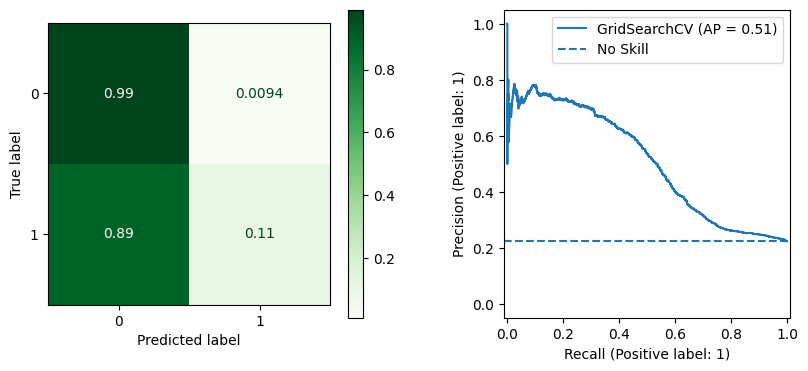

Support Vector Machine with PCA
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'C': 1.0, 'penalty': 'l1'}
Best validation score:	0.1692944866232895
Test Scores:
- Accuracy:	0.7925955951898392
- Recall:	0.09993943064809206
- Precision:	0.7710280373831776
- F1-score:	0.1769436997319035
- AUC:		0.5358755729563185


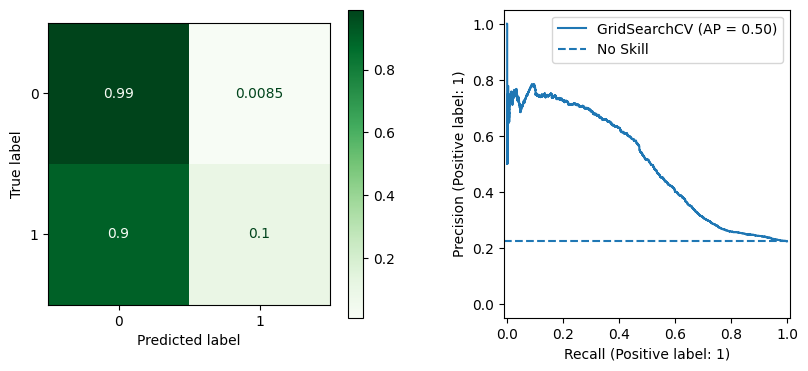

Support Vector Machine with PCA + SMOTE oversampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'C': 100.0, 'penalty': 'l1'}
Best validation score:	0.6627571908182401
Test Scores:
- Accuracy:	0.6311309282529388
- Recall:	0.6795881284070261
- Precision:	0.337646704784833
- F1-score:	0.451145958986731
- AUC:		0.5443558303238042


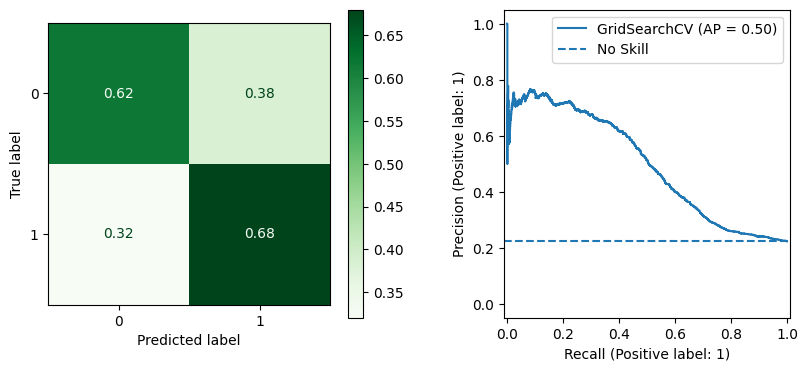

Support Vector Machine with PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'C': 0.1, 'penalty': 'l1'}
Best validation score:	0.7011763197598423
Test Scores:
- Accuracy:	0.7113903526550466
- Recall:	0.2828588734100545
- Precision:	0.32910500352360816
- F1-score:	0.3042345276872964
- AUC:		0.38597112911674347


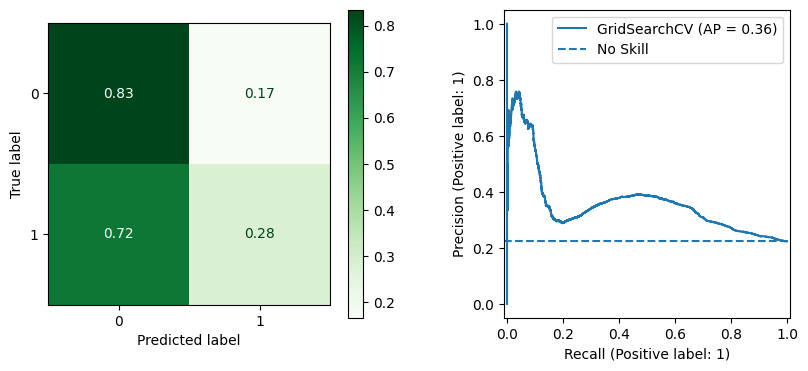

Support Vector Machine with PCA + ClusterCentroids oversampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'C': 0.1, 'penalty': 'l1'}
Best validation score:	0.6553805268413104
Test Scores:
- Accuracy:	0.5945142548304283
- Recall:	0.6735311932162326
- Precision:	0.3111359820928931
- F1-score:	0.42564593301435405
- AUC:		0.5287475857629266


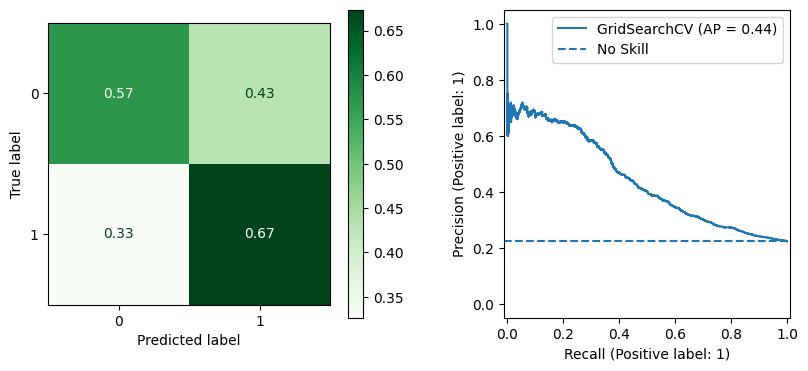

,Accuracy,Recall,Precision,F1-score,AUC
Raw data,0.793406,0.106602,0.765217,0.187135,0.535558
PCA,0.792596,0.099939,0.771028,0.176944,0.535876
PCA + SMOTE oversampling,0.631131,0.679588,0.337647,0.451146,0.544356
PCA + KMeansSMOTE oversampling,0.711390,0.282859,0.329105,0.304235,0.385971
PCA + ClusterCentroids oversampling,0.594514,0.673531,0.311136,0.425646,0.528748


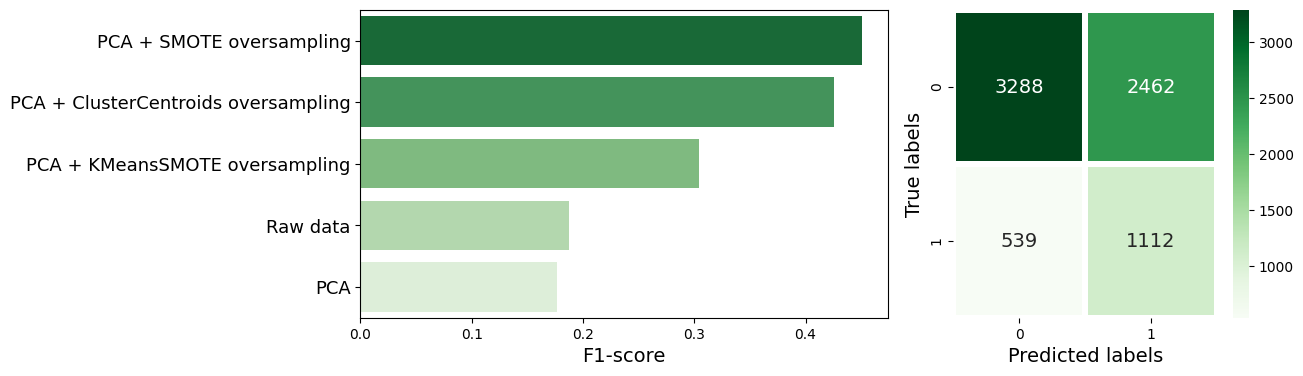

In [52]:
from sklearn.svm import LinearSVC

#params_svm = {'C': [1e-1, 1e0, 1e1, 1e2],  # C参数列表
#              'kernel': ['rbf', 'poly'],  # 核函数列表
#              'gamma': [1e-1, 'scale']}  # gamma参数列表
params_svm = {'C': [1e-1, 1e0, 1e1, 1e2],  # C参数列表
              'penalty': ['l1', 'l2']}  # penalty参数列表
for idx, oversample in enumerate(oversample_method):  # 遍历重采样方法
    print(f"Support Vector Machine with {oversample_names[idx]}")  # 打印当前使用的重采样方法
    #scores, y_pred_max, y_test_max = pipeline(SVC(),  # 调用pipeline函数训练SVM模型
    scores, y_pred_max, y_test_max = pipeline(LinearSVC(dual=False),  # 调用pipeline函数训练SVM模型
                                             params_svm,  # 传入参数网格
                                             oversample)  # 传入重采样方法
    scores_svm['Accuracy'][idx] = scores[0]  # 保存准确率
    scores_svm['Recall'][idx] = scores[1]  # 保存召回率
    scores_svm['Precision'][idx] = scores[2]  # 保存精确率
    scores_svm['F1-score'][idx] = scores[3]  # 保存F1分数
    scores_svm['AUC'][idx] = scores[4]  # 保存AUC

scores_svm_df = pd.DataFrame(data=scores_svm, index=oversample_names)  # 将评估指标字典转换为DataFrame
plot = plot_summary(scores_svm_df["F1-score"], oversample_names, y_pred_max, y_test_max)  # 绘制总结图
plot.savefig("images/summarySVM.svg")  # 保存总结图
scores_svm_df  # 显示评估指标DataFrame



## 5.3 基于树的方法  
基于树的方法为回归和分类任务提供了一种简单、直观且强大的建模机制。其核心思想是将（可能复杂的）特征空间**分层划分**为更小的区域，并对每个区域拟合一个简单的预测函数。
要对给定观测样本进行分类，通常使用该样本所属区域内训练样本的**众数响应值**（分类任务）或**均值响应值**（回归任务）。
由于分割预测变量空间的一系列规则可以表示为一棵树的结构，这类方法被称为**决策树方法**。

---

### 5.3.1 决策树  
如果关注模型的可解释性，决策树分类器是一个理想选择。其核心是通过对预测变量进行一系列**二元分割**，构建一棵树结构，从而将新观测样本分类到两个子类之一。  

**决策算法流程**：  
1. **根节点**：从树的根节点开始，选择能使**信息增益（IG）**最大化的特征进行数据分割：  
   • 若预测变量是**连续型**，选择使分割后两组的**纯度最大化**的切分点；  
   • 若预测变量是**类别型**，组合其类别以形成纯度最大的两组。  
2. **递归分割**：在每个子节点上重复上述分割过程，直到叶节点达到**纯度**（即同一节点内的训练样本属于同一类别）。  
3. **剪枝**：完全生长的树可能过大且过拟合，需通过限制最大深度或剪枝策略简化模型。  

**信息增益公式**：  
对于二叉决策树，每次分割的信息增益定义为：  
$$
IG(D_p, f)=I(D_p)-\sum_{j\in\{left,right\}}{\frac{N_{j}}{N_p}I(D_{j})}
$$  
• $ f $: 用于分割的特征；  
• $ D_p $: 父节点的数据集，$ D_j $: 第 $ j $ 个子节点的数据集；  
• $ I $: 不纯度度量函数；  
• $ N_p $: 父节点样本数，$ N_j $: 子节点样本数。  

信息增益即父节点不纯度与子节点不纯度加权和的差值。通过最大化信息增益选择最优分割特征。  

**不纯度度量**：  
最常用的两种指标是**基尼不纯度（Gini Impurity）**和**熵（Entropy）**。  
• **基尼不纯度**（衡量样本类别分布的均匀性）：  
  $$
  I_G(t)=\sum_{i=1}^{c}{p(i|t)(1-p(i|t))}
  $$  
• **熵**（衡量信息混乱程度）：  
  $$
  I_H(t)=-\sum_{i=1}^{c}{p(i|t)\log_2{p(i|t)}}
  $$  
  其中 $ p(i|t) $ 表示节点 $ t $ 中属于类别 $ i $ 的样本比例。  


（注：实际应用中需平衡模型复杂度和泛化性，通过调整树深或结合集成方法提升性能。）

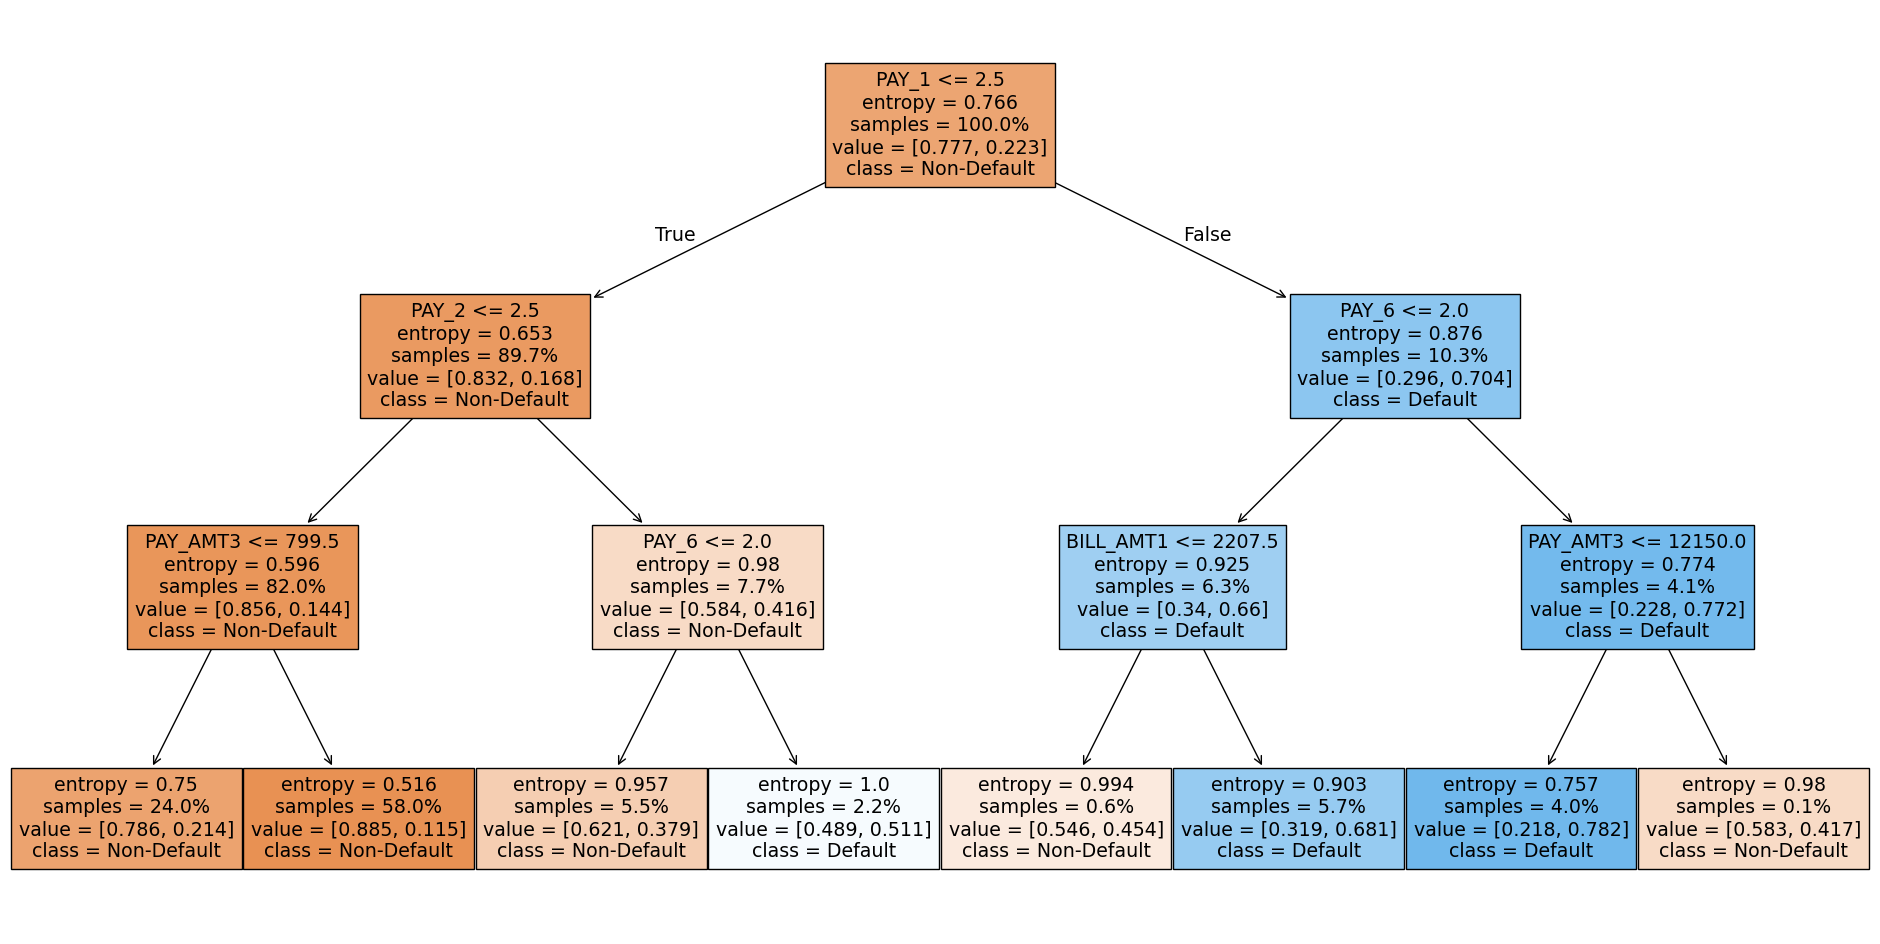

In [53]:
clf = DecisionTreeClassifier(max_depth=3,  # 设置最大深度为3
                             criterion='entropy',  # 使用熵作为划分标准
                             max_features=None)  # 不限制最大特征数
clf.fit(X_train_raw, y_train)  # 使用原始训练数据训练决策树模型
plt.figure(figsize=(24, 12))  # 设置图像大小
tree.plot_tree(decision_tree=clf,  # 绘制决策树
              feature_names=X_train_raw.columns,  # 设置特征名称
              class_names=['Non-Default', 'Default'],  # 设置类别名称
              filled=True,  # 填充颜色
              proportion=True)  # 显示比例
plt.show()  # 显示图像

在实践中，基尼不纯度和熵通常会产生非常相似的结果。因此，我们认为没有必要花费太多时间来使用不同的不纯度标准评估树，我们宁愿尝试不同的剪枝截止值。

```python
params = {'max_depth': [5, 10, 20, 30, 50],
          'criterion': ['entropy']}
```

In [54]:
def plot_tree_test_scores(model, oversample, plot):

    if oversample == 'raw':  # 如果重采样方法为'raw'
        X_test_s = X_test_raw.copy()  # 使用原始测试数据
    else:
        X_test_s = X_test.copy()  # 否则使用经过处理的测试数据

    # 预测
    y_pred = model.predict(X_test_s)  # 使用模型进行预测

    # 进行各种测试
    test_acc = accuracy_score(y_test, y_pred)  # 计算准确率
    test_precision = precision_score(y_test, y_pred)  # 计算精确率
    test_recall = recall_score(y_test, y_pred)  # 计算召回率
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)  # 计算PR曲线
    test_auc = auc(recall, precision)  # 计算AUC
    test_f1 = f1_score(y_test, y_pred)  # 计算F1分数

    # 在控制台上打印
    print("Test Scores:")
    print(f"- Accuracy:\t{test_acc}")
    print(f"- Recall:\t{test_recall}")
    print(f"- Precision:\t{test_precision}")
    print(f"- F1-score:\t{test_f1}")
    print(f"- AUC:\t\t{test_auc}")

    # 绘制结果
    if plot:  # 如果需要绘制
        fig, axs = plt.subplots(1, 3, figsize=(15,4))  # 创建子图

        tmp = pd.DataFrame({'Feature': X_test_s.columns,
                                     'Feature importance': model.best_estimator_.feature_importances_})  # 创建特征重要性DataFrame
        tmp = tmp.sort_values(by='Feature importance', ascending=False)  # 按特征重要性排序
        s = sns.barplot(x='Feature', y='Feature importance', data=tmp, ax=axs[0])  # 绘制特征重要性条形图
        s.set_xticklabels(s.get_xticklabels(), rotation=90)  # 设置x轴标签旋转

        # 替换混淆矩阵绘制函数
        ConfusionMatrixDisplay.from_estimator(model, X_test_s, y_test, cmap=plt.cm.Greens, normalize='true', ax=axs[1])  # 使用ConfusionMatrixDisplay绘制混淆矩阵
        axs[1].grid(False)  # 禁用网格线，避免与热力图重叠

        no_skill = len(y_test[y_test==1]) / len(y_test)  # 计算无技能水平

        # 替换PR曲线绘制函数
        PrecisionRecallDisplay.from_estimator(model, X_test_s, y_test, ax=axs[2])  # 使用PrecisionRecallDisplay绘制PR曲线
        axs[2].axhline(no_skill, 0, ls='--', label='No Skill')  # 绘制无技能水平线
        axs[2].set_ylim([-0.05, 1.05])  # 设置y轴范围
        axs[2].legend(loc = 'upper right')  # 显示图例
        plt.show()  # 显示图像
    else:  # 如果不需要绘制
        fig, axs = plt.subplots(1, 2, figsize=(10,4))  # 创建子图
        # 替换混淆矩阵绘制函数
        ConfusionMatrixDisplay.from_estimator(model, X_test_s, y_test, cmap=plt.cm.Greens, normalize='true', ax=axs[0])  # 使用ConfusionMatrixDisplay绘制混淆矩阵
        axs[0].grid(False)  # 禁用网格线，避免与热力图重叠

        no_skill = len(y_test[y_test==1]) / len(y_test)  # 计算无技能水平
        # 替换PR曲线绘制函数
        PrecisionRecallDisplay.from_estimator(model, X_test_s, y_test, ax=axs[1])  # 使用PrecisionRecallDisplay绘制PR曲线
        axs[1].axhline(no_skill, 0, ls='--', label='No Skill')  # 绘制无技能水平线
        plt.ylim([-0.05, 1.05])  # 设置y轴范围
        axs[1].legend(loc = 'upper right')  # 显示图例
        plt.show()  # 显示图像

    return test_acc, test_recall, test_precision, test_f1, test_auc  # 返回测试指标

def tree_pipeline(model, params, oversample=None, plot=False):

    max_f1 = 0  # 初始化最大F1分数
    y_pred_max = 0  # 初始化预测结果
    y_test_max = 0  # 初始化测试结果

    if oversample:  # 如果有重采样方法
        if oversample == 'raw':  # 如果重采样方法为'raw'
            X_train_s = X_train_raw.copy()  # 使用原始训练数据
            y_train_s = y_train.copy()  # 使用原始训练标签
            X_test_f1 = X_test_raw.copy()  # 使用原始测试数据
        else:  # 否则
            X_train_s, y_train_s = oversample.fit_resample(X_train, y_train)  # 使用重采样方法进行重采样
            X_test_f1 = X_test.copy()  # 使用经过处理的测试数据
    else:  # 如果没有重采样方法
        X_train_s = X_train.copy()  # 使用经过处理的训练数据
        y_train_s = y_train.copy()  # 使用训练标签
        X_test_f1 = X_test.copy()  # 使用经过处理的测试数据

    # 网格搜索最佳参数
    gridsearch = GridSearchCV(estimator = model,  # 设置估计器
                                param_grid = params,  # 设置参数网格
                                scoring = 'f1',  # 设置评分标准
                                cv = 5,  # 设置交叉验证折数
                                n_jobs = -1,  # 设置并行任务数
                                verbose = True)  # 设置详细模式
    gridsearch.fit(X_train_s, y_train_s)  # 进行网格搜索
    print(f"Best parameters:\t{gridsearch.best_params_}")  # 打印最佳参数
    print(f"Best validation score:\t{gridsearch.best_score_}")  # 打印最佳验证得分

    test_scores = plot_tree_test_scores(gridsearch, oversample, plot)  # 计算测试得分

    best_estimator = gridsearch.best_estimator_  # 获取最佳估计器

    # 保存最佳配置
    y_pred = best_estimator.predict(X_test_f1)  # 使用最佳估计器进行预测
    f1 = round(f1_score(y_test, y_pred),2)  # 计算F1分数

    if f1 > max_f1:  # 如果当前F1分数大于最大F1分数
        y_pred_max = y_pred  # 更新预测结果
        y_test_max = y_test  # 更新测试结果
        max_f1 = f1  # 更新最大F1分数

    return test_scores, y_pred_max, y_test_max  # 返回测试得分、预测结果和测试结果

In [55]:
oversample_method = ['raw',  # 原始数据
                     None,   # PCA
                     SMOTE(random_state=24),  # SMOTE过采样
                     KMeansSMOTE(cluster_balance_threshold=1e-5, random_state=24),  # KMeansSMOTE过采样
                     ClusterCentroids(random_state=24)]  # ClusterCentroids过采样

oversample_names = ['Raw data',  # 原始数据
                    'PCA',  # PCA
                    'PCA + SMOTE oversampling',  # PCA + SMOTE过采样
                    'PCA + KMeansSMOTE oversampling',  # PCA + KMeansSMOTE过采样
                    'PCA + ClusterCentroids oversampling']  # PCA + ClusterCentroids过采样

scores_tree = {'Accuracy': [float for i in range(len(oversample_method))],  # 准确率
               'Recall': [float for i in range(len(oversample_method))],  # 召回率
               'Precision': [float for i in range(len(oversample_method))],  # 精确率
               'F1-score': [float for i in range(len(oversample_method))],  # F1分数
               'AUC': [float for i in range(len(oversample_method))], }  # AUC

Decision Tree with Raw data
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 5}
Best validation score:	0.45813216221308634
Test Scores:
- Accuracy:	0.8205647885420889
- Recall:	0.35978195033313143
- Precision:	0.6867052023121387
- F1-score:	0.47217806041335453
- AUC:		0.5946528453403355


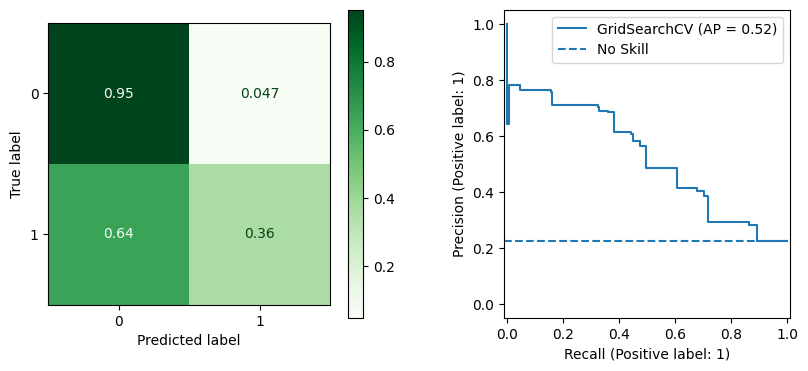

Decision Tree with PCA
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 10}
Best validation score:	0.4317277131175173
Test Scores:
- Accuracy:	0.8100256722064586
- Recall:	0.36220472440944884
- Precision:	0.6288117770767613
- F1-score:	0.45964642582628745
- AUC:		0.5666472860086097


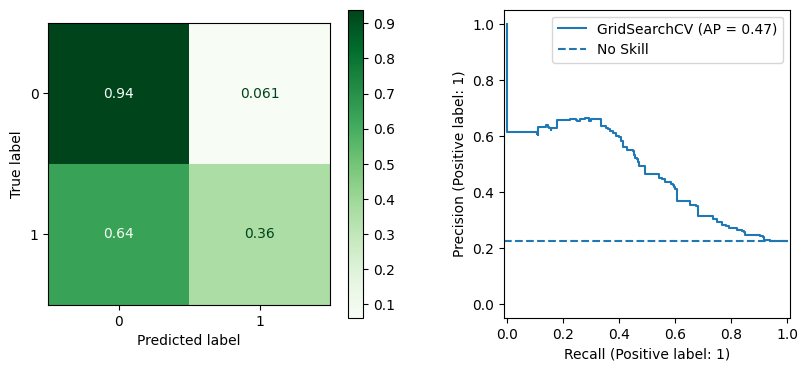

Decision Tree with PCA + SMOTE oversampling
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 50}
Best validation score:	0.7643213184557404
Test Scores:
- Accuracy:	0.68571814619646
- Recall:	0.48152634766807995
- Precision:	0.3509933774834437
- F1-score:	0.40602655771195095
- AUC:		0.4740898855456308


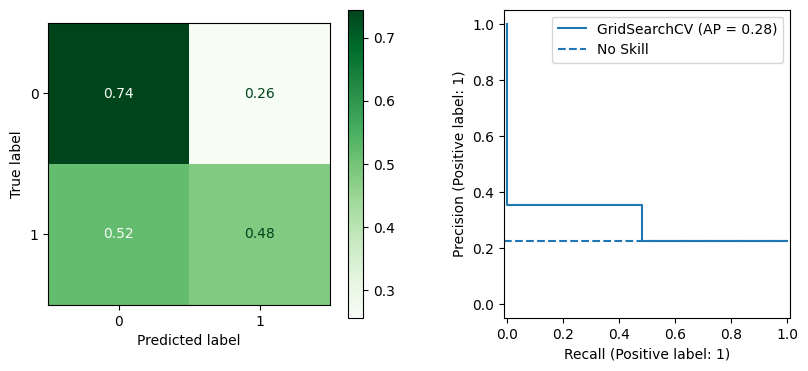

Decision Tree with PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 20}
Best validation score:	0.7721762680295132
Test Scores:
- Accuracy:	0.7459802729360897
- Recall:	0.418534221683828
- Precision:	0.42892613283674735
- F1-score:	0.42366646229307175
- AUC:		0.4885862777872435


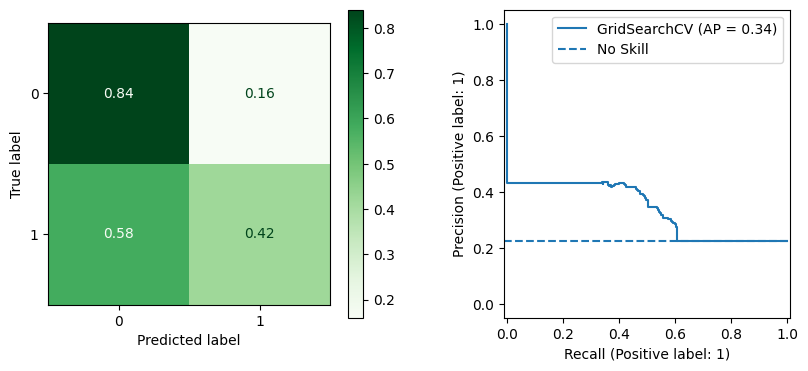

Decision Tree with PCA + ClusterCentroids oversampling
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 10}
Best validation score:	0.652073184898346
Test Scores:
- Accuracy:	0.5239832455073639
- Recall:	0.6565717746820109
- Precision:	0.26831683168316833
- F1-score:	0.38095238095238093
- AUC:		0.5007499375563229


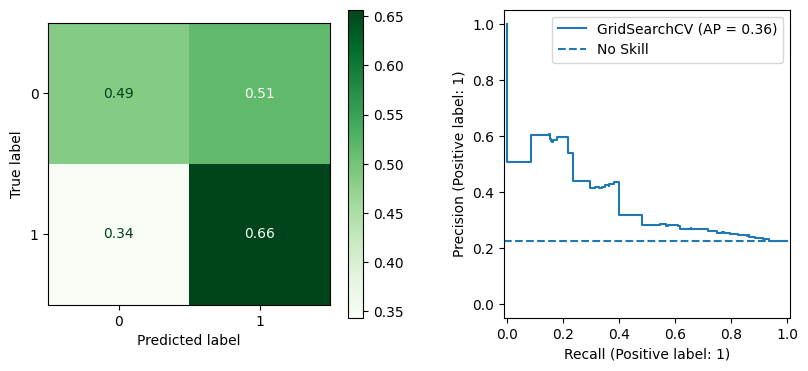

,Accuracy,Recall,Precision,F1-score,AUC
Raw data,0.820565,0.359782,0.686705,0.472178,0.594653
PCA,0.810026,0.362205,0.628812,0.459646,0.566647
PCA + SMOTE oversampling,0.685718,0.481526,0.350993,0.406027,0.474090
PCA + KMeansSMOTE oversampling,0.745980,0.418534,0.428926,0.423666,0.488586
PCA + ClusterCentroids oversampling,0.523983,0.656572,0.268317,0.380952,0.500750


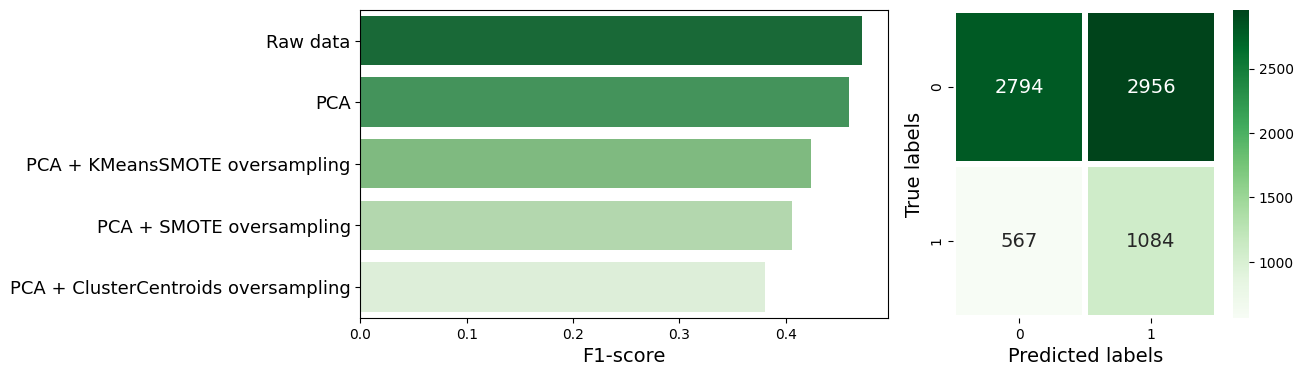

In [56]:
params_tree = {'max_depth': [5, 10, 20, 30, 50]}  # 设置决策树的最大深度参数列表
for idx, oversample in enumerate(oversample_method):  # 遍历每种过采样方法
    print(f"Decision Tree with {oversample_names[idx]}")  # 打印当前使用的过采样方法名称
    scores, y_pred_max, y_test_max = tree_pipeline(DecisionTreeClassifier(criterion='entropy', max_features=None, random_state=24),  # 调用决策树训练管道
                                                 params_tree,  # 传入决策树参数
                                                 oversample)  # 传入过采样方法
    scores_tree['Accuracy'][idx] = scores[0]  # 保存准确率
    scores_tree['Recall'][idx] = scores[1]  # 保存召回率
    scores_tree['Precision'][idx] = scores[2]  # 保存精确率
    scores_tree['F1-score'][idx] = scores[3]  # 保存F1分数
    scores_tree['AUC'][idx] = scores[4]  # 保存AUC

scores_rf_tree = pd.DataFrame(data=scores_tree, index=oversample_names)  # 将结果保存到DataFrame
plot = plot_summary(scores_rf_tree["F1-score"], oversample_names, y_pred_max, y_test_max)  # 绘制总结图
plot.savefig("images/summaryTree.svg")  # 保存总结图
scores_rf_tree  # 显示结果DataFrame

上述数据框中的结果表明，​决策树在原始数据上表现最佳。以此为基准，我们尝试通过聚合多个决策树构建随机森林来提升预测性能。

### 5.3.2 随机森林  
决策树存在**高方差问题**：若将训练数据随机划分为两部分并分别在每部分上训练决策树，可能得到差异显著的结果。为了降低模型方差（使其在不同数据集上表现稳定），可通过**集成学习**（Ensemble Learning）将多个分类器的预测结果取平均。但由于实际中难以获取多个独立训练集，我们采用**自助采样法（Bootstrap Sampling）**从数据集中重复抽样生成不同的**自助训练集**，并基于每个自助集训练一棵决策树，最终通过**多数投票法（Majority Voting）**汇总预测结果。该方法称为**自助聚合（Bagging）**。

**随机森林的核心思想**：在Bagging基础上，通过**特征随机选择**降低树间的相关性。具体流程如下：  
1. **自助采样**：从原始训练集中有放回地抽取 $ N $ 个样本（与原始数据集大小相同），生成一个自助训练集。  
2. **特征子集选择**：在每棵树的每个分裂节点，仅随机选取 $ m $ 个候选特征（通常 $ m = \sqrt{p} $，$ p $ 为总特征数），从中选择最优分裂特征。  
3. **独立训练**：基于每个自助训练集和对应的随机特征子集，训练多棵决策树。  
4. **投票聚合**：对测试样本的预测结果取众数（分类）或均值（回归）。  

**优势分析**：  
• **降低方差**：通过平均多棵树的预测减少模型波动性。  
• **去相关性**：随机选择特征削弱“强预测因子”在根节点的主导作用，减少树间相关性。  
• **鲁棒性**：对单棵树的噪声不敏感，无需精细调节单棵树深度。  

**Scikit-Learn实现细节**：  
• 在 `RandomForestClassifier` 中：  
  • 自助样本大小默认等于原始训练集规模，以平衡偏差与方差。  
  • 关键参数：  
    ◦ `n_estimators`：森林中树的数量（通常越多越好，但计算成本增加）。  
    ◦ `max_features`：每次分裂时考虑的最大特征数：  
      ◦ 若设为 `None`（即使用全部特征），则退化为普通Bagging，失去去相关性效果。  

---

**模型选择建议**：  
• 优先调节 `n_estimators`（如100~500）和 `max_features`（如 `sqrt` 或 `log2`）。  
• 通过交叉验证评估参数组合，避免过拟合。  

（注：随机森林在大多数场景中优于单棵决策树，但可解释性有所降低。）


```python
params = {'n_estimators': [10, 50, 100, 200],
          'max_features': [None, 'sqrt']}
```

In [57]:
oversample_method = ['raw',  # 原始数据
                     None,   # PCA
                     SMOTE(random_state=24),  # SMOTE过采样
                     KMeansSMOTE(cluster_balance_threshold=1e-5, random_state=24),  # KMeansSMOTE过采样
                     ClusterCentroids(random_state=24)]  # ClusterCentroids过采样

oversample_names = ['Raw data',  # 原始数据
                    'PCA',  # PCA
                    'PCA + SMOTE oversampling',  # PCA + SMOTE过采样
                    'PCA + KMeansSMOTE oversampling',  # PCA + KMeansSMOTE过采样
                    'PCA + ClusterCentroids oversampling']  # PCA + ClusterCentroids过采样

scores_rf = {'Accuracy': [float for i in range(len(oversample_method))],  # 准确率
             'Recall': [float for i in range(len(oversample_method))],  # 召回率
             'Precision': [float for i in range(len(oversample_method))],  # 精确率
             'F1-score': [float for i in range(len(oversample_method))],  # F1分数
             'AUC': [float for i in range(len(oversample_method))], }  # AUC

Random Forest with Raw data
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': None, 'n_estimators': 200}
Best validation score:	0.46950306765596733
Test Scores:
- Accuracy:	0.8209701391703824
- Recall:	0.39672925499697154
- Precision:	0.665650406504065
- F1-score:	0.4971537001897533
- AUC:		0.598478035047235


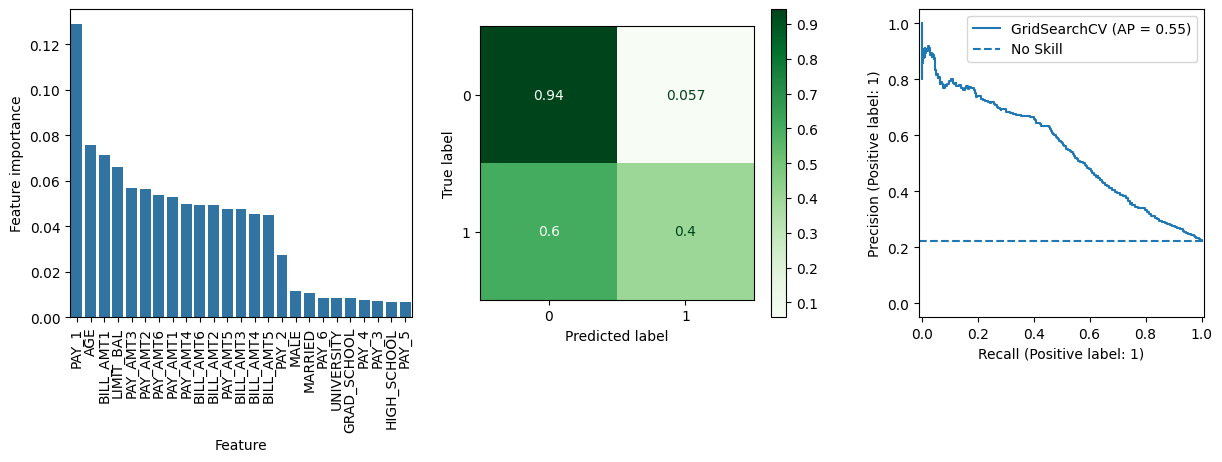

Random Forest with PCA
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': 'sqrt', 'n_estimators': 200}
Best validation score:	0.4425624595140773
Test Scores:
- Accuracy:	0.8084042696932847
- Recall:	0.36402180496668685
- Precision:	0.6202270381836945
- F1-score:	0.4587786259541985
- AUC:		0.5630607815265486


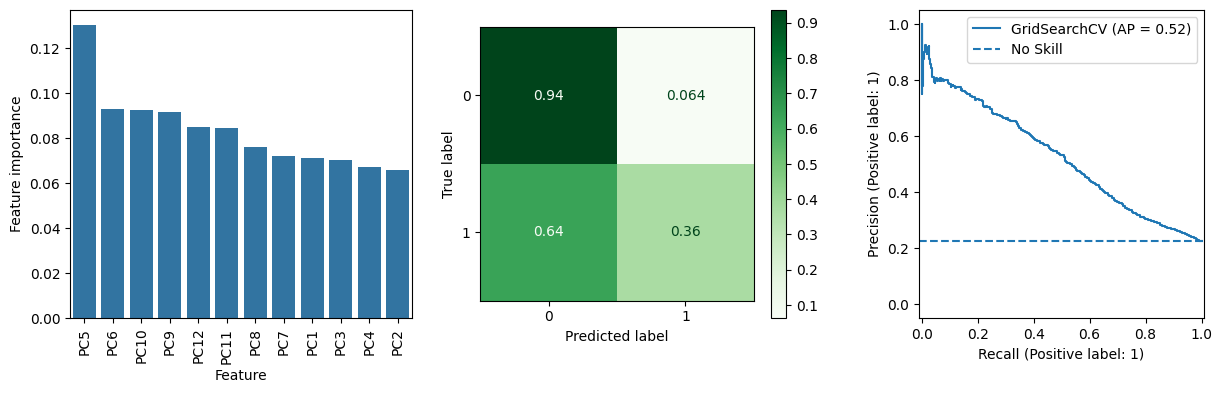

Random Forest with PCA + SMOTE oversampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': 'sqrt', 'n_estimators': 200}
Best validation score:	0.835020869648081
Test Scores:
- Accuracy:	0.7628698824483178
- Recall:	0.5202907328891581
- Precision:	0.47145993413830956
- F1-score:	0.49467319320472214
- AUC:		0.5493816164484724


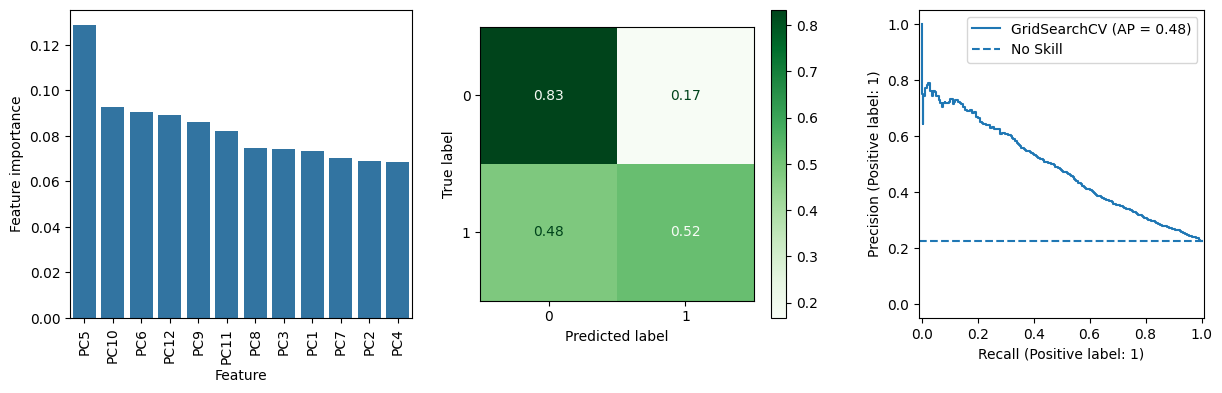

Random Forest with PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': None, 'n_estimators': 50}
Best validation score:	0.8011812644971897
Test Scores:
- Accuracy:	0.783542764491285
- Recall:	0.4209569957601454
- Precision:	0.5182699478001491
- F1-score:	0.464572192513369
- AUC:		0.5341993385549074


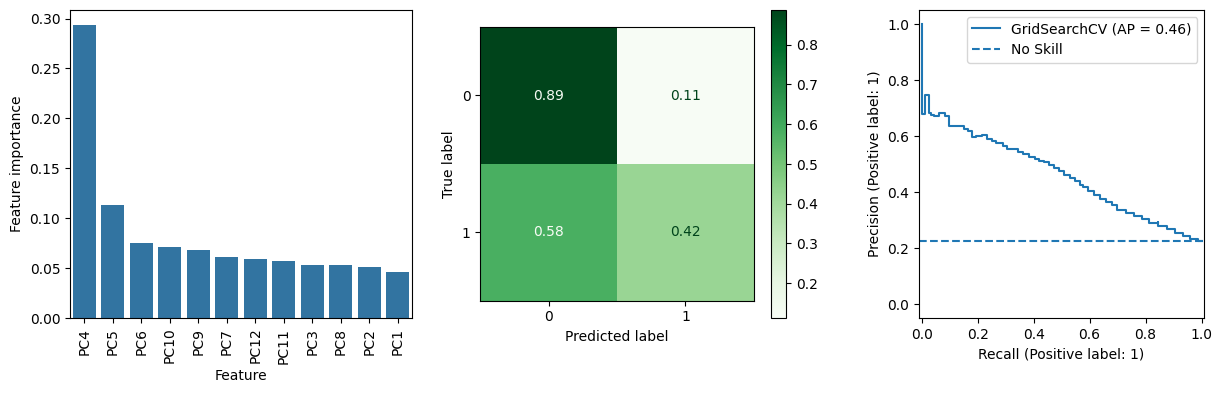

Random Forest with PCA + ClusterCentroids oversampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': 'sqrt', 'n_estimators': 200}
Best validation score:	0.6681947519895648
Test Scores:
- Accuracy:	0.5851911903796784
- Recall:	0.6571774682010902
- Precision:	0.30231262190025077
- F1-score:	0.41412213740458015
- AUC:		0.5179831209863549


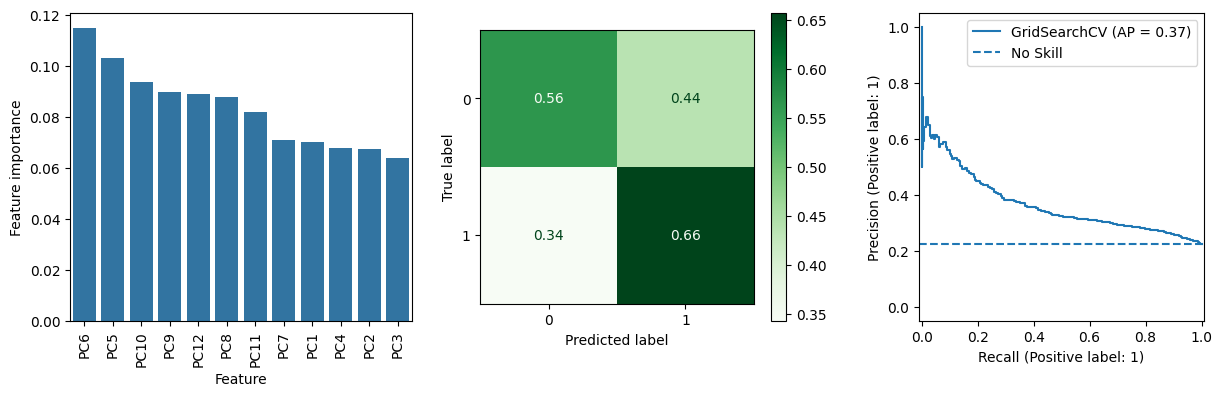

,Accuracy,Recall,Precision,F1-score,AUC
Raw data,0.820970,0.396729,0.665650,0.497154,0.598478
PCA,0.808404,0.364022,0.620227,0.458779,0.563061
PCA + SMOTE oversampling,0.762870,0.520291,0.471460,0.494673,0.549382
PCA + KMeansSMOTE oversampling,0.783543,0.420957,0.518270,0.464572,0.534199
PCA + ClusterCentroids oversampling,0.585191,0.657177,0.302313,0.414122,0.517983


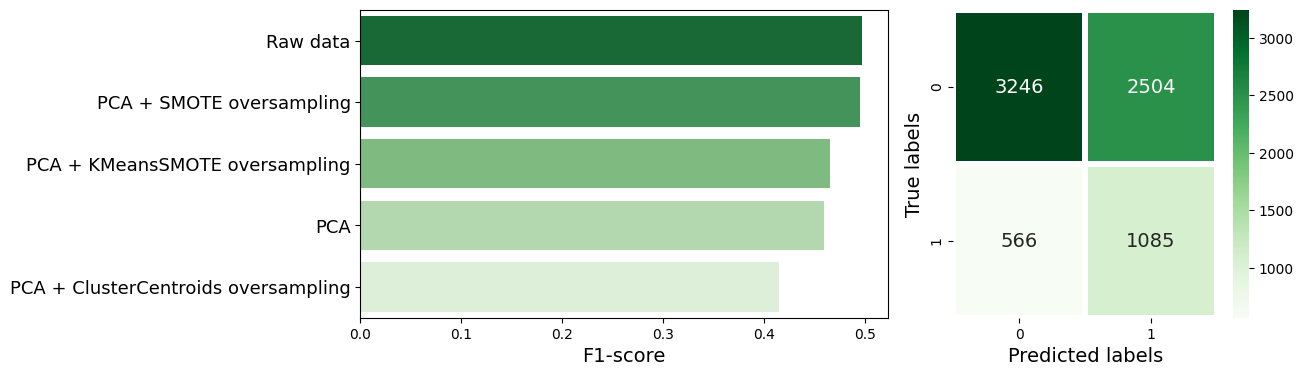

In [58]:
params_rf = {'n_estimators': [10, 50, 100, 200],  # 设置随机森林的估计器数量参数列表
             'max_features': [None, 'sqrt']}  # 设置随机森林的最大特征数参数列表
for idx, oversample in enumerate(oversample_method):  # 遍历每种过采样方法
    print(f"Random Forest with {oversample_names[idx]}")  # 打印当前使用的过采样方法名称
    scores, y_pred_max, y_test_max = tree_pipeline(RandomForestClassifier(criterion='entropy', random_state=24, n_jobs=-1),  # 调用随机森林训练管道
                                                 params_rf,  # 传入随机森林参数
                                                 oversample,  # 传入过采样方法
                                                 True)  # 设置绘制图像为True
    scores_rf['Accuracy'][idx] = scores[0]  # 保存准确率
    scores_rf['Recall'][idx] = scores[1]  # 保存召回率
    scores_rf['Precision'][idx] = scores[2]  # 保存精确率
    scores_rf['F1-score'][idx] = scores[3]  # 保存F1分数
    scores_rf['AUC'][idx] = scores[4]  # 保存AUC

scores_rf_df = pd.DataFrame(data=scores_rf, index=oversample_names)  # 将结果保存到DataFrame
plot = plot_summary(scores_rf_df["F1-score"], oversample_names, y_pred_max, y_test_max)  # 绘制总结图
plot.savefig("images/summaryRF.svg")  # 保存总结图
scores_rf_df  # 显示结果DataFrame

上面数据框中报告的结果表明，在森林中聚合多棵树可以全面提高预测性能。Bagging 和随机森林模型不像单个决策树那样具有可解释性。然而，它们允许我们测量和绘制特征重要性，作为从集成中的所有决策树计算出的平均不纯度减少量，而无需对我们的数据是否线性可分做出任何假设。

特别是，我们可以参考在原始数据上训练的随机森林，因为它提供了非常有用的特征重要性图。当金融机构考虑向客户发行信用卡时，他们需要检查该人的付款历史，因为如果他已经欠了很多账单，他很可能会拖延当月的付款。除了付款历史外，查看申请人当前信用卡的信用额度也势在必行。这是良性循环的结果：按时付款的人往往有更好的信用评分，因此银行更愿意通过承担较小的风险来增加这些人的信用额度。客户的个人信息也会影响违约行为，因为这是银行在人们申请信用卡时收集的。然而，我们认为，金融机构在决定是否批准其信用卡申请时，应平等地考虑其潜在客户，无论他们是男性还是女性、高中或大学毕业生、单身还是已婚。

## 5.4 模型性能结果

下面的数据框总结了测试集中不同机器学习算法和过采样技术组合的结果。 下面的图进一步比较了测试集中不同模型的 F1 分数。 我们想澄清的是，与决策树和随机森林不同，逻辑回归和 SVM 并没有使用真正的*原始*数据，而是使用了归一化数据。

In [59]:
frames = [scores_lr_df, scores_svm_df, scores_rf_tree, scores_rf_df]  # 创建包含所有模型评分DataFrame的列表
scores_df = pd.concat(frames, keys=['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest'])  # 将所有DataFrame连接成一个DataFrame，并添加多级索引
scores_df  # 显示连接后的DataFrame

Accuracy  \
Logistic Regression    Raw data                             0.804756   
                       PCA                                  0.804351   
                       PCA + SMOTE oversampling             0.631807   
                       PCA + KMeansSMOTE oversampling       0.724362   
                       PCA + ClusterCentroids oversampling  0.597081   
Support Vector Machine Raw data                             0.793406   
                       PCA                                  0.792596   
                       PCA + SMOTE oversampling             0.631131   
                       PCA + KMeansSMOTE oversampling       0.711390   
                       PCA + ClusterCentroids oversampling  0.594514   
Decision Tree          Raw data                             0.820565   
                       PCA                                  0.810026   
                       PCA + SMOTE oversampling             0.685718   
                       PCA + KMeansSMOTE oversampling       0.745980   
                       PCA + ClusterCentroids oversampling  0.523983   
Random Forest          Raw data                             0.820970   
                       PCA                                  0.808404   
                       PCA + SMOTE oversampling             0.762870   
                       PCA + KMeansSMOTE oversampling       0.783543   
                       PCA + ClusterCentroids oversampling  0.585191   

                                                              Recall  \
Logistic Regression    Raw data                             0.198062   
                       PCA                                  0.192005   
                       PCA + SMOTE oversampling             0.678982   
                       PCA + KMeansSMOTE oversampling       0.362205   
                       PCA + ClusterCentroids oversampling  0.670503   
Support Vector Machine Raw data                             0.106602   
                       PCA                                  0.099939   
                       PCA + SMOTE oversampling             0.679588   
                       PCA + KMeansSMOTE oversampling       0.282859   
                       PCA + ClusterCentroids oversampling  0.673531   
Decision Tree          Raw data                             0.359782   
                       PCA                                  0.362205   
                       PCA + SMOTE oversampling             0.481526   
                       PCA + KMeansSMOTE oversampling       0.418534   
                       PCA + ClusterCentroids oversampling  0.656572   
Random Forest          Raw data                             0.396729   
                       PCA                                  0.364022   
                       PCA + SMOTE oversampling             0.520291   
                       PCA + KMeansSMOTE oversampling       0.420957   
                       PCA + ClusterCentroids oversampling  0.657177   

                                                            Precision  \
Logistic Regression    Raw data                              0.729911   
                       PCA                                   0.735499   
                       PCA + SMOTE oversampling              0.338058   
                       PCA + KMeansSMOTE oversampling        0.377287   
                       PCA + ClusterCentroids oversampling   0.312271   
Support Vector Machine Raw data                              0.765217   
                       PCA                                   0.771028   
                       PCA + SMOTE oversampling              0.337647   
                       PCA + KMeansSMOTE oversampling        0.329105   
                       PCA + ClusterCentroids oversampling   0.311136   
Decision Tree          Raw data                              0.686705   
                       PCA                                   0.628812   
                       PCA + SMOTE oversampling              0.350993   
            

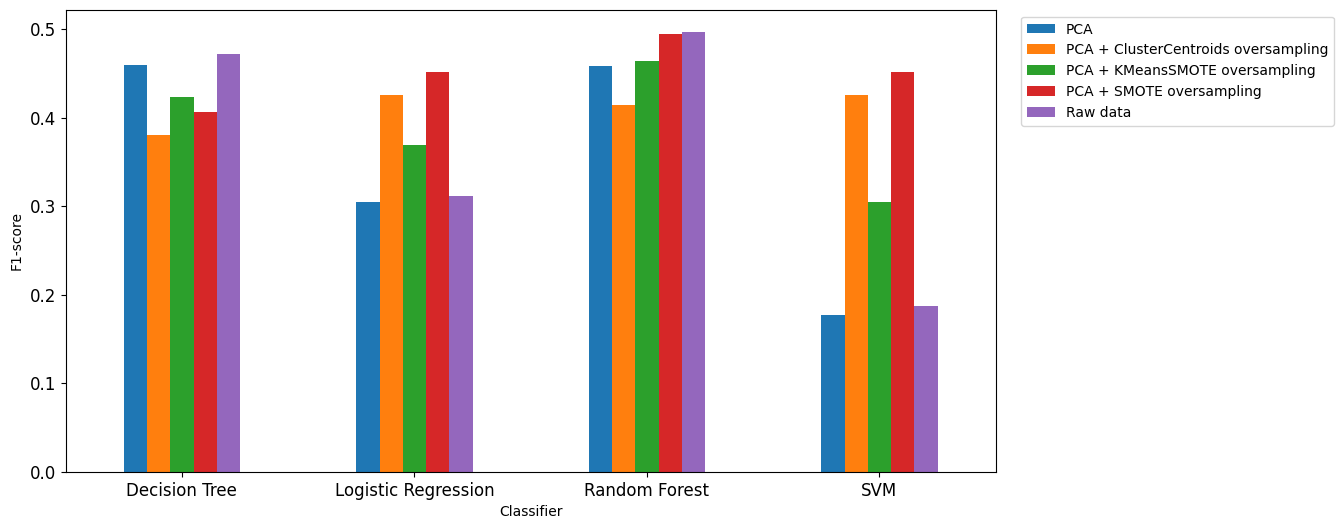

In [60]:
scores_lr_df['Classifier'] = 'Logistic Regression'  # 为逻辑回归评分DataFrame添加分类器列
scores_lr_df['Technique'] = scores_lr_df.index  # 为逻辑回归评分DataFrame添加技术列，并将索引设置为技术列

scores_svm_df['Classifier'] = 'SVM'  # 为SVM评分DataFrame添加分类器列
scores_svm_df['Technique'] = scores_svm_df.index  # 为SVM评分DataFrame添加技术列，并将索引设置为技术列

scores_rf_tree['Classifier'] = 'Decision Tree'  # 为决策树评分DataFrame添加分类器列
scores_rf_tree['Technique'] = scores_rf_tree.index  # 为决策树评分DataFrame添加技术列，并将索引设置为技术列
scores_rf_df['Classifier'] = 'Random Forest'  # 为随机森林评分DataFrame添加分类器列
scores_rf_df['Technique'] = scores_rf_df.index  # 为随机森林评分DataFrame添加技术列，并将索引设置为技术列

frames2 = [scores_lr_df, scores_svm_df, scores_rf_tree, scores_rf_df]  # 创建包含所有评分DataFrame的列表
scores = pd.concat(frames2, ignore_index=True, keys=None)  # 将所有评分DataFrame连接成一个DataFrame，忽略索引

scores.set_index(['Technique', 'Classifier']).unstack(0).plot(kind='bar',  # 设置索引，取消堆叠，绘制条形图
                                                              y='F1-score',  # 设置y轴为F1分数
                                                              ylabel='F1-score',  # 设置y轴标签
                                                              figsize=(12, 6),  # 设置图像大小
                                                              fontsize=12,  # 设置字体大小
                                                              rot=0).legend(bbox_to_anchor=(1.02, 1))  # 设置图例位置